In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # For a nice progress bar!
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
def concat_csv():
    # Take the path of all the data
    # Read data
    df = pd.read_csv('/content/japandata.csv',header=0)
    df.set_index('Time', inplace=True)
    df = df.fillna(method = 'ffill')
    return df

In [ ]:
df = concat_csv()
print(df.head())  # Hiển thị 5 dòng đầu tiên
print(df.info())  # Kiểm tra kiểu dữ liệu

               Temperature  Wind speed  Relative humidity (%)  \
Time                                                            
1/1/2015 0:00          4.2         1.5                   79.0   
1/1/2015 1:00          4.6         3.6                   68.0   
1/1/2015 2:00          4.7         3.6                   60.0   
1/1/2015 3:00          4.4         4.6                   50.0   
1/1/2015 4:00          2.9         2.6                   49.0   

               Solar radiation  \
Time                             
1/1/2015 0:00              0.0   
1/1/2015 1:00              0.0   
1/1/2015 2:00              0.0   
1/1/2015 3:00              0.0   
1/1/2015 4:00              0.0   

               Active power of purchased electricity at the receiving end  
Time                                                                       
1/1/2015 0:00                                         546.620999           
1/1/2015 1:00                                         587.033331           
1

<ipython-input-33-820969ceda7d>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method = 'ffill')


In [ ]:
df = concat_csv()
print(df.head())

               Temperature  Wind speed  Relative humidity (%)  \
Time                                                            
1/1/2015 0:00          4.2         1.5                   79.0   
1/1/2015 1:00          4.6         3.6                   68.0   
1/1/2015 2:00          4.7         3.6                   60.0   
1/1/2015 3:00          4.4         4.6                   50.0   
1/1/2015 4:00          2.9         2.6                   49.0   

               Solar radiation  \
Time                             
1/1/2015 0:00              0.0   
1/1/2015 1:00              0.0   
1/1/2015 2:00              0.0   
1/1/2015 3:00              0.0   
1/1/2015 4:00              0.0   

               Active power of purchased electricity at the receiving end  
Time                                                                       
1/1/2015 0:00                                         546.620999           
1/1/2015 1:00                                         587.033331           
1

<ipython-input-33-820969ceda7d>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method = 'ffill')


In [ ]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr(method='spearman')  # Calculate Spearman correlation
    num_columns = len(corr_matrix.columns)
    for i in range(num_columns):
        if i != 0:
            if abs(corr_matrix.iloc[i,17 ]) < threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr
def get_loader(dataset,batch_size=16,shuffle=False):

    loader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=shuffle)
    return loader

def save_checkpoint(state, filename="/content/checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
def ordered_train_val_test_split(df, val_size, test_size):
    # Calculate the splitting indices
    val_index = int(len(df) * (1 - val_size - test_size))
    test_index = int(len(df) * (1 - test_size))

    # Split the DataFrame
    train_data = df.iloc[:val_index]
    val_data = df.iloc[val_index:test_index]
    test_data = df.iloc[test_index:]

    return train_data, val_data, test_data

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class LSTM(nn.Module):
    def __init__(self,input_size=8,hidden_size=256,num_layers=2,seq_length=12):
        super(LSTM,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size*seq_length,seq_length)
    def forward(self,x):
        out,(hidden,cell) = self.lstm(x)
        # out: tensor of shape (batch_size, seq_length, hidden_size)

        out = out.reshape(out.shape[0],-1)
        # out: tensor of shape (batch_size, seq_length * hidden_size)

        out = self.fc(out)
        # out: shape (batch_size,seq_length)
        return out

In [ ]:
class Irradiation_Dataset(Dataset):
    def __init__(self,data,target,trainop1=True):
        self.data = data # shape [num_samples,num_feature]
        self.target = target # shape [num_samples,1]
        self.trainop1 = trainop1
    def __len__(self):
        if self.trainop1:
            return self.data.shape[0]//24-1
        else:
            return self.data.shape[0]//24

    def __getitem__(self,index):
        if self.trainop1:
            seq_length =  24
            features_start_idx = index*seq_length
            features_end_idx = (index+1)*seq_length

            targets_start_idx = (index+1)*seq_length
            targets_end_idx = targets_start_idx+24
            features = self.data[features_start_idx:features_end_idx, :]
            targets = self.target[targets_start_idx:targets_end_idx]

            return torch.tensor(features),torch.tensor(targets)
        else:
            seq_length =  24
            features_start_idx = index*seq_length
            features_end_idx = (index+1)*seq_length

            targets_start_idx = index * seq_length
            targets_end_idx = (index+1)*seq_length
            features = self.data[features_start_idx:features_end_idx, :]
            targets = self.target[targets_start_idx:targets_end_idx]
        return torch.tensor(features),torch.tensor(targets)

In [ ]:
df = concat_csv()

target_column = 'Active power of purchased electricity at the receiving end'
trainop1 = True

X = df
Y = df[target_column]
Y = pd.DataFrame({target_column: Y})

X_train, X_val, X_test = ordered_train_val_test_split(X,0.1,0.1)
Y_train, Y_val, Y_test = ordered_train_val_test_split(Y,0.1,0.1)

if not trainop1:
    X_train = X_train.drop(target_column,axis=1)
    X_val = X_val.drop(target_column,axis=1)
    X_test = X_test.drop(target_column,axis=1)

<ipython-input-33-820969ceda7d>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method = 'ffill')


In [ ]:
X_scaler = StandardScaler()
X_train = pd.DataFrame(X_scaler.fit_transform(X_train), columns=X_train.columns).values
X_val = pd.DataFrame(X_scaler.transform(X_val), columns=X_val.columns).values
X_test = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns).values


Y_scaler = StandardScaler()
Y_train = pd.DataFrame(Y_scaler.fit_transform(Y_train), columns=Y_train.columns).values
Y_val = pd.DataFrame(Y_scaler.transform(Y_val), columns=Y_val.columns).values
Y_test = pd.DataFrame(Y_scaler.transform(Y_test), columns=Y_test.columns).values

# print(Y_test)

In [ ]:
print("The shape of the original data:",df.shape)
print("The shape of the train data:",X_train.shape)
print("The shape of the train target:",Y_train.shape)
print("The shape of the val data:",X_val.shape)
print("The shape of the val target:",Y_val.shape)
print("The shape of the test data:",X_test.shape)
print("The shape of the test target:",Y_test.shape)

train_data = Irradiation_Dataset(X_train,Y_train,trainop1=trainop1)
val_data = Irradiation_Dataset(X_val,Y_val,trainop1=trainop1)
test_data = Irradiation_Dataset(X_test,Y_test,trainop1=trainop1)

print(len(train_data))
print(len(val_data))
print(len(test_data))

train_data_loader = get_loader(train_data)
val_data_loader = get_loader(val_data)
test_data_loader = get_loader(test_data)

The shape of the original data: (29040, 5)
The shape of the train data: (23232, 5)
The shape of the train target: (23232, 1)
The shape of the val data: (2904, 5)
The shape of the val target: (2904, 1)
The shape of the test data: (2904, 5)
The shape of the test target: (2904, 1)
967
120
120


In [ ]:
#HYPERPARAMETERS
input_size = 5
hidden_size = 64
num_layers = 2
sequence_length = 24
learning_rate = 0.01
batch_size = 16
num_epochs = 1000
min_valid_loss = np.inf

In [ ]:
# MODEL
model = LSTM(input_size=input_size,
             hidden_size=hidden_size,
             num_layers=num_layers,
             seq_length=sequence_length).to(device=device)

# randn_tensor = torch.randn((16,12,10))
# x = model(randn_tensor)
# x.shape

In [ ]:
#LOSS AND OPTIMIZER
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = optim.lr_scheduler.LinearLR(optimizer=optimizer,
                                        start_factor=1.0,
                                        end_factor=0.01)

In [ ]:
#TRAIN THE MODEL
for epoch in range(num_epochs):
    print("Epoch: ",epoch)
    train_loss = 0
    model.train()
    for batch_idx,(data,target) in enumerate(tqdm(train_data_loader)):
        data = data.to(device=device,dtype=torch.float)
        target = target.to(device=device,dtype=torch.float).squeeze(2)

        scores = model(data)
        loss = criterion(scores,target)

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        train_loss += loss.item()
    scheduler.step()
    print("Train Loss:",train_loss / len(train_data_loader))
    valid_loss = 0

    model.eval()
    with torch.no_grad():
        total_scores_val = None
        total_target_val = None
        for batch_idx_val,(data_val,target_val) in enumerate(tqdm(val_data_loader)):
            data_val = data_val.to(device=device,dtype=torch.float)
            target_val = target_val.to(device=device,dtype=torch.float).squeeze(2)

            scores_val = model(data_val)
            loss_val = criterion(scores_val,target_val)

            valid_loss += loss_val.item()
    print("Validation Loss:", valid_loss/len(val_data_loader))

    if min_valid_loss > valid_loss/len(val_data_loader):
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{(valid_loss/len(val_data_loader)):.6f} \t Saving The Model')
        min_valid_loss = valid_loss/len(val_data_loader)
        # Saving State Dict
        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        save_checkpoint(checkpoint)
        torch.save(model, "/content/model_predict_.pth.tar")

Epoch:  0


100%|██████████| 61/61 [00:00<00:00, 108.98it/s]


Train Loss: 0.6655068236296294


100%|██████████| 8/8 [00:00<00:00, 340.74it/s]


Validation Loss: 1.2279717698693275
Validation Loss Decreased(inf--->1.227972 	 Saving The Model
=> Saving checkpoint
Epoch:  1


100%|██████████| 61/61 [00:00<00:00, 117.79it/s]


Train Loss: 0.601931812333279


100%|██████████| 8/8 [00:00<00:00, 347.88it/s]


Validation Loss: 0.4038617331534624
Validation Loss Decreased(1.227972--->0.403862 	 Saving The Model
=> Saving checkpoint
Epoch:  2


100%|██████████| 61/61 [00:00<00:00, 114.06it/s]


Train Loss: 0.514551647129606


100%|██████████| 8/8 [00:00<00:00, 340.67it/s]


Validation Loss: 0.3863656483590603
Validation Loss Decreased(0.403862--->0.386366 	 Saving The Model
=> Saving checkpoint
Epoch:  3


100%|██████████| 61/61 [00:00<00:00, 90.44it/s]


Train Loss: 0.41085323007380375


100%|██████████| 8/8 [00:00<00:00, 260.07it/s]


Validation Loss: 0.41397793777287006
Epoch:  4


100%|██████████| 61/61 [00:00<00:00, 79.36it/s]


Train Loss: 0.37507895612325826


100%|██████████| 8/8 [00:00<00:00, 259.80it/s]


Validation Loss: 0.3491690158843994
Validation Loss Decreased(0.386366--->0.349169 	 Saving The Model
=> Saving checkpoint
Epoch:  5


100%|██████████| 61/61 [00:00<00:00, 80.17it/s]


Train Loss: 0.36418920181325226


100%|██████████| 8/8 [00:00<00:00, 242.38it/s]


Validation Loss: 0.3464123047888279
Validation Loss Decreased(0.349169--->0.346412 	 Saving The Model
=> Saving checkpoint
Epoch:  6


100%|██████████| 61/61 [00:00<00:00, 98.66it/s] 


Train Loss: 0.35999479059313166


100%|██████████| 8/8 [00:00<00:00, 238.13it/s]


Validation Loss: 0.345395240932703
Validation Loss Decreased(0.346412--->0.345395 	 Saving The Model
=> Saving checkpoint
Epoch:  7


100%|██████████| 61/61 [00:00<00:00, 115.74it/s]


Train Loss: 0.3585799699191187


100%|██████████| 8/8 [00:00<00:00, 331.63it/s]


Validation Loss: 0.3451951239258051
Validation Loss Decreased(0.345395--->0.345195 	 Saving The Model
=> Saving checkpoint
Epoch:  8


100%|██████████| 61/61 [00:00<00:00, 113.38it/s]


Train Loss: 0.3579210988322242


100%|██████████| 8/8 [00:00<00:00, 303.55it/s]


Validation Loss: 0.34493675641715527
Validation Loss Decreased(0.345195--->0.344937 	 Saving The Model
=> Saving checkpoint
Epoch:  9


100%|██████████| 61/61 [00:00<00:00, 116.56it/s]


Train Loss: 0.3574636346492611


100%|██████████| 8/8 [00:00<00:00, 352.69it/s]


Validation Loss: 0.34453986771404743
Validation Loss Decreased(0.344937--->0.344540 	 Saving The Model
=> Saving checkpoint
Epoch:  10


100%|██████████| 61/61 [00:00<00:00, 115.43it/s]


Train Loss: 0.3570616934143129


100%|██████████| 8/8 [00:00<00:00, 326.46it/s]


Validation Loss: 0.34403940103948116
Validation Loss Decreased(0.344540--->0.344039 	 Saving The Model
=> Saving checkpoint
Epoch:  11


100%|██████████| 61/61 [00:00<00:00, 117.19it/s]


Train Loss: 0.35667336414583395


100%|██████████| 8/8 [00:00<00:00, 348.53it/s]


Validation Loss: 0.3434702940285206
Validation Loss Decreased(0.344039--->0.343470 	 Saving The Model
=> Saving checkpoint
Epoch:  12


100%|██████████| 61/61 [00:00<00:00, 108.12it/s]


Train Loss: 0.35628503072457235


100%|██████████| 8/8 [00:00<00:00, 346.45it/s]


Validation Loss: 0.342854306101799
Validation Loss Decreased(0.343470--->0.342854 	 Saving The Model
=> Saving checkpoint
Epoch:  13


100%|██████████| 61/61 [00:00<00:00, 119.40it/s]


Train Loss: 0.3558917127427508


100%|██████████| 8/8 [00:00<00:00, 333.49it/s]


Validation Loss: 0.34220356307923794
Validation Loss Decreased(0.342854--->0.342204 	 Saving The Model
=> Saving checkpoint
Epoch:  14


100%|██████████| 61/61 [00:00<00:00, 115.08it/s]


Train Loss: 0.3554914932026238


100%|██████████| 8/8 [00:00<00:00, 312.68it/s]


Validation Loss: 0.3415248952805996
Validation Loss Decreased(0.342204--->0.341525 	 Saving The Model
=> Saving checkpoint
Epoch:  15


100%|██████████| 61/61 [00:00<00:00, 118.30it/s]


Train Loss: 0.3550836440236842


100%|██████████| 8/8 [00:00<00:00, 341.45it/s]


Validation Loss: 0.3408225513994694
Validation Loss Decreased(0.341525--->0.340823 	 Saving The Model
=> Saving checkpoint
Epoch:  16


100%|██████████| 61/61 [00:00<00:00, 111.06it/s]


Train Loss: 0.3546679670937726


100%|██████████| 8/8 [00:00<00:00, 341.50it/s]


Validation Loss: 0.3400997184216976
Validation Loss Decreased(0.340823--->0.340100 	 Saving The Model
=> Saving checkpoint
Epoch:  17


100%|██████████| 61/61 [00:00<00:00, 114.60it/s]


Train Loss: 0.35424457527086384


100%|██████████| 8/8 [00:00<00:00, 323.23it/s]


Validation Loss: 0.3393594063818455
Validation Loss Decreased(0.340100--->0.339359 	 Saving The Model
=> Saving checkpoint
Epoch:  18


100%|██████████| 61/61 [00:00<00:00, 116.73it/s]


Train Loss: 0.35381382154148133


100%|██████████| 8/8 [00:00<00:00, 342.50it/s]


Validation Loss: 0.33860514499247074
Validation Loss Decreased(0.339359--->0.338605 	 Saving The Model
=> Saving checkpoint
Epoch:  19


100%|██████████| 61/61 [00:00<00:00, 113.65it/s]


Train Loss: 0.3533763632666869


100%|██████████| 8/8 [00:00<00:00, 336.70it/s]


Validation Loss: 0.337841272354126
Validation Loss Decreased(0.338605--->0.337841 	 Saving The Model
=> Saving checkpoint
Epoch:  20


100%|██████████| 61/61 [00:00<00:00, 117.27it/s]


Train Loss: 0.3529332572075187


100%|██████████| 8/8 [00:00<00:00, 329.34it/s]


Validation Loss: 0.337073415517807
Validation Loss Decreased(0.337841--->0.337073 	 Saving The Model
=> Saving checkpoint
Epoch:  21


100%|██████████| 61/61 [00:00<00:00, 113.79it/s]


Train Loss: 0.352486039893549


100%|██████████| 8/8 [00:00<00:00, 340.73it/s]


Validation Loss: 0.33630865067243576
Validation Loss Decreased(0.337073--->0.336309 	 Saving The Model
=> Saving checkpoint
Epoch:  22


100%|██████████| 61/61 [00:00<00:00, 118.70it/s]


Train Loss: 0.35203667436955405


100%|██████████| 8/8 [00:00<00:00, 318.10it/s]


Validation Loss: 0.3355551678687334
Validation Loss Decreased(0.336309--->0.335555 	 Saving The Model
=> Saving checkpoint
Epoch:  23


100%|██████████| 61/61 [00:00<00:00, 114.58it/s]


Train Loss: 0.35158725388225964


100%|██████████| 8/8 [00:00<00:00, 250.36it/s]


Validation Loss: 0.3348216488957405
Validation Loss Decreased(0.335555--->0.334822 	 Saving The Model
=> Saving checkpoint
Epoch:  24


100%|██████████| 61/61 [00:00<00:00, 82.08it/s]


Train Loss: 0.35113952406605736


100%|██████████| 8/8 [00:00<00:00, 235.33it/s]


Validation Loss: 0.3341158889234066
Validation Loss Decreased(0.334822--->0.334116 	 Saving The Model
=> Saving checkpoint
Epoch:  25


100%|██████████| 61/61 [00:00<00:00, 84.23it/s]


Train Loss: 0.3506943549289078


100%|██████████| 8/8 [00:00<00:00, 256.75it/s]


Validation Loss: 0.33344388380646706
Validation Loss Decreased(0.334116--->0.333444 	 Saving The Model
=> Saving checkpoint
Epoch:  26


100%|██████████| 61/61 [00:00<00:00, 77.36it/s]


Train Loss: 0.3502517870215119


100%|██████████| 8/8 [00:00<00:00, 227.43it/s]


Validation Loss: 0.3328094109892845
Validation Loss Decreased(0.333444--->0.332809 	 Saving The Model
=> Saving checkpoint
Epoch:  27


100%|██████████| 61/61 [00:00<00:00, 116.05it/s]


Train Loss: 0.349811353155824


100%|██████████| 8/8 [00:00<00:00, 315.46it/s]


Validation Loss: 0.33221468701958656
Validation Loss Decreased(0.332809--->0.332215 	 Saving The Model
=> Saving checkpoint
Epoch:  28


100%|██████████| 61/61 [00:00<00:00, 118.04it/s]


Train Loss: 0.34937255060086486


100%|██████████| 8/8 [00:00<00:00, 340.41it/s]


Validation Loss: 0.3316613491624594
Validation Loss Decreased(0.332215--->0.331661 	 Saving The Model
=> Saving checkpoint
Epoch:  29


100%|██████████| 61/61 [00:00<00:00, 114.46it/s]


Train Loss: 0.34893513018967676


100%|██████████| 8/8 [00:00<00:00, 354.66it/s]


Validation Loss: 0.3311511818319559
Validation Loss Decreased(0.331661--->0.331151 	 Saving The Model
=> Saving checkpoint
Epoch:  30


100%|██████████| 61/61 [00:00<00:00, 117.16it/s]


Train Loss: 0.3484991645959557


100%|██████████| 8/8 [00:00<00:00, 304.77it/s]


Validation Loss: 0.33068632148206234
Validation Loss Decreased(0.331151--->0.330686 	 Saving The Model
=> Saving checkpoint
Epoch:  31


100%|██████████| 61/61 [00:00<00:00, 114.62it/s]


Train Loss: 0.3480649818895293


100%|██████████| 8/8 [00:00<00:00, 342.86it/s]


Validation Loss: 0.3302690964192152
Validation Loss Decreased(0.330686--->0.330269 	 Saving The Model
=> Saving checkpoint
Epoch:  32


100%|██████████| 61/61 [00:00<00:00, 115.83it/s]


Train Loss: 0.34763304425067587


100%|██████████| 8/8 [00:00<00:00, 347.08it/s]


Validation Loss: 0.3299015909433365
Validation Loss Decreased(0.330269--->0.329902 	 Saving The Model
=> Saving checkpoint
Epoch:  33


100%|██████████| 61/61 [00:00<00:00, 114.02it/s]


Train Loss: 0.3472038365778376


100%|██████████| 8/8 [00:00<00:00, 332.92it/s]


Validation Loss: 0.32958527840673923
Validation Loss Decreased(0.329902--->0.329585 	 Saving The Model
=> Saving checkpoint
Epoch:  34


100%|██████████| 61/61 [00:00<00:00, 111.38it/s]


Train Loss: 0.34677778770689105


100%|██████████| 8/8 [00:00<00:00, 337.08it/s]


Validation Loss: 0.3293208163231611
Validation Loss Decreased(0.329585--->0.329321 	 Saving The Model
=> Saving checkpoint
Epoch:  35


100%|██████████| 61/61 [00:00<00:00, 112.08it/s]


Train Loss: 0.34635514998045125


100%|██████████| 8/8 [00:00<00:00, 312.26it/s]


Validation Loss: 0.329108027741313
Validation Loss Decreased(0.329321--->0.329108 	 Saving The Model
=> Saving checkpoint
Epoch:  36


100%|██████████| 61/61 [00:00<00:00, 112.86it/s]


Train Loss: 0.3459358977489784


100%|██████████| 8/8 [00:00<00:00, 339.55it/s]


Validation Loss: 0.32894589751958847
Validation Loss Decreased(0.329108--->0.328946 	 Saving The Model
=> Saving checkpoint
Epoch:  37


100%|██████████| 61/61 [00:00<00:00, 113.91it/s]


Train Loss: 0.3455196904842971


100%|██████████| 8/8 [00:00<00:00, 343.67it/s]


Validation Loss: 0.32883294112980366
Validation Loss Decreased(0.328946--->0.328833 	 Saving The Model
=> Saving checkpoint
Epoch:  38


100%|██████████| 61/61 [00:00<00:00, 113.48it/s]


Train Loss: 0.3451058601991075


100%|██████████| 8/8 [00:00<00:00, 343.71it/s]


Validation Loss: 0.3287672642618418
Validation Loss Decreased(0.328833--->0.328767 	 Saving The Model
=> Saving checkpoint
Epoch:  39


100%|██████████| 61/61 [00:00<00:00, 113.61it/s]


Train Loss: 0.34469338372105457


100%|██████████| 8/8 [00:00<00:00, 301.69it/s]


Validation Loss: 0.32874682918190956
Validation Loss Decreased(0.328767--->0.328747 	 Saving The Model
=> Saving checkpoint
Epoch:  40


100%|██████████| 61/61 [00:00<00:00, 112.36it/s]


Train Loss: 0.34428101778030396


100%|██████████| 8/8 [00:00<00:00, 316.73it/s]


Validation Loss: 0.32876954786479473
Epoch:  41


100%|██████████| 61/61 [00:00<00:00, 118.72it/s]


Train Loss: 0.3438673156206725


100%|██████████| 8/8 [00:00<00:00, 306.22it/s]


Validation Loss: 0.32883353158831596
Epoch:  42


100%|██████████| 61/61 [00:00<00:00, 113.57it/s]


Train Loss: 0.3434507083453116


100%|██████████| 8/8 [00:00<00:00, 340.34it/s]


Validation Loss: 0.32893707044422626
Epoch:  43


100%|██████████| 61/61 [00:00<00:00, 114.42it/s]


Train Loss: 0.34302950564955104


100%|██████████| 8/8 [00:00<00:00, 339.54it/s]


Validation Loss: 0.3290787599980831
Epoch:  44


100%|██████████| 61/61 [00:00<00:00, 93.51it/s]


Train Loss: 0.342601939302976


100%|██████████| 8/8 [00:00<00:00, 252.20it/s]


Validation Loss: 0.32925761118531227
Epoch:  45


100%|██████████| 61/61 [00:00<00:00, 81.27it/s]


Train Loss: 0.34216616058447324


100%|██████████| 8/8 [00:00<00:00, 248.97it/s]


Validation Loss: 0.32947300001978874
Epoch:  46


100%|██████████| 61/61 [00:00<00:00, 81.04it/s]


Train Loss: 0.3417202477328113


100%|██████████| 8/8 [00:00<00:00, 220.08it/s]


Validation Loss: 0.32972463220357895
Epoch:  47


100%|██████████| 61/61 [00:00<00:00, 88.27it/s]


Train Loss: 0.34126225614645445


100%|██████████| 8/8 [00:00<00:00, 320.54it/s]


Validation Loss: 0.3300123866647482
Epoch:  48


100%|██████████| 61/61 [00:00<00:00, 112.77it/s]


Train Loss: 0.3407904039152333


100%|██████████| 8/8 [00:00<00:00, 346.02it/s]


Validation Loss: 0.33033593371510506
Epoch:  49


100%|██████████| 61/61 [00:00<00:00, 114.45it/s]


Train Loss: 0.34030336703433367


100%|██████████| 8/8 [00:00<00:00, 341.34it/s]


Validation Loss: 0.33069390058517456
Epoch:  50


100%|██████████| 61/61 [00:00<00:00, 111.81it/s]


Train Loss: 0.3398008756950253


100%|██████████| 8/8 [00:00<00:00, 325.67it/s]


Validation Loss: 0.3310829997062683
Epoch:  51


100%|██████████| 61/61 [00:00<00:00, 114.60it/s]


Train Loss: 0.3392842100536237


100%|██████████| 8/8 [00:00<00:00, 303.46it/s]


Validation Loss: 0.3314973749220371
Epoch:  52


100%|██████████| 61/61 [00:00<00:00, 114.11it/s]


Train Loss: 0.3387562225832314


100%|██████████| 8/8 [00:00<00:00, 330.45it/s]


Validation Loss: 0.3319290801882744
Epoch:  53


100%|██████████| 61/61 [00:00<00:00, 111.75it/s]


Train Loss: 0.3382204675772151


100%|██████████| 8/8 [00:00<00:00, 333.74it/s]


Validation Loss: 0.33236997947096825
Epoch:  54


100%|██████████| 61/61 [00:00<00:00, 112.75it/s]


Train Loss: 0.33767984160145775


100%|██████████| 8/8 [00:00<00:00, 329.64it/s]


Validation Loss: 0.33281378261744976
Epoch:  55


100%|██████████| 61/61 [00:00<00:00, 111.78it/s]


Train Loss: 0.33713577968663855


100%|██████████| 8/8 [00:00<00:00, 338.54it/s]


Validation Loss: 0.3332571294158697
Epoch:  56


100%|██████████| 61/61 [00:00<00:00, 113.27it/s]


Train Loss: 0.3365884181417403


100%|██████████| 8/8 [00:00<00:00, 334.02it/s]


Validation Loss: 0.33369953744113445
Epoch:  57


100%|██████████| 61/61 [00:00<00:00, 111.02it/s]


Train Loss: 0.3360373273980422


100%|██████████| 8/8 [00:00<00:00, 323.59it/s]


Validation Loss: 0.3341425936669111
Epoch:  58


100%|██████████| 61/61 [00:00<00:00, 114.86it/s]


Train Loss: 0.33548208668095164


100%|██████████| 8/8 [00:00<00:00, 264.37it/s]


Validation Loss: 0.33458941243588924
Epoch:  59


100%|██████████| 61/61 [00:00<00:00, 112.96it/s]


Train Loss: 0.3349225565058286


100%|██████████| 8/8 [00:00<00:00, 323.20it/s]


Validation Loss: 0.3350436519831419
Epoch:  60


100%|██████████| 61/61 [00:00<00:00, 116.68it/s]


Train Loss: 0.3343588985869142


100%|██████████| 8/8 [00:00<00:00, 281.15it/s]


Validation Loss: 0.3355091866105795
Epoch:  61


100%|██████████| 61/61 [00:00<00:00, 113.89it/s]


Train Loss: 0.3337914242607648


100%|██████████| 8/8 [00:00<00:00, 330.70it/s]


Validation Loss: 0.3359896782785654
Epoch:  62


100%|██████████| 61/61 [00:00<00:00, 109.81it/s]


Train Loss: 0.33322057506588637


100%|██████████| 8/8 [00:00<00:00, 325.43it/s]


Validation Loss: 0.33648842573165894
Epoch:  63


100%|██████████| 61/61 [00:00<00:00, 116.48it/s]


Train Loss: 0.3326468184346058


100%|██████████| 8/8 [00:00<00:00, 342.96it/s]


Validation Loss: 0.33700833283364773
Epoch:  64


100%|██████████| 61/61 [00:00<00:00, 113.70it/s]


Train Loss: 0.3320706657698897


100%|██████████| 8/8 [00:00<00:00, 343.94it/s]


Validation Loss: 0.3375518638640642
Epoch:  65


100%|██████████| 61/61 [00:00<00:00, 82.87it/s]


Train Loss: 0.33149264276516244


100%|██████████| 8/8 [00:00<00:00, 255.16it/s]


Validation Loss: 0.3381212931126356
Epoch:  66


100%|██████████| 61/61 [00:00<00:00, 78.82it/s]


Train Loss: 0.33091324396797867


100%|██████████| 8/8 [00:00<00:00, 199.94it/s]


Validation Loss: 0.3387185335159302
Epoch:  67


100%|██████████| 61/61 [00:00<00:00, 78.69it/s]


Train Loss: 0.330332984445525


100%|██████████| 8/8 [00:00<00:00, 240.85it/s]


Validation Loss: 0.3393452037125826
Epoch:  68


100%|██████████| 61/61 [00:00<00:00, 113.05it/s]


Train Loss: 0.32975235276046344


100%|██████████| 8/8 [00:00<00:00, 335.77it/s]


Validation Loss: 0.3400026857852936
Epoch:  69


100%|██████████| 61/61 [00:00<00:00, 113.15it/s]


Train Loss: 0.32917180461961715


100%|██████████| 8/8 [00:00<00:00, 319.88it/s]


Validation Loss: 0.34069215320050716
Epoch:  70


100%|██████████| 61/61 [00:00<00:00, 112.47it/s]


Train Loss: 0.3285918211350676


100%|██████████| 8/8 [00:00<00:00, 321.26it/s]


Validation Loss: 0.34141420759260654
Epoch:  71


100%|██████████| 61/61 [00:00<00:00, 114.12it/s]


Train Loss: 0.32801287499119025


100%|██████████| 8/8 [00:00<00:00, 337.58it/s]


Validation Loss: 0.3421693276613951
Epoch:  72


100%|██████████| 61/61 [00:00<00:00, 112.88it/s]


Train Loss: 0.32743545523920997


100%|██████████| 8/8 [00:00<00:00, 343.57it/s]


Validation Loss: 0.34295742958784103
Epoch:  73


100%|██████████| 61/61 [00:00<00:00, 112.79it/s]


Train Loss: 0.326860103328697


100%|██████████| 8/8 [00:00<00:00, 333.82it/s]


Validation Loss: 0.3437779787927866
Epoch:  74


100%|██████████| 61/61 [00:00<00:00, 110.81it/s]


Train Loss: 0.3262874144511145


100%|██████████| 8/8 [00:00<00:00, 338.13it/s]


Validation Loss: 0.344629742205143
Epoch:  75


100%|██████████| 61/61 [00:00<00:00, 113.17it/s]


Train Loss: 0.325718068685688


100%|██████████| 8/8 [00:00<00:00, 322.33it/s]


Validation Loss: 0.34551102481782436
Epoch:  76


100%|██████████| 61/61 [00:00<00:00, 114.83it/s]


Train Loss: 0.32515288645126783


100%|██████████| 8/8 [00:00<00:00, 300.34it/s]


Validation Loss: 0.3464192021638155
Epoch:  77


100%|██████████| 61/61 [00:00<00:00, 114.23it/s]


Train Loss: 0.3245929784950663


100%|██████████| 8/8 [00:00<00:00, 346.01it/s]


Validation Loss: 0.3473510220646858
Epoch:  78


100%|██████████| 61/61 [00:00<00:00, 111.55it/s]


Train Loss: 0.3240398366431721


100%|██████████| 8/8 [00:00<00:00, 327.67it/s]


Validation Loss: 0.3483028616756201
Epoch:  79


100%|██████████| 61/61 [00:00<00:00, 111.17it/s]


Train Loss: 0.32349526552391833


100%|██████████| 8/8 [00:00<00:00, 291.94it/s]


Validation Loss: 0.3492721039801836
Epoch:  80


100%|██████████| 61/61 [00:00<00:00, 112.26it/s]


Train Loss: 0.32296048544469425


100%|██████████| 8/8 [00:00<00:00, 326.21it/s]


Validation Loss: 0.3502593655139208
Epoch:  81


100%|██████████| 61/61 [00:00<00:00, 108.71it/s]


Train Loss: 0.32243367064683165


100%|██████████| 8/8 [00:00<00:00, 308.79it/s]


Validation Loss: 0.35126934573054314
Epoch:  82


100%|██████████| 61/61 [00:00<00:00, 111.64it/s]


Train Loss: 0.3219082146638729


100%|██████████| 8/8 [00:00<00:00, 340.31it/s]


Validation Loss: 0.3523066509515047
Epoch:  83


100%|██████████| 61/61 [00:00<00:00, 108.81it/s]


Train Loss: 0.3213772412206306


100%|██████████| 8/8 [00:00<00:00, 320.38it/s]


Validation Loss: 0.3533690609037876
Epoch:  84


100%|██████████| 61/61 [00:00<00:00, 111.27it/s]


Train Loss: 0.3208403979412845


100%|██████████| 8/8 [00:00<00:00, 331.22it/s]


Validation Loss: 0.3544476889073849
Epoch:  85


100%|██████████| 61/61 [00:00<00:00, 89.78it/s]


Train Loss: 0.3203023758823754


100%|██████████| 8/8 [00:00<00:00, 258.62it/s]


Validation Loss: 0.35553340800106525
Epoch:  86


100%|██████████| 61/61 [00:00<00:00, 75.84it/s]


Train Loss: 0.31976702907046334


100%|██████████| 8/8 [00:00<00:00, 206.36it/s]


Validation Loss: 0.3566209711134434
Epoch:  87


100%|██████████| 61/61 [00:00<00:00, 72.41it/s]


Train Loss: 0.3192355659652929


100%|██████████| 8/8 [00:00<00:00, 239.16it/s]


Validation Loss: 0.35770854726433754
Epoch:  88


100%|██████████| 61/61 [00:00<00:00, 99.75it/s] 


Train Loss: 0.3187076188013202


100%|██████████| 8/8 [00:00<00:00, 261.44it/s]


Validation Loss: 0.35879569686949253
Epoch:  89


100%|██████████| 61/61 [00:00<00:00, 108.46it/s]


Train Loss: 0.31818238523651343


100%|██████████| 8/8 [00:00<00:00, 323.06it/s]


Validation Loss: 0.35988225042819977
Epoch:  90


100%|██████████| 61/61 [00:00<00:00, 110.85it/s]


Train Loss: 0.31765912180064154


100%|██████████| 8/8 [00:00<00:00, 329.02it/s]


Validation Loss: 0.36096752621233463
Epoch:  91


100%|██████████| 61/61 [00:00<00:00, 107.23it/s]


Train Loss: 0.3171372687230345


100%|██████████| 8/8 [00:00<00:00, 326.40it/s]


Validation Loss: 0.3620505463331938
Epoch:  92


100%|██████████| 61/61 [00:00<00:00, 109.77it/s]


Train Loss: 0.31661641304610205


100%|██████████| 8/8 [00:00<00:00, 259.07it/s]


Validation Loss: 0.3631300274282694
Epoch:  93


100%|██████████| 61/61 [00:00<00:00, 108.52it/s]


Train Loss: 0.3160962427004439


100%|██████████| 8/8 [00:00<00:00, 327.40it/s]


Validation Loss: 0.36420460045337677
Epoch:  94


100%|██████████| 61/61 [00:00<00:00, 110.44it/s]


Train Loss: 0.3155764533115215


100%|██████████| 8/8 [00:00<00:00, 276.81it/s]


Validation Loss: 0.3652730267494917
Epoch:  95


100%|██████████| 61/61 [00:00<00:00, 109.64it/s]


Train Loss: 0.3150567573602082


100%|██████████| 8/8 [00:00<00:00, 326.56it/s]


Validation Loss: 0.3663341961801052
Epoch:  96


100%|██████████| 61/61 [00:00<00:00, 109.77it/s]


Train Loss: 0.3145368232345972


100%|██████████| 8/8 [00:00<00:00, 333.13it/s]


Validation Loss: 0.36738707311451435
Epoch:  97


100%|██████████| 61/61 [00:00<00:00, 113.04it/s]


Train Loss: 0.3140163068644336


100%|██████████| 8/8 [00:00<00:00, 333.04it/s]


Validation Loss: 0.36843084171414375
Epoch:  98


100%|██████████| 61/61 [00:00<00:00, 112.34it/s]


Train Loss: 0.31349481581175914


100%|██████████| 8/8 [00:00<00:00, 332.35it/s]


Validation Loss: 0.36946481466293335
Epoch:  99


100%|██████████| 61/61 [00:00<00:00, 113.41it/s]


Train Loss: 0.31297194212675095


100%|██████████| 8/8 [00:00<00:00, 327.01it/s]


Validation Loss: 0.3704884238541126
Epoch:  100


100%|██████████| 61/61 [00:00<00:00, 112.87it/s]


Train Loss: 0.3124472480572638


100%|██████████| 8/8 [00:00<00:00, 332.95it/s]


Validation Loss: 0.37150127440690994
Epoch:  101


100%|██████████| 61/61 [00:00<00:00, 110.24it/s]


Train Loss: 0.31192027459867666


100%|██████████| 8/8 [00:00<00:00, 335.34it/s]


Validation Loss: 0.3725030552595854
Epoch:  102


100%|██████████| 61/61 [00:00<00:00, 113.34it/s]


Train Loss: 0.3113905235392148


100%|██████████| 8/8 [00:00<00:00, 328.36it/s]


Validation Loss: 0.37349366396665573
Epoch:  103


100%|██████████| 61/61 [00:00<00:00, 110.61it/s]


Train Loss: 0.31085747883456655


100%|██████████| 8/8 [00:00<00:00, 325.18it/s]


Validation Loss: 0.37447305023670197
Epoch:  104


100%|██████████| 61/61 [00:00<00:00, 111.83it/s]


Train Loss: 0.31032059402739415


100%|██████████| 8/8 [00:00<00:00, 331.78it/s]


Validation Loss: 0.3754412792623043
Epoch:  105


100%|██████████| 61/61 [00:00<00:00, 89.12it/s]


Train Loss: 0.3097793023850097


100%|██████████| 8/8 [00:00<00:00, 231.25it/s]


Validation Loss: 0.3763984702527523
Epoch:  106


100%|██████████| 61/61 [00:00<00:00, 80.38it/s]


Train Loss: 0.30923302007503195


100%|██████████| 8/8 [00:00<00:00, 246.62it/s]


Validation Loss: 0.37734493240714073
Epoch:  107


100%|██████████| 61/61 [00:00<00:00, 82.67it/s]


Train Loss: 0.3086811213708315


100%|██████████| 8/8 [00:00<00:00, 243.13it/s]


Validation Loss: 0.378280907869339
Epoch:  108


100%|██████████| 61/61 [00:00<00:00, 85.88it/s]


Train Loss: 0.3081229717516508


100%|██████████| 8/8 [00:00<00:00, 283.70it/s]


Validation Loss: 0.37920674495399
Epoch:  109


100%|██████████| 61/61 [00:00<00:00, 109.63it/s]


Train Loss: 0.3075579382845613


100%|██████████| 8/8 [00:00<00:00, 322.11it/s]


Validation Loss: 0.3801228106021881
Epoch:  110


100%|██████████| 61/61 [00:00<00:00, 105.54it/s]


Train Loss: 0.3069853488294805


100%|██████████| 8/8 [00:00<00:00, 316.87it/s]


Validation Loss: 0.3810295071452856
Epoch:  111


100%|██████████| 61/61 [00:00<00:00, 108.78it/s]


Train Loss: 0.30640452574999605


100%|██████████| 8/8 [00:00<00:00, 319.65it/s]


Validation Loss: 0.38192711025476456
Epoch:  112


100%|██████████| 61/61 [00:00<00:00, 111.84it/s]


Train Loss: 0.30581480154737095


100%|██████████| 8/8 [00:00<00:00, 313.28it/s]


Validation Loss: 0.3828159123659134
Epoch:  113


100%|██████████| 61/61 [00:00<00:00, 108.75it/s]


Train Loss: 0.30521552912035926


100%|██████████| 8/8 [00:00<00:00, 334.57it/s]


Validation Loss: 0.38369615748524666
Epoch:  114


100%|██████████| 61/61 [00:00<00:00, 110.87it/s]


Train Loss: 0.3046060564820884


100%|██████████| 8/8 [00:00<00:00, 330.67it/s]


Validation Loss: 0.3845679070800543
Epoch:  115


100%|██████████| 61/61 [00:00<00:00, 113.20it/s]


Train Loss: 0.3039857917388932


100%|██████████| 8/8 [00:00<00:00, 325.11it/s]


Validation Loss: 0.38543114997446537
Epoch:  116


100%|██████████| 61/61 [00:00<00:00, 110.80it/s]


Train Loss: 0.30335420492242593


100%|██████████| 8/8 [00:00<00:00, 274.65it/s]


Validation Loss: 0.3862856477499008
Epoch:  117


100%|██████████| 61/61 [00:00<00:00, 113.20it/s]


Train Loss: 0.3027108791665953


100%|██████████| 8/8 [00:00<00:00, 317.10it/s]


Validation Loss: 0.38713095150887966
Epoch:  118


100%|██████████| 61/61 [00:00<00:00, 112.07it/s]


Train Loss: 0.30205549898206213


100%|██████████| 8/8 [00:00<00:00, 328.88it/s]


Validation Loss: 0.3879664018750191
Epoch:  119


100%|██████████| 61/61 [00:00<00:00, 111.63it/s]


Train Loss: 0.3013879550529308


100%|██████████| 8/8 [00:00<00:00, 310.50it/s]


Validation Loss: 0.38879115879535675
Epoch:  120


100%|██████████| 61/61 [00:00<00:00, 110.37it/s]


Train Loss: 0.3007083358090432


100%|██████████| 8/8 [00:00<00:00, 318.11it/s]


Validation Loss: 0.38960413821041584
Epoch:  121


100%|██████████| 61/61 [00:00<00:00, 114.18it/s]


Train Loss: 0.3000169980232833


100%|██████████| 8/8 [00:00<00:00, 304.41it/s]


Validation Loss: 0.39040398225188255
Epoch:  122


100%|██████████| 61/61 [00:00<00:00, 108.69it/s]


Train Loss: 0.2993145789035031


100%|██████████| 8/8 [00:00<00:00, 331.54it/s]


Validation Loss: 0.39118943735957146
Epoch:  123


100%|██████████| 61/61 [00:00<00:00, 110.37it/s]


Train Loss: 0.29860200390952535


100%|██████████| 8/8 [00:00<00:00, 336.13it/s]


Validation Loss: 0.3919592835009098
Epoch:  124


100%|██████████| 61/61 [00:00<00:00, 111.76it/s]


Train Loss: 0.2978804648899641


100%|██████████| 8/8 [00:00<00:00, 318.86it/s]


Validation Loss: 0.39271274022758007
Epoch:  125


100%|██████████| 61/61 [00:00<00:00, 103.41it/s]


Train Loss: 0.29715139260057544


100%|██████████| 8/8 [00:00<00:00, 223.13it/s]


Validation Loss: 0.39344957657158375
Epoch:  126


100%|██████████| 61/61 [00:00<00:00, 80.82it/s]


Train Loss: 0.2964163887940469


100%|██████████| 8/8 [00:00<00:00, 202.99it/s]


Validation Loss: 0.39417050033807755
Epoch:  127


100%|██████████| 61/61 [00:00<00:00, 78.27it/s]


Train Loss: 0.29567714279792345


100%|██████████| 8/8 [00:00<00:00, 229.25it/s]


Validation Loss: 0.3948771208524704
Epoch:  128


100%|██████████| 61/61 [00:00<00:00, 75.35it/s]


Train Loss: 0.29493539536097013


100%|██████████| 8/8 [00:00<00:00, 278.92it/s]


Validation Loss: 0.39557223953306675
Epoch:  129


100%|██████████| 61/61 [00:00<00:00, 109.35it/s]


Train Loss: 0.29419282555091575


100%|██████████| 8/8 [00:00<00:00, 301.07it/s]


Validation Loss: 0.3962595835328102
Epoch:  130


100%|██████████| 61/61 [00:00<00:00, 112.01it/s]


Train Loss: 0.2934510307233842


100%|██████████| 8/8 [00:00<00:00, 326.97it/s]


Validation Loss: 0.39694383181631565
Epoch:  131


100%|██████████| 61/61 [00:00<00:00, 107.31it/s]


Train Loss: 0.2927114205037961


100%|██████████| 8/8 [00:00<00:00, 328.58it/s]


Validation Loss: 0.39763026870787144
Epoch:  132


100%|██████████| 61/61 [00:00<00:00, 114.05it/s]


Train Loss: 0.2919752484218019


100%|██████████| 8/8 [00:00<00:00, 325.36it/s]


Validation Loss: 0.39832448959350586
Epoch:  133


100%|██████████| 61/61 [00:00<00:00, 108.58it/s]


Train Loss: 0.29124347108309384


100%|██████████| 8/8 [00:00<00:00, 325.62it/s]


Validation Loss: 0.3990319911390543
Epoch:  134


100%|██████████| 61/61 [00:00<00:00, 111.16it/s]


Train Loss: 0.2905168483247522


100%|██████████| 8/8 [00:00<00:00, 283.77it/s]


Validation Loss: 0.39975808560848236
Epoch:  135


100%|██████████| 61/61 [00:00<00:00, 109.91it/s]


Train Loss: 0.2897958600374519


100%|██████████| 8/8 [00:00<00:00, 305.46it/s]


Validation Loss: 0.4005073830485344
Epoch:  136


100%|██████████| 61/61 [00:00<00:00, 108.66it/s]


Train Loss: 0.28908075331175914


100%|██████████| 8/8 [00:00<00:00, 323.44it/s]


Validation Loss: 0.4012839328497648
Epoch:  137


100%|██████████| 61/61 [00:00<00:00, 112.97it/s]


Train Loss: 0.28837118383313787


100%|██████████| 8/8 [00:00<00:00, 312.80it/s]


Validation Loss: 0.4020912330597639
Epoch:  138


100%|██████████| 61/61 [00:00<00:00, 108.39it/s]


Train Loss: 0.28766673314766805


100%|██████████| 8/8 [00:00<00:00, 319.40it/s]


Validation Loss: 0.4029530491679907
Epoch:  139


100%|██████████| 61/61 [00:00<00:00, 111.23it/s]


Train Loss: 0.286967437653268


100%|██████████| 8/8 [00:00<00:00, 316.91it/s]


Validation Loss: 0.4038607981055975
Epoch:  140


100%|██████████| 61/61 [00:00<00:00, 110.78it/s]


Train Loss: 0.28627345735420945


100%|██████████| 8/8 [00:00<00:00, 324.43it/s]


Validation Loss: 0.40480946749448776
Epoch:  141


100%|██████████| 61/61 [00:00<00:00, 112.14it/s]


Train Loss: 0.2855844652799309


100%|██████████| 8/8 [00:00<00:00, 290.67it/s]


Validation Loss: 0.40579685010015965
Epoch:  142


100%|██████████| 61/61 [00:00<00:00, 109.33it/s]


Train Loss: 0.2849000965962645


100%|██████████| 8/8 [00:00<00:00, 321.78it/s]


Validation Loss: 0.406821321696043
Epoch:  143


100%|██████████| 61/61 [00:00<00:00, 108.54it/s]


Train Loss: 0.28422001785919315


100%|██████████| 8/8 [00:00<00:00, 346.01it/s]


Validation Loss: 0.40788100101053715
Epoch:  144


100%|██████████| 61/61 [00:00<00:00, 114.95it/s]


Train Loss: 0.28354389415901216


100%|██████████| 8/8 [00:00<00:00, 321.13it/s]


Validation Loss: 0.40897388756275177
Epoch:  145


100%|██████████| 61/61 [00:00<00:00, 109.50it/s]


Train Loss: 0.2828714304038736


100%|██████████| 8/8 [00:00<00:00, 252.15it/s]


Validation Loss: 0.4100978225469589
Epoch:  146


100%|██████████| 61/61 [00:00<00:00, 77.79it/s]


Train Loss: 0.2822023166007683


100%|██████████| 8/8 [00:00<00:00, 203.91it/s]


Validation Loss: 0.4112504329532385
Epoch:  147


100%|██████████| 61/61 [00:00<00:00, 76.61it/s]


Train Loss: 0.28153578008784624


100%|██████████| 8/8 [00:00<00:00, 224.06it/s]


Validation Loss: 0.4124033059924841
Epoch:  148


100%|██████████| 61/61 [00:00<00:00, 73.42it/s]


Train Loss: 0.2808725658010264


100%|██████████| 8/8 [00:00<00:00, 261.35it/s]


Validation Loss: 0.41356385871768
Epoch:  149


100%|██████████| 61/61 [00:00<00:00, 110.88it/s]


Train Loss: 0.2802124104050339


100%|██████████| 8/8 [00:00<00:00, 324.24it/s]


Validation Loss: 0.4147436395287514
Epoch:  150


100%|██████████| 61/61 [00:00<00:00, 111.53it/s]


Train Loss: 0.2795546012090855


100%|██████████| 8/8 [00:00<00:00, 321.41it/s]


Validation Loss: 0.41594137623906136
Epoch:  151


100%|██████████| 61/61 [00:00<00:00, 109.74it/s]


Train Loss: 0.27889882492237406


100%|██████████| 8/8 [00:00<00:00, 338.55it/s]


Validation Loss: 0.417156470939517
Epoch:  152


100%|██████████| 61/61 [00:00<00:00, 112.03it/s]


Train Loss: 0.2782447372303634


100%|██████████| 8/8 [00:00<00:00, 314.71it/s]


Validation Loss: 0.41838839277625084
Epoch:  153


100%|██████████| 61/61 [00:00<00:00, 112.05it/s]


Train Loss: 0.2775919643826172


100%|██████████| 8/8 [00:00<00:00, 324.68it/s]


Validation Loss: 0.41963639110326767
Epoch:  154


100%|██████████| 61/61 [00:00<00:00, 114.24it/s]


Train Loss: 0.27694010978839434


100%|██████████| 8/8 [00:00<00:00, 322.34it/s]


Validation Loss: 0.42089991830289364
Epoch:  155


100%|██████████| 61/61 [00:00<00:00, 109.48it/s]


Train Loss: 0.27628876158937077


100%|██████████| 8/8 [00:00<00:00, 311.49it/s]


Validation Loss: 0.42217847146093845
Epoch:  156


100%|██████████| 61/61 [00:00<00:00, 110.54it/s]


Train Loss: 0.27563748740759053


100%|██████████| 8/8 [00:00<00:00, 329.14it/s]


Validation Loss: 0.42347160167992115
Epoch:  157


100%|██████████| 61/61 [00:00<00:00, 111.73it/s]


Train Loss: 0.2749858338569031


100%|██████████| 8/8 [00:00<00:00, 336.71it/s]


Validation Loss: 0.4247792325913906
Epoch:  158


100%|██████████| 61/61 [00:00<00:00, 111.30it/s]


Train Loss: 0.27433333264999704


100%|██████████| 8/8 [00:00<00:00, 281.78it/s]


Validation Loss: 0.42610133439302444
Epoch:  159


100%|██████████| 61/61 [00:00<00:00, 108.88it/s]


Train Loss: 0.2736795113467779


100%|██████████| 8/8 [00:00<00:00, 305.11it/s]


Validation Loss: 0.4274381883442402
Epoch:  160


100%|██████████| 61/61 [00:00<00:00, 111.55it/s]


Train Loss: 0.27302383716966283


100%|██████████| 8/8 [00:00<00:00, 322.72it/s]


Validation Loss: 0.42879026010632515
Epoch:  161


100%|██████████| 61/61 [00:00<00:00, 111.47it/s]


Train Loss: 0.27236579517360593


100%|██████████| 8/8 [00:00<00:00, 327.86it/s]


Validation Loss: 0.43015827238559723
Epoch:  162


100%|██████████| 61/61 [00:00<00:00, 110.29it/s]


Train Loss: 0.2717048005491007


100%|██████████| 8/8 [00:00<00:00, 326.36it/s]


Validation Loss: 0.43154306523501873
Epoch:  163


100%|██████████| 61/61 [00:00<00:00, 113.39it/s]


Train Loss: 0.2710402656774052


100%|██████████| 8/8 [00:00<00:00, 251.36it/s]


Validation Loss: 0.4329458698630333
Epoch:  164


100%|██████████| 61/61 [00:00<00:00, 113.18it/s]


Train Loss: 0.2703715738702993


100%|██████████| 8/8 [00:00<00:00, 334.03it/s]


Validation Loss: 0.4343678131699562
Epoch:  165


100%|██████████| 61/61 [00:00<00:00, 108.63it/s]


Train Loss: 0.269698047735652


100%|██████████| 8/8 [00:00<00:00, 251.95it/s]


Validation Loss: 0.435810336843133
Epoch:  166


100%|██████████| 61/61 [00:00<00:00, 77.84it/s]


Train Loss: 0.26901900951491026


100%|██████████| 8/8 [00:00<00:00, 247.72it/s]


Validation Loss: 0.4372749924659729
Epoch:  167


100%|██████████| 61/61 [00:00<00:00, 77.82it/s]


Train Loss: 0.2683337494486668


100%|██████████| 8/8 [00:00<00:00, 244.17it/s]


Validation Loss: 0.4387644790112972
Epoch:  168


100%|██████████| 61/61 [00:00<00:00, 74.89it/s]


Train Loss: 0.26764154812840163


100%|██████████| 8/8 [00:00<00:00, 231.85it/s]


Validation Loss: 0.44027875922620296
Epoch:  169


100%|██████████| 61/61 [00:00<00:00, 99.93it/s] 


Train Loss: 0.2669420072534045


100%|██████████| 8/8 [00:00<00:00, 254.38it/s]


Validation Loss: 0.4418167322874069
Epoch:  170


100%|██████████| 61/61 [00:00<00:00, 109.26it/s]


Train Loss: 0.2662347701729321


100%|██████████| 8/8 [00:00<00:00, 337.72it/s]


Validation Loss: 0.44337648525834084
Epoch:  171


100%|██████████| 61/61 [00:00<00:00, 110.00it/s]


Train Loss: 0.26551971950980485


100%|██████████| 8/8 [00:00<00:00, 315.52it/s]


Validation Loss: 0.4449550695717335
Epoch:  172


100%|██████████| 61/61 [00:00<00:00, 112.55it/s]


Train Loss: 0.2647970306580184


100%|██████████| 8/8 [00:00<00:00, 335.70it/s]


Validation Loss: 0.44654935970902443
Epoch:  173


100%|██████████| 61/61 [00:00<00:00, 107.53it/s]


Train Loss: 0.2640671047275184


100%|██████████| 8/8 [00:00<00:00, 332.31it/s]


Validation Loss: 0.44815799221396446
Epoch:  174


100%|██████████| 61/61 [00:00<00:00, 113.24it/s]


Train Loss: 0.2633303208429305


100%|██████████| 8/8 [00:00<00:00, 306.79it/s]


Validation Loss: 0.4497884139418602
Epoch:  175


100%|██████████| 61/61 [00:00<00:00, 107.11it/s]


Train Loss: 0.2625862173125392


100%|██████████| 8/8 [00:00<00:00, 286.72it/s]


Validation Loss: 0.45149235613644123
Epoch:  176


100%|██████████| 61/61 [00:00<00:00, 111.33it/s]


Train Loss: 0.2618351415043972


100%|██████████| 8/8 [00:00<00:00, 320.63it/s]


Validation Loss: 0.4532562792301178
Epoch:  177


100%|██████████| 61/61 [00:00<00:00, 112.41it/s]


Train Loss: 0.26107692620793327


100%|██████████| 8/8 [00:00<00:00, 330.16it/s]


Validation Loss: 0.4550803527235985
Epoch:  178


100%|██████████| 61/61 [00:00<00:00, 109.28it/s]


Train Loss: 0.2603107876464969


100%|██████████| 8/8 [00:00<00:00, 331.43it/s]


Validation Loss: 0.45697028562426567
Epoch:  179


100%|██████████| 61/61 [00:00<00:00, 114.26it/s]


Train Loss: 0.2595357412441832


100%|██████████| 8/8 [00:00<00:00, 325.59it/s]


Validation Loss: 0.45893326587975025
Epoch:  180


100%|██████████| 61/61 [00:00<00:00, 110.01it/s]


Train Loss: 0.25874845610290276


100%|██████████| 8/8 [00:00<00:00, 327.48it/s]


Validation Loss: 0.46097168140113354
Epoch:  181


100%|██████████| 61/61 [00:00<00:00, 113.00it/s]


Train Loss: 0.2579480545198331


100%|██████████| 8/8 [00:00<00:00, 330.76it/s]


Validation Loss: 0.46309340186417103
Epoch:  182


100%|██████████| 61/61 [00:00<00:00, 109.70it/s]


Train Loss: 0.257137234093713


100%|██████████| 8/8 [00:00<00:00, 321.90it/s]


Validation Loss: 0.46531353145837784
Epoch:  183


100%|██████████| 61/61 [00:00<00:00, 108.56it/s]


Train Loss: 0.2563164358744856


100%|██████████| 8/8 [00:00<00:00, 313.68it/s]


Validation Loss: 0.46764450520277023
Epoch:  184


100%|██████████| 61/61 [00:00<00:00, 114.11it/s]


Train Loss: 0.2554857173904044


100%|██████████| 8/8 [00:00<00:00, 320.06it/s]


Validation Loss: 0.47008935548365116
Epoch:  185


100%|██████████| 61/61 [00:00<00:00, 107.44it/s]


Train Loss: 0.2546462875897767


100%|██████████| 8/8 [00:00<00:00, 312.69it/s]


Validation Loss: 0.47263472341001034
Epoch:  186


100%|██████████| 61/61 [00:00<00:00, 85.79it/s]


Train Loss: 0.2538023244162075


100%|██████████| 8/8 [00:00<00:00, 224.18it/s]


Validation Loss: 0.47526816837489605
Epoch:  187


100%|██████████| 61/61 [00:00<00:00, 80.08it/s]


Train Loss: 0.252952550400476


100%|██████████| 8/8 [00:00<00:00, 249.36it/s]


Validation Loss: 0.47795173712074757
Epoch:  188


100%|██████████| 61/61 [00:00<00:00, 79.95it/s]


Train Loss: 0.25210367143154144


100%|██████████| 8/8 [00:00<00:00, 245.96it/s]


Validation Loss: 0.48067595437169075
Epoch:  189


100%|██████████| 61/61 [00:00<00:00, 84.44it/s]


Train Loss: 0.2512570633018603


100%|██████████| 8/8 [00:00<00:00, 260.54it/s]


Validation Loss: 0.48340945318341255
Epoch:  190


100%|██████████| 61/61 [00:00<00:00, 72.46it/s]


Train Loss: 0.2504135985843471


100%|██████████| 8/8 [00:00<00:00, 228.34it/s]


Validation Loss: 0.48611074686050415
Epoch:  191


100%|██████████| 61/61 [00:00<00:00, 87.25it/s]


Train Loss: 0.24957277222734983


100%|██████████| 8/8 [00:00<00:00, 190.13it/s]


Validation Loss: 0.48871017433702946
Epoch:  192


100%|██████████| 61/61 [00:00<00:00, 89.27it/s]


Train Loss: 0.2487365190611511


100%|██████████| 8/8 [00:00<00:00, 289.17it/s]


Validation Loss: 0.4911952707916498
Epoch:  193


100%|██████████| 61/61 [00:00<00:00, 79.80it/s]


Train Loss: 0.24790337009996663


100%|██████████| 8/8 [00:00<00:00, 184.45it/s]


Validation Loss: 0.4935642499476671
Epoch:  194


100%|██████████| 61/61 [00:00<00:00, 92.20it/s]


Train Loss: 0.2470729001721398


100%|██████████| 8/8 [00:00<00:00, 279.22it/s]


Validation Loss: 0.49580855667591095
Epoch:  195


100%|██████████| 61/61 [00:00<00:00, 87.94it/s]


Train Loss: 0.24624580303665067


100%|██████████| 8/8 [00:00<00:00, 236.25it/s]


Validation Loss: 0.4979218039661646
Epoch:  196


100%|██████████| 61/61 [00:00<00:00, 86.46it/s]


Train Loss: 0.24542328104621075


100%|██████████| 8/8 [00:00<00:00, 268.70it/s]


Validation Loss: 0.4998790565878153
Epoch:  197


100%|██████████| 61/61 [00:00<00:00, 76.44it/s]


Train Loss: 0.24460808847282753


100%|██████████| 8/8 [00:00<00:00, 118.55it/s]


Validation Loss: 0.5016918089240789
Epoch:  198


100%|██████████| 61/61 [00:00<00:00, 75.05it/s]


Train Loss: 0.2437943399685328


100%|██████████| 8/8 [00:00<00:00, 172.80it/s]


Validation Loss: 0.5034177787601948
Epoch:  199


100%|██████████| 61/61 [00:00<00:00, 74.64it/s]


Train Loss: 0.24299067979464767


100%|██████████| 8/8 [00:00<00:00, 242.07it/s]


Validation Loss: 0.5050744619220495
Epoch:  200


100%|██████████| 61/61 [00:00<00:00, 104.73it/s]


Train Loss: 0.2421981412612024


100%|██████████| 8/8 [00:00<00:00, 301.59it/s]


Validation Loss: 0.5066826790571213
Epoch:  201


100%|██████████| 61/61 [00:00<00:00, 111.02it/s]


Train Loss: 0.2414149006859201


100%|██████████| 8/8 [00:00<00:00, 333.19it/s]


Validation Loss: 0.5082495994865894
Epoch:  202


100%|██████████| 61/61 [00:00<00:00, 101.70it/s]


Train Loss: 0.24063850658350303


100%|██████████| 8/8 [00:00<00:00, 228.61it/s]


Validation Loss: 0.5097783356904984
Epoch:  203


100%|██████████| 61/61 [00:00<00:00, 79.71it/s]


Train Loss: 0.23986657708883286


100%|██████████| 8/8 [00:00<00:00, 227.50it/s]


Validation Loss: 0.5112711060792208
Epoch:  204


100%|██████████| 61/61 [00:00<00:00, 83.44it/s]


Train Loss: 0.2390968192551957


100%|██████████| 8/8 [00:00<00:00, 255.54it/s]


Validation Loss: 0.5127095226198435
Epoch:  205


100%|██████████| 61/61 [00:00<00:00, 78.65it/s]


Train Loss: 0.23832730900068752


100%|██████████| 8/8 [00:00<00:00, 219.89it/s]


Validation Loss: 0.5141046717762947
Epoch:  206


100%|██████████| 61/61 [00:00<00:00, 88.66it/s]


Train Loss: 0.2375572204101281


100%|██████████| 8/8 [00:00<00:00, 259.44it/s]


Validation Loss: 0.5154613610357046
Epoch:  207


100%|██████████| 61/61 [00:00<00:00, 111.51it/s]


Train Loss: 0.23678526929656013


100%|██████████| 8/8 [00:00<00:00, 308.25it/s]


Validation Loss: 0.516775781288743
Epoch:  208


100%|██████████| 61/61 [00:00<00:00, 108.19it/s]


Train Loss: 0.23600997775793076


100%|██████████| 8/8 [00:00<00:00, 322.71it/s]


Validation Loss: 0.5180458389222622
Epoch:  209


100%|██████████| 61/61 [00:00<00:00, 111.07it/s]


Train Loss: 0.23523077869512996


100%|██████████| 8/8 [00:00<00:00, 274.32it/s]


Validation Loss: 0.5192723143845797
Epoch:  210


100%|██████████| 61/61 [00:00<00:00, 108.16it/s]


Train Loss: 0.23444650493195798


100%|██████████| 8/8 [00:00<00:00, 280.02it/s]


Validation Loss: 0.5204589497298002
Epoch:  211


100%|██████████| 61/61 [00:00<00:00, 107.70it/s]


Train Loss: 0.23365602532371146


100%|██████████| 8/8 [00:00<00:00, 322.29it/s]


Validation Loss: 0.5216084253042936
Epoch:  212


100%|██████████| 61/61 [00:00<00:00, 111.37it/s]


Train Loss: 0.23285657973563084


100%|██████████| 8/8 [00:00<00:00, 279.65it/s]


Validation Loss: 0.5227157194167376
Epoch:  213


100%|██████████| 61/61 [00:00<00:00, 106.79it/s]


Train Loss: 0.2320493552528444


100%|██████████| 8/8 [00:00<00:00, 321.01it/s]


Validation Loss: 0.523793576285243
Epoch:  214


100%|██████████| 61/61 [00:00<00:00, 111.15it/s]


Train Loss: 0.23123492239440074


100%|██████████| 8/8 [00:00<00:00, 298.58it/s]


Validation Loss: 0.5248410310596228
Epoch:  215


100%|██████████| 61/61 [00:00<00:00, 106.86it/s]


Train Loss: 0.2304129817935287


100%|██████████| 8/8 [00:00<00:00, 257.59it/s]


Validation Loss: 0.5258546303957701
Epoch:  216


100%|██████████| 61/61 [00:00<00:00, 111.63it/s]


Train Loss: 0.2295840006382739


100%|██████████| 8/8 [00:00<00:00, 293.42it/s]


Validation Loss: 0.5268335770815611
Epoch:  217


100%|██████████| 61/61 [00:00<00:00, 107.68it/s]


Train Loss: 0.22874769690583963


100%|██████████| 8/8 [00:00<00:00, 328.25it/s]


Validation Loss: 0.5277829002588987
Epoch:  218


100%|██████████| 61/61 [00:00<00:00, 106.93it/s]


Train Loss: 0.22790577213783733


100%|██████████| 8/8 [00:00<00:00, 253.18it/s]


Validation Loss: 0.5287037193775177
Epoch:  219


100%|██████████| 61/61 [00:00<00:00, 112.16it/s]


Train Loss: 0.2270595090555363


100%|██████████| 8/8 [00:00<00:00, 273.32it/s]


Validation Loss: 0.529600178822875
Epoch:  220


100%|██████████| 61/61 [00:00<00:00, 109.10it/s]


Train Loss: 0.2262107511280013


100%|██████████| 8/8 [00:00<00:00, 300.42it/s]


Validation Loss: 0.5304756332188845
Epoch:  221


100%|██████████| 61/61 [00:00<00:00, 110.26it/s]


Train Loss: 0.22536149511083228


100%|██████████| 8/8 [00:00<00:00, 325.58it/s]


Validation Loss: 0.5313333570957184
Epoch:  222


100%|██████████| 61/61 [00:00<00:00, 108.78it/s]


Train Loss: 0.22451386735087536


100%|██████████| 8/8 [00:00<00:00, 319.98it/s]


Validation Loss: 0.5321753602474928
Epoch:  223


100%|██████████| 61/61 [00:00<00:00, 84.52it/s]


Train Loss: 0.22366974795939493


100%|██████████| 8/8 [00:00<00:00, 252.60it/s]


Validation Loss: 0.5330036096274853
Epoch:  224


100%|██████████| 61/61 [00:00<00:00, 78.72it/s]


Train Loss: 0.22283061587663947


100%|██████████| 8/8 [00:00<00:00, 230.91it/s]


Validation Loss: 0.5338211450725794
Epoch:  225


100%|██████████| 61/61 [00:00<00:00, 79.47it/s]


Train Loss: 0.22199740022665165


100%|██████████| 8/8 [00:00<00:00, 231.24it/s]


Validation Loss: 0.5346329975873232
Epoch:  226


100%|██████████| 61/61 [00:00<00:00, 85.94it/s]


Train Loss: 0.22117027451024682


100%|██████████| 8/8 [00:00<00:00, 249.39it/s]


Validation Loss: 0.5354458782821894
Epoch:  227


100%|██████████| 61/61 [00:00<00:00, 111.78it/s]


Train Loss: 0.22034661984834514


100%|██████████| 8/8 [00:00<00:00, 343.12it/s]


Validation Loss: 0.5362642388790846
Epoch:  228


100%|██████████| 61/61 [00:00<00:00, 108.87it/s]


Train Loss: 0.21952902519556342


100%|██████████| 8/8 [00:00<00:00, 319.44it/s]


Validation Loss: 0.537098528817296
Epoch:  229


100%|██████████| 61/61 [00:00<00:00, 109.19it/s]


Train Loss: 0.2187173355553971


100%|██████████| 8/8 [00:00<00:00, 225.01it/s]


Validation Loss: 0.5379536338150501
Epoch:  230


100%|██████████| 61/61 [00:00<00:00, 110.39it/s]


Train Loss: 0.21790966220566485


100%|██████████| 8/8 [00:00<00:00, 271.81it/s]


Validation Loss: 0.5387933738529682
Epoch:  231


100%|██████████| 61/61 [00:00<00:00, 107.82it/s]


Train Loss: 0.2171017821328562


100%|██████████| 8/8 [00:00<00:00, 340.54it/s]


Validation Loss: 0.5396773274987936
Epoch:  232


100%|██████████| 61/61 [00:00<00:00, 110.71it/s]


Train Loss: 0.21629917688789915


100%|██████████| 8/8 [00:00<00:00, 317.47it/s]


Validation Loss: 0.5405984874814749
Epoch:  233


100%|██████████| 61/61 [00:00<00:00, 108.82it/s]


Train Loss: 0.21550192335834267


100%|██████████| 8/8 [00:00<00:00, 279.93it/s]


Validation Loss: 0.5415560845285654
Epoch:  234


100%|██████████| 61/61 [00:00<00:00, 110.97it/s]


Train Loss: 0.21471018417448293


100%|██████████| 8/8 [00:00<00:00, 305.60it/s]


Validation Loss: 0.542540380731225
Epoch:  235


100%|██████████| 61/61 [00:00<00:00, 107.51it/s]


Train Loss: 0.21392261444545183


100%|██████████| 8/8 [00:00<00:00, 249.65it/s]


Validation Loss: 0.5435599591583014
Epoch:  236


100%|██████████| 61/61 [00:00<00:00, 110.83it/s]


Train Loss: 0.21314002518526842


100%|██████████| 8/8 [00:00<00:00, 218.33it/s]


Validation Loss: 0.5445979405194521
Epoch:  237


100%|██████████| 61/61 [00:00<00:00, 109.85it/s]


Train Loss: 0.21236023575556082


100%|██████████| 8/8 [00:00<00:00, 293.77it/s]


Validation Loss: 0.5456777475774288
Epoch:  238


100%|██████████| 61/61 [00:00<00:00, 108.71it/s]


Train Loss: 0.21158529469957116


100%|██████████| 8/8 [00:00<00:00, 312.77it/s]


Validation Loss: 0.5467622261494398
Epoch:  239


100%|██████████| 61/61 [00:00<00:00, 109.09it/s]


Train Loss: 0.21081009855280158


100%|██████████| 8/8 [00:00<00:00, 299.66it/s]


Validation Loss: 0.5479061473160982
Epoch:  240


100%|██████████| 61/61 [00:00<00:00, 109.06it/s]


Train Loss: 0.21004224574712457


100%|██████████| 8/8 [00:00<00:00, 269.92it/s]


Validation Loss: 0.5490113012492657
Epoch:  241


100%|██████████| 61/61 [00:00<00:00, 110.64it/s]


Train Loss: 0.20926903090516075


100%|██████████| 8/8 [00:00<00:00, 330.37it/s]


Validation Loss: 0.5502479951828718
Epoch:  242


100%|██████████| 61/61 [00:00<00:00, 108.66it/s]


Train Loss: 0.208509375142758


100%|██████████| 8/8 [00:00<00:00, 344.22it/s]


Validation Loss: 0.5513136778026819
Epoch:  243


100%|██████████| 61/61 [00:00<00:00, 87.59it/s]


Train Loss: 0.207730768278974


100%|██████████| 8/8 [00:00<00:00, 214.27it/s]


Validation Loss: 0.5527688171714544
Epoch:  244


100%|██████████| 61/61 [00:00<00:00, 77.72it/s]


Train Loss: 0.2069954772586705


100%|██████████| 8/8 [00:00<00:00, 259.47it/s]


Validation Loss: 0.5535575542598963
Epoch:  245


100%|██████████| 61/61 [00:00<00:00, 75.43it/s]


Train Loss: 0.2061658496128731


100%|██████████| 8/8 [00:00<00:00, 207.51it/s]


Validation Loss: 0.5558529421687126
Epoch:  246


100%|██████████| 61/61 [00:00<00:00, 85.55it/s]


Train Loss: 0.20556127896807233


100%|██████████| 8/8 [00:00<00:00, 257.76it/s]


Validation Loss: 0.5553525947034359
Epoch:  247


100%|██████████| 61/61 [00:00<00:00, 113.28it/s]


Train Loss: 0.20464500546699665


100%|██████████| 8/8 [00:00<00:00, 289.30it/s]


Validation Loss: 0.5602068472653627
Epoch:  248


100%|██████████| 61/61 [00:00<00:00, 106.76it/s]


Train Loss: 0.20457999591456086


100%|██████████| 8/8 [00:00<00:00, 237.95it/s]


Validation Loss: 0.5576328542083502
Epoch:  249


100%|██████████| 61/61 [00:00<00:00, 109.76it/s]


Train Loss: 0.20330517708522375


100%|██████████| 8/8 [00:00<00:00, 298.21it/s]


Validation Loss: 0.564020499587059
Epoch:  250


100%|██████████| 61/61 [00:00<00:00, 110.67it/s]


Train Loss: 0.20323389212860435


100%|██████████| 8/8 [00:00<00:00, 301.54it/s]


Validation Loss: 0.5608896519988775
Epoch:  251


100%|██████████| 61/61 [00:00<00:00, 103.94it/s]


Train Loss: 0.20180406384780758


100%|██████████| 8/8 [00:00<00:00, 247.37it/s]


Validation Loss: 0.5668354798108339
Epoch:  252


100%|██████████| 61/61 [00:00<00:00, 110.81it/s]


Train Loss: 0.2015996320692242


100%|██████████| 8/8 [00:00<00:00, 303.51it/s]


Validation Loss: 0.5638348385691643
Epoch:  253


100%|██████████| 61/61 [00:00<00:00, 107.50it/s]


Train Loss: 0.20030735738453317


100%|██████████| 8/8 [00:00<00:00, 266.30it/s]


Validation Loss: 0.5697460193186998
Epoch:  254


100%|██████████| 61/61 [00:00<00:00, 110.54it/s]


Train Loss: 0.20011440487425836


100%|██████████| 8/8 [00:00<00:00, 252.29it/s]


Validation Loss: 0.5668640192598104
Epoch:  255


100%|██████████| 61/61 [00:00<00:00, 109.40it/s]


Train Loss: 0.19881449132913448


100%|██████████| 8/8 [00:00<00:00, 338.34it/s]


Validation Loss: 0.5728718992322683
Epoch:  256


100%|██████████| 61/61 [00:00<00:00, 107.44it/s]


Train Loss: 0.1986485640900057


100%|██████████| 8/8 [00:00<00:00, 312.20it/s]


Validation Loss: 0.5699986796826124
Epoch:  257


100%|██████████| 61/61 [00:00<00:00, 109.47it/s]


Train Loss: 0.19732575191826116


100%|██████████| 8/8 [00:00<00:00, 303.79it/s]


Validation Loss: 0.5762857999652624
Epoch:  258


100%|██████████| 61/61 [00:00<00:00, 108.12it/s]


Train Loss: 0.19722236637942125


100%|██████████| 8/8 [00:00<00:00, 307.67it/s]


Validation Loss: 0.5732181612402201
Epoch:  259


100%|██████████| 61/61 [00:00<00:00, 109.14it/s]


Train Loss: 0.19585162724872104


100%|██████████| 8/8 [00:00<00:00, 293.73it/s]


Validation Loss: 0.57984415628016
Epoch:  260


100%|██████████| 61/61 [00:00<00:00, 108.06it/s]


Train Loss: 0.1958144236905653


100%|██████████| 8/8 [00:00<00:00, 249.46it/s]


Validation Loss: 0.576452698558569
Epoch:  261


100%|██████████| 61/61 [00:00<00:00, 112.70it/s]


Train Loss: 0.19440997428581364


100%|██████████| 8/8 [00:00<00:00, 232.99it/s]


Validation Loss: 0.5832520220428705
Epoch:  262


100%|██████████| 61/61 [00:00<00:00, 106.48it/s]


Train Loss: 0.1944093464217225


100%|██████████| 8/8 [00:00<00:00, 317.18it/s]


Validation Loss: 0.5795952137559652
Epoch:  263


100%|██████████| 61/61 [00:00<00:00, 84.97it/s]


Train Loss: 0.19299542397016384


100%|██████████| 8/8 [00:00<00:00, 228.29it/s]


Validation Loss: 0.5865853298455477
Epoch:  264


100%|██████████| 61/61 [00:00<00:00, 82.52it/s]


Train Loss: 0.1930496553417112


100%|██████████| 8/8 [00:00<00:00, 185.39it/s]


Validation Loss: 0.5826422963291407
Epoch:  265


100%|██████████| 61/61 [00:00<00:00, 82.52it/s]


Train Loss: 0.19160322851089182


100%|██████████| 8/8 [00:00<00:00, 199.45it/s]


Validation Loss: 0.5898018833249807
Epoch:  266


100%|██████████| 61/61 [00:00<00:00, 79.46it/s]


Train Loss: 0.19169464603555006


100%|██████████| 8/8 [00:00<00:00, 309.40it/s]


Validation Loss: 0.5856304597109556
Epoch:  267


100%|██████████| 61/61 [00:00<00:00, 109.15it/s]


Train Loss: 0.19021619789180208


100%|██████████| 8/8 [00:00<00:00, 286.77it/s]


Validation Loss: 0.5929669830948114
Epoch:  268


100%|██████████| 61/61 [00:00<00:00, 107.42it/s]


Train Loss: 0.19035097657412778


100%|██████████| 8/8 [00:00<00:00, 294.49it/s]


Validation Loss: 0.5885769426822662
Epoch:  269


100%|██████████| 61/61 [00:00<00:00, 108.99it/s]


Train Loss: 0.18882660763185533


100%|██████████| 8/8 [00:00<00:00, 316.84it/s]


Validation Loss: 0.5961157940328121
Epoch:  270


100%|██████████| 61/61 [00:00<00:00, 110.06it/s]


Train Loss: 0.18901336956463877


100%|██████████| 8/8 [00:00<00:00, 320.09it/s]


Validation Loss: 0.5915103815495968
Epoch:  271


100%|██████████| 61/61 [00:00<00:00, 107.97it/s]


Train Loss: 0.18743325867613808


100%|██████████| 8/8 [00:00<00:00, 290.19it/s]


Validation Loss: 0.5992819461971521
Epoch:  272


100%|██████████| 61/61 [00:00<00:00, 109.76it/s]


Train Loss: 0.18768085966833303


100%|██████████| 8/8 [00:00<00:00, 303.59it/s]


Validation Loss: 0.5944480691105127
Epoch:  273


100%|██████████| 61/61 [00:00<00:00, 106.17it/s]


Train Loss: 0.18603486182992576


100%|██████████| 8/8 [00:00<00:00, 322.25it/s]


Validation Loss: 0.6024713516235352
Epoch:  274


100%|██████████| 61/61 [00:00<00:00, 107.38it/s]


Train Loss: 0.18635156988853313


100%|██████████| 8/8 [00:00<00:00, 316.15it/s]


Validation Loss: 0.5973617564886808
Epoch:  275


100%|██████████| 61/61 [00:00<00:00, 109.84it/s]


Train Loss: 0.18462905403776247


100%|██████████| 8/8 [00:00<00:00, 316.79it/s]


Validation Loss: 0.6056662928313017
Epoch:  276


100%|██████████| 61/61 [00:00<00:00, 107.21it/s]


Train Loss: 0.1850112398139766


100%|██████████| 8/8 [00:00<00:00, 322.84it/s]


Validation Loss: 0.6002742294222116
Epoch:  277


100%|██████████| 61/61 [00:00<00:00, 110.40it/s]


Train Loss: 0.18320784870474066


100%|██████████| 8/8 [00:00<00:00, 285.18it/s]


Validation Loss: 0.608828729018569
Epoch:  278


100%|██████████| 61/61 [00:00<00:00, 106.22it/s]


Train Loss: 0.18365201915873855


100%|██████████| 8/8 [00:00<00:00, 223.28it/s]


Validation Loss: 0.6031787414103746
Epoch:  279


100%|██████████| 61/61 [00:00<00:00, 110.54it/s]


Train Loss: 0.18177220744431996


100%|██████████| 8/8 [00:00<00:00, 305.31it/s]


Validation Loss: 0.6119162235409021
Epoch:  280


100%|██████████| 61/61 [00:00<00:00, 105.33it/s]


Train Loss: 0.18226745095653613


100%|██████████| 8/8 [00:00<00:00, 237.92it/s]


Validation Loss: 0.6060395110398531
Epoch:  281


100%|██████████| 61/61 [00:00<00:00, 106.80it/s]


Train Loss: 0.180332606017101


100%|██████████| 8/8 [00:00<00:00, 298.35it/s]


Validation Loss: 0.6148541029542685
Epoch:  282


100%|██████████| 61/61 [00:00<00:00, 108.51it/s]


Train Loss: 0.1808674735490416


100%|██████████| 8/8 [00:00<00:00, 301.40it/s]


Validation Loss: 0.608784519135952
Epoch:  283


100%|██████████| 61/61 [00:00<00:00, 93.49it/s]


Train Loss: 0.17888702421647604


100%|██████████| 8/8 [00:00<00:00, 207.97it/s]


Validation Loss: 0.6175164487212896
Epoch:  284


100%|██████████| 61/61 [00:00<00:00, 81.22it/s]


Train Loss: 0.1794403839062472


100%|██████████| 8/8 [00:00<00:00, 240.51it/s]


Validation Loss: 0.6113262828439474
Epoch:  285


100%|██████████| 61/61 [00:00<00:00, 81.71it/s]


Train Loss: 0.1774321081208401


100%|██████████| 8/8 [00:00<00:00, 213.94it/s]


Validation Loss: 0.6198780592530966
Epoch:  286


100%|██████████| 61/61 [00:00<00:00, 74.95it/s]


Train Loss: 0.1780157357332159


100%|██████████| 8/8 [00:00<00:00, 195.85it/s]


Validation Loss: 0.6135487388819456
Epoch:  287


100%|██████████| 61/61 [00:00<00:00, 109.88it/s]


Train Loss: 0.1759839106167926


100%|██████████| 8/8 [00:00<00:00, 336.61it/s]


Validation Loss: 0.6219785641878843
Epoch:  288


100%|██████████| 61/61 [00:00<00:00, 108.72it/s]


Train Loss: 0.17659874352031066


100%|██████████| 8/8 [00:00<00:00, 281.45it/s]


Validation Loss: 0.6155974697321653
Epoch:  289


100%|██████████| 61/61 [00:00<00:00, 106.71it/s]


Train Loss: 0.1745455357872072


100%|██████████| 8/8 [00:00<00:00, 283.13it/s]


Validation Loss: 0.6240968257188797
Epoch:  290


100%|██████████| 61/61 [00:00<00:00, 107.32it/s]


Train Loss: 0.1751965559774735


100%|██████████| 8/8 [00:00<00:00, 227.76it/s]


Validation Loss: 0.6177268568426371
Epoch:  291


100%|██████████| 61/61 [00:00<00:00, 110.27it/s]


Train Loss: 0.17311920530971933


100%|██████████| 8/8 [00:00<00:00, 338.59it/s]


Validation Loss: 0.6262315548956394
Epoch:  292


100%|██████████| 61/61 [00:00<00:00, 109.21it/s]


Train Loss: 0.17381412456514406


100%|██████████| 8/8 [00:00<00:00, 322.52it/s]


Validation Loss: 0.619843753054738
Epoch:  293


100%|██████████| 61/61 [00:00<00:00, 108.15it/s]


Train Loss: 0.17170149087905884


100%|██████████| 8/8 [00:00<00:00, 253.53it/s]


Validation Loss: 0.6283218711614609
Epoch:  294


100%|██████████| 61/61 [00:00<00:00, 108.97it/s]


Train Loss: 0.17244418594436567


100%|██████████| 8/8 [00:00<00:00, 295.88it/s]


Validation Loss: 0.6219243500381708
Epoch:  295


100%|██████████| 61/61 [00:00<00:00, 111.00it/s]


Train Loss: 0.1702918368162679


100%|██████████| 8/8 [00:00<00:00, 268.96it/s]


Validation Loss: 0.6303580421954393
Epoch:  296


100%|██████████| 61/61 [00:00<00:00, 106.52it/s]


Train Loss: 0.17109019651276167


100%|██████████| 8/8 [00:00<00:00, 243.60it/s]


Validation Loss: 0.6239559706300497
Epoch:  297


100%|██████████| 61/61 [00:00<00:00, 111.21it/s]


Train Loss: 0.16888952933129717


100%|██████████| 8/8 [00:00<00:00, 198.82it/s]


Validation Loss: 0.6323280464857817
Epoch:  298


100%|██████████| 61/61 [00:00<00:00, 107.57it/s]


Train Loss: 0.16975155900247763


100%|██████████| 8/8 [00:00<00:00, 287.58it/s]


Validation Loss: 0.62593655847013
Epoch:  299


100%|██████████| 61/61 [00:00<00:00, 101.23it/s]


Train Loss: 0.16749321913621465


100%|██████████| 8/8 [00:00<00:00, 256.89it/s]


Validation Loss: 0.6342401970177889
Epoch:  300


100%|██████████| 61/61 [00:00<00:00, 109.73it/s]


Train Loss: 0.16842800543689337


100%|██████████| 8/8 [00:00<00:00, 323.01it/s]


Validation Loss: 0.627882793545723
Epoch:  301


100%|██████████| 61/61 [00:00<00:00, 105.79it/s]


Train Loss: 0.16610293523942837


100%|██████████| 8/8 [00:00<00:00, 321.98it/s]


Validation Loss: 0.6361158657819033
Epoch:  302


100%|██████████| 61/61 [00:00<00:00, 109.22it/s]


Train Loss: 0.16712087441663273


100%|██████████| 8/8 [00:00<00:00, 310.26it/s]


Validation Loss: 0.6297952365130186
Epoch:  303


100%|██████████| 61/61 [00:00<00:00, 91.85it/s]


Train Loss: 0.16471889553988567


100%|██████████| 8/8 [00:00<00:00, 211.69it/s]


Validation Loss: 0.6379688587039709
Epoch:  304


100%|██████████| 61/61 [00:00<00:00, 78.66it/s]


Train Loss: 0.1658320460529601


100%|██████████| 8/8 [00:00<00:00, 250.17it/s]


Validation Loss: 0.631676172837615
Epoch:  305


100%|██████████| 61/61 [00:00<00:00, 81.37it/s]


Train Loss: 0.16334267901104005


100%|██████████| 8/8 [00:00<00:00, 212.99it/s]


Validation Loss: 0.6398087106645107
Epoch:  306


100%|██████████| 61/61 [00:00<00:00, 76.89it/s]


Train Loss: 0.16456369732002743


100%|██████████| 8/8 [00:00<00:00, 175.98it/s]


Validation Loss: 0.6335350219160318
Epoch:  307


100%|██████████| 61/61 [00:00<00:00, 102.98it/s]


Train Loss: 0.1619723555250246


100%|██████████| 8/8 [00:00<00:00, 237.83it/s]


Validation Loss: 0.6416511312127113
Epoch:  308


100%|██████████| 61/61 [00:00<00:00, 104.53it/s]


Train Loss: 0.16331943564239096


100%|██████████| 8/8 [00:00<00:00, 252.61it/s]


Validation Loss: 0.6353643611073494
Epoch:  309


100%|██████████| 61/61 [00:00<00:00, 111.06it/s]


Train Loss: 0.16060302705794086


100%|██████████| 8/8 [00:00<00:00, 304.68it/s]


Validation Loss: 0.6434887088835239
Epoch:  310


100%|██████████| 61/61 [00:00<00:00, 105.82it/s]


Train Loss: 0.16208061325501222


100%|██████████| 8/8 [00:00<00:00, 304.58it/s]


Validation Loss: 0.6371872387826443
Epoch:  311


100%|██████████| 61/61 [00:00<00:00, 110.22it/s]


Train Loss: 0.15923702588579694


100%|██████████| 8/8 [00:00<00:00, 315.88it/s]


Validation Loss: 0.6453579962253571
Epoch:  312


100%|██████████| 61/61 [00:00<00:00, 106.76it/s]


Train Loss: 0.16087419790078383


100%|██████████| 8/8 [00:00<00:00, 314.62it/s]


Validation Loss: 0.6390179116278887
Epoch:  313


100%|██████████| 61/61 [00:00<00:00, 109.23it/s]


Train Loss: 0.15787709327261956


100%|██████████| 8/8 [00:00<00:00, 306.77it/s]


Validation Loss: 0.6472392696887255
Epoch:  314


100%|██████████| 61/61 [00:00<00:00, 106.99it/s]


Train Loss: 0.1597084345631912


100%|██████████| 8/8 [00:00<00:00, 247.03it/s]


Validation Loss: 0.6408513989299536
Epoch:  315


100%|██████████| 61/61 [00:00<00:00, 106.84it/s]


Train Loss: 0.15652568406257472


100%|██████████| 8/8 [00:00<00:00, 304.85it/s]


Validation Loss: 0.6491307858377695
Epoch:  316


100%|██████████| 61/61 [00:00<00:00, 108.96it/s]


Train Loss: 0.15859684629029916


100%|██████████| 8/8 [00:00<00:00, 263.94it/s]


Validation Loss: 0.6426031664013863
Epoch:  317


100%|██████████| 61/61 [00:00<00:00, 106.85it/s]


Train Loss: 0.15517902624655944


100%|██████████| 8/8 [00:00<00:00, 259.44it/s]


Validation Loss: 0.6510581560432911
Epoch:  318


100%|██████████| 61/61 [00:00<00:00, 110.79it/s]


Train Loss: 0.15747560279779746


100%|██████████| 8/8 [00:00<00:00, 275.52it/s]


Validation Loss: 0.64433872140944
Epoch:  319


100%|██████████| 61/61 [00:00<00:00, 107.13it/s]


Train Loss: 0.15383756453873682


100%|██████████| 8/8 [00:00<00:00, 291.24it/s]


Validation Loss: 0.6530062537640333
Epoch:  320


100%|██████████| 61/61 [00:00<00:00, 107.19it/s]


Train Loss: 0.15639239482459474


100%|██████████| 8/8 [00:00<00:00, 260.30it/s]


Validation Loss: 0.6460749264806509
Epoch:  321


100%|██████████| 61/61 [00:00<00:00, 109.56it/s]


Train Loss: 0.1525155600832134


100%|██████████| 8/8 [00:00<00:00, 282.34it/s]


Validation Loss: 0.6550071407109499
Epoch:  322


100%|██████████| 61/61 [00:00<00:00, 107.40it/s]


Train Loss: 0.15533806072151074


100%|██████████| 8/8 [00:00<00:00, 321.06it/s]


Validation Loss: 0.6478114817291498
Epoch:  323


100%|██████████| 61/61 [00:00<00:00, 95.96it/s]


Train Loss: 0.15121080017969257


100%|██████████| 8/8 [00:00<00:00, 229.17it/s]


Validation Loss: 0.6570664811879396
Epoch:  324


100%|██████████| 61/61 [00:00<00:00, 78.80it/s]


Train Loss: 0.15429191663861275


100%|██████████| 8/8 [00:00<00:00, 216.90it/s]


Validation Loss: 0.6494849864393473
Epoch:  325


100%|██████████| 61/61 [00:00<00:00, 73.79it/s]


Train Loss: 0.1499258508814163


100%|██████████| 8/8 [00:00<00:00, 171.86it/s]


Validation Loss: 0.6590159889310598
Epoch:  326


100%|██████████| 61/61 [00:00<00:00, 74.22it/s]


Train Loss: 0.15327725504509737


100%|██████████| 8/8 [00:00<00:00, 228.12it/s]


Validation Loss: 0.6509919483214617
Epoch:  327


100%|██████████| 61/61 [00:00<00:00, 109.95it/s]


Train Loss: 0.1487107361193563


100%|██████████| 8/8 [00:00<00:00, 304.80it/s]


Validation Loss: 0.6604621186852455
Epoch:  328


100%|██████████| 61/61 [00:00<00:00, 105.30it/s]


Train Loss: 0.15230169605280533


100%|██████████| 8/8 [00:00<00:00, 337.28it/s]


Validation Loss: 0.6529619824141264
Epoch:  329


100%|██████████| 61/61 [00:00<00:00, 110.17it/s]


Train Loss: 0.1475873608447489


100%|██████████| 8/8 [00:00<00:00, 307.99it/s]


Validation Loss: 0.6616736799478531
Epoch:  330


100%|██████████| 61/61 [00:00<00:00, 106.84it/s]


Train Loss: 0.15127623502592571


100%|██████████| 8/8 [00:00<00:00, 305.98it/s]


Validation Loss: 0.6559932287782431
Epoch:  331


100%|██████████| 61/61 [00:00<00:00, 106.72it/s]


Train Loss: 0.14621646500757482


100%|██████████| 8/8 [00:00<00:00, 234.68it/s]


Validation Loss: 0.6642934437841177
Epoch:  332


100%|██████████| 61/61 [00:00<00:00, 110.45it/s]


Train Loss: 0.14964704557520445


100%|██████████| 8/8 [00:00<00:00, 290.65it/s]


Validation Loss: 0.6588031593710184
Epoch:  333


100%|██████████| 61/61 [00:00<00:00, 104.30it/s]


Train Loss: 0.14476388399718237


100%|██████████| 8/8 [00:00<00:00, 254.46it/s]


Validation Loss: 0.6674450989812613
Epoch:  334


100%|██████████| 61/61 [00:00<00:00, 112.24it/s]


Train Loss: 0.14785376197246256


100%|██████████| 8/8 [00:00<00:00, 296.07it/s]


Validation Loss: 0.6610072124749422
Epoch:  335


100%|██████████| 61/61 [00:00<00:00, 104.78it/s]


Train Loss: 0.1433307046650863


100%|██████████| 8/8 [00:00<00:00, 235.05it/s]


Validation Loss: 0.6707335952669382
Epoch:  336


100%|██████████| 61/61 [00:00<00:00, 109.82it/s]


Train Loss: 0.1464134140214959


100%|██████████| 8/8 [00:00<00:00, 231.45it/s]


Validation Loss: 0.6629760917276144
Epoch:  337


100%|██████████| 61/61 [00:00<00:00, 107.79it/s]


Train Loss: 0.14195482677123586


100%|██████████| 8/8 [00:00<00:00, 331.32it/s]


Validation Loss: 0.6739962790161371
Epoch:  338


100%|██████████| 61/61 [00:00<00:00, 104.71it/s]


Train Loss: 0.14511637444623182


100%|██████████| 8/8 [00:00<00:00, 278.04it/s]


Validation Loss: 0.6647697947919369
Epoch:  339


100%|██████████| 61/61 [00:00<00:00, 109.30it/s]


Train Loss: 0.1406077089734742


100%|██████████| 8/8 [00:00<00:00, 267.23it/s]


Validation Loss: 0.67705805785954
Epoch:  340


100%|██████████| 61/61 [00:00<00:00, 106.74it/s]


Train Loss: 0.14394433826940958


100%|██████████| 8/8 [00:00<00:00, 312.48it/s]


Validation Loss: 0.6663713622838259
Epoch:  341


100%|██████████| 61/61 [00:00<00:00, 108.81it/s]


Train Loss: 0.13926338172349773


100%|██████████| 8/8 [00:00<00:00, 317.13it/s]


Validation Loss: 0.6799995116889477
Epoch:  342


100%|██████████| 61/61 [00:00<00:00, 104.85it/s]


Train Loss: 0.14282461402357602


100%|██████████| 8/8 [00:00<00:00, 241.07it/s]


Validation Loss: 0.6677736453711987
Epoch:  343


100%|██████████| 61/61 [00:00<00:00, 83.60it/s]


Train Loss: 0.1378849452269859


100%|██████████| 8/8 [00:00<00:00, 234.17it/s]


Validation Loss: 0.6829509828239679
Epoch:  344


100%|██████████| 61/61 [00:00<00:00, 74.58it/s]


Train Loss: 0.14161217518028665


100%|██████████| 8/8 [00:00<00:00, 196.29it/s]


Validation Loss: 0.6695939265191555
Epoch:  345


100%|██████████| 61/61 [00:00<00:00, 78.68it/s]


Train Loss: 0.1364954234879525


100%|██████████| 8/8 [00:00<00:00, 234.75it/s]


Validation Loss: 0.6857577878981829
Epoch:  346


100%|██████████| 61/61 [00:00<00:00, 79.19it/s]


Train Loss: 0.14027731328225526


100%|██████████| 8/8 [00:00<00:00, 328.25it/s]


Validation Loss: 0.6725474055856466
Epoch:  347


100%|██████████| 61/61 [00:00<00:00, 104.89it/s]


Train Loss: 0.13522072374576427


100%|██████████| 8/8 [00:00<00:00, 234.16it/s]


Validation Loss: 0.6859680321067572
Epoch:  348


100%|██████████| 61/61 [00:00<00:00, 109.42it/s]


Train Loss: 0.13881991516615524


100%|██████████| 8/8 [00:00<00:00, 291.67it/s]


Validation Loss: 0.6729685086756945
Epoch:  349


100%|██████████| 61/61 [00:00<00:00, 105.61it/s]


Train Loss: 0.133839700737449


100%|██████████| 8/8 [00:00<00:00, 304.80it/s]


Validation Loss: 0.6877792496234179
Epoch:  350


100%|██████████| 61/61 [00:00<00:00, 108.47it/s]


Train Loss: 0.13761806628498874


100%|██████████| 8/8 [00:00<00:00, 267.72it/s]


Validation Loss: 0.6706839837133884
Epoch:  351


100%|██████████| 61/61 [00:00<00:00, 106.60it/s]


Train Loss: 0.1326814972352786


100%|██████████| 8/8 [00:00<00:00, 287.79it/s]


Validation Loss: 0.6878362502902746
Epoch:  352


100%|██████████| 61/61 [00:00<00:00, 104.99it/s]


Train Loss: 0.1362960251872657


100%|██████████| 8/8 [00:00<00:00, 245.62it/s]


Validation Loss: 0.666892996057868
Epoch:  353


100%|██████████| 61/61 [00:00<00:00, 108.58it/s]


Train Loss: 0.13187662359388147


100%|██████████| 8/8 [00:00<00:00, 318.46it/s]


Validation Loss: 0.6875624153763056
Epoch:  354


100%|██████████| 61/61 [00:00<00:00, 104.80it/s]


Train Loss: 0.1348157064592252


100%|██████████| 8/8 [00:00<00:00, 233.92it/s]


Validation Loss: 0.667830616235733
Epoch:  355


100%|██████████| 61/61 [00:00<00:00, 108.88it/s]


Train Loss: 0.13097183974307092


100%|██████████| 8/8 [00:00<00:00, 260.07it/s]


Validation Loss: 0.6897868625819683
Epoch:  356


100%|██████████| 61/61 [00:00<00:00, 105.80it/s]


Train Loss: 0.13410789482906216


100%|██████████| 8/8 [00:00<00:00, 235.02it/s]


Validation Loss: 0.674491411074996
Epoch:  357


100%|██████████| 61/61 [00:00<00:00, 110.27it/s]


Train Loss: 0.12985017162854554


100%|██████████| 8/8 [00:00<00:00, 303.04it/s]


Validation Loss: 0.6950764786452055
Epoch:  358


100%|██████████| 61/61 [00:00<00:00, 106.50it/s]


Train Loss: 0.13257665089407905


100%|██████████| 8/8 [00:00<00:00, 252.07it/s]


Validation Loss: 0.6785480510443449
Epoch:  359


100%|██████████| 61/61 [00:00<00:00, 106.47it/s]


Train Loss: 0.12851198103095665


100%|██████████| 8/8 [00:00<00:00, 321.96it/s]


Validation Loss: 0.6997414622455835
Epoch:  360


100%|██████████| 61/61 [00:00<00:00, 106.21it/s]


Train Loss: 0.13116302402293095


100%|██████████| 8/8 [00:00<00:00, 242.72it/s]


Validation Loss: 0.6818527486175299
Epoch:  361


100%|██████████| 61/61 [00:00<00:00, 106.69it/s]


Train Loss: 0.127374531487461


100%|██████████| 8/8 [00:00<00:00, 303.06it/s]


Validation Loss: 0.7039081677794456
Epoch:  362


100%|██████████| 61/61 [00:00<00:00, 107.82it/s]


Train Loss: 0.1300322197255541


100%|██████████| 8/8 [00:00<00:00, 322.95it/s]


Validation Loss: 0.6847941428422928
Epoch:  363


100%|██████████| 61/61 [00:00<00:00, 77.04it/s]


Train Loss: 0.12634034070079445


100%|██████████| 8/8 [00:00<00:00, 251.23it/s]


Validation Loss: 0.7077673971652985
Epoch:  364


100%|██████████| 61/61 [00:00<00:00, 77.60it/s]


Train Loss: 0.12887472256285246


100%|██████████| 8/8 [00:00<00:00, 201.02it/s]


Validation Loss: 0.6873945612460375
Epoch:  365


100%|██████████| 61/61 [00:00<00:00, 76.47it/s]


Train Loss: 0.12527992606895869


100%|██████████| 8/8 [00:00<00:00, 213.95it/s]


Validation Loss: 0.7112336568534374
Epoch:  366


100%|██████████| 61/61 [00:00<00:00, 89.87it/s]


Train Loss: 0.12768585302057814


100%|██████████| 8/8 [00:00<00:00, 245.30it/s]


Validation Loss: 0.689732413738966
Epoch:  367


100%|██████████| 61/61 [00:00<00:00, 106.06it/s]


Train Loss: 0.12420551637645627


100%|██████████| 8/8 [00:00<00:00, 286.34it/s]


Validation Loss: 0.7141021732240915
Epoch:  368


100%|██████████| 61/61 [00:00<00:00, 106.26it/s]


Train Loss: 0.12649526343238157


100%|██████████| 8/8 [00:00<00:00, 312.12it/s]


Validation Loss: 0.691763486713171
Epoch:  369


100%|██████████| 61/61 [00:00<00:00, 105.41it/s]


Train Loss: 0.12313237615296098


100%|██████████| 8/8 [00:00<00:00, 226.47it/s]


Validation Loss: 0.7168419826775789
Epoch:  370


100%|██████████| 61/61 [00:00<00:00, 106.51it/s]


Train Loss: 0.12530352358446747


100%|██████████| 8/8 [00:00<00:00, 234.01it/s]


Validation Loss: 0.6937794107943773
Epoch:  371


100%|██████████| 61/61 [00:00<00:00, 109.09it/s]


Train Loss: 0.12204059830210248


100%|██████████| 8/8 [00:00<00:00, 278.05it/s]


Validation Loss: 0.7192541602998972
Epoch:  372


100%|██████████| 61/61 [00:00<00:00, 105.91it/s]


Train Loss: 0.12410650982475671


100%|██████████| 8/8 [00:00<00:00, 242.95it/s]


Validation Loss: 0.695680083706975
Epoch:  373


100%|██████████| 61/61 [00:00<00:00, 108.73it/s]


Train Loss: 0.12095624825260679


100%|██████████| 8/8 [00:00<00:00, 250.52it/s]


Validation Loss: 0.7214467693120241
Epoch:  374


100%|██████████| 61/61 [00:00<00:00, 107.93it/s]


Train Loss: 0.12290780777569676


100%|██████████| 8/8 [00:00<00:00, 316.54it/s]


Validation Loss: 0.6975008584558964
Epoch:  375


100%|██████████| 61/61 [00:00<00:00, 105.13it/s]


Train Loss: 0.11986915779406906


100%|██████████| 8/8 [00:00<00:00, 251.14it/s]


Validation Loss: 0.7233858704566956
Epoch:  376


100%|██████████| 61/61 [00:00<00:00, 108.49it/s]


Train Loss: 0.1217118854039028


100%|██████████| 8/8 [00:00<00:00, 283.26it/s]


Validation Loss: 0.6992979366332293
Epoch:  377


100%|██████████| 61/61 [00:00<00:00, 104.57it/s]


Train Loss: 0.11878429658588815


100%|██████████| 8/8 [00:00<00:00, 241.42it/s]


Validation Loss: 0.7252261899411678
Epoch:  378


100%|██████████| 61/61 [00:00<00:00, 107.98it/s]


Train Loss: 0.12052055692575017


100%|██████████| 8/8 [00:00<00:00, 227.86it/s]


Validation Loss: 0.7011174280196428
Epoch:  379


100%|██████████| 61/61 [00:00<00:00, 105.47it/s]


Train Loss: 0.11769501431310764


100%|██████████| 8/8 [00:00<00:00, 250.61it/s]


Validation Loss: 0.7268420998007059
Epoch:  380


100%|██████████| 61/61 [00:00<00:00, 105.37it/s]


Train Loss: 0.1193305964230514


100%|██████████| 8/8 [00:00<00:00, 289.57it/s]


Validation Loss: 0.702952204272151
Epoch:  381


100%|██████████| 61/61 [00:00<00:00, 106.39it/s]


Train Loss: 0.11660418451809493


100%|██████████| 8/8 [00:00<00:00, 313.89it/s]


Validation Loss: 0.7282340917736292
Epoch:  382


100%|██████████| 61/61 [00:00<00:00, 100.20it/s]


Train Loss: 0.11813864417251993


100%|██████████| 8/8 [00:00<00:00, 228.50it/s]


Validation Loss: 0.7048613857477903
Epoch:  383


100%|██████████| 61/61 [00:00<00:00, 80.07it/s]


Train Loss: 0.11550340172453005


100%|██████████| 8/8 [00:00<00:00, 190.46it/s]


Validation Loss: 0.7293626386672258
Epoch:  384


100%|██████████| 61/61 [00:00<00:00, 82.01it/s]


Train Loss: 0.11694515087321157


100%|██████████| 8/8 [00:00<00:00, 257.92it/s]


Validation Loss: 0.7069004829972982
Epoch:  385


100%|██████████| 61/61 [00:00<00:00, 77.78it/s]


Train Loss: 0.11438873312512382


100%|██████████| 8/8 [00:00<00:00, 169.01it/s]


Validation Loss: 0.7301821261644363
Epoch:  386


100%|██████████| 61/61 [00:00<00:00, 84.72it/s]


Train Loss: 0.11574242722059859


100%|██████████| 8/8 [00:00<00:00, 253.04it/s]


Validation Loss: 0.7091594617813826
Epoch:  387


100%|██████████| 61/61 [00:00<00:00, 109.02it/s]


Train Loss: 0.11325142428767486


100%|██████████| 8/8 [00:00<00:00, 286.32it/s]


Validation Loss: 0.7306605782359838
Epoch:  388


100%|██████████| 61/61 [00:00<00:00, 104.20it/s]


Train Loss: 0.11451678478815516


100%|██████████| 8/8 [00:00<00:00, 224.84it/s]


Validation Loss: 0.7117661852389574
Epoch:  389


100%|██████████| 61/61 [00:00<00:00, 106.57it/s]


Train Loss: 0.11207496814551901


100%|██████████| 8/8 [00:00<00:00, 293.40it/s]


Validation Loss: 0.7309866193681955
Epoch:  390


100%|██████████| 61/61 [00:00<00:00, 108.28it/s]


Train Loss: 0.11327337840052902


100%|██████████| 8/8 [00:00<00:00, 275.77it/s]


Validation Loss: 0.7148610409349203
Epoch:  391


100%|██████████| 61/61 [00:00<00:00, 100.63it/s]


Train Loss: 0.11085514950214839


100%|██████████| 8/8 [00:00<00:00, 233.17it/s]


Validation Loss: 0.7307308781892061
Epoch:  392


100%|██████████| 61/61 [00:00<00:00, 107.08it/s]


Train Loss: 0.11200978631367449


100%|██████████| 8/8 [00:00<00:00, 291.28it/s]


Validation Loss: 0.7187395002692938
Epoch:  393


100%|██████████| 61/61 [00:00<00:00, 103.93it/s]


Train Loss: 0.10956488415354589


100%|██████████| 8/8 [00:00<00:00, 254.87it/s]


Validation Loss: 0.7296523340046406
Epoch:  394


100%|██████████| 61/61 [00:00<00:00, 106.05it/s]


Train Loss: 0.11071596477852493


100%|██████████| 8/8 [00:00<00:00, 258.56it/s]


Validation Loss: 0.7246353942900896
Epoch:  395


100%|██████████| 61/61 [00:00<00:00, 105.38it/s]


Train Loss: 0.10821949165375506


100%|██████████| 8/8 [00:00<00:00, 228.73it/s]


Validation Loss: 0.7272043377161026
Epoch:  396


100%|██████████| 61/61 [00:00<00:00, 105.57it/s]


Train Loss: 0.10949883781007079


100%|██████████| 8/8 [00:00<00:00, 310.59it/s]


Validation Loss: 0.7359636873006821
Epoch:  397


100%|██████████| 61/61 [00:00<00:00, 106.26it/s]


Train Loss: 0.10735502887944706


100%|██████████| 8/8 [00:00<00:00, 284.47it/s]


Validation Loss: 0.7290288861840963
Epoch:  398


100%|██████████| 61/61 [00:00<00:00, 106.11it/s]


Train Loss: 0.10941346960722423


100%|██████████| 8/8 [00:00<00:00, 316.92it/s]


Validation Loss: 0.7345594577491283
Epoch:  399


100%|██████████| 61/61 [00:00<00:00, 109.52it/s]


Train Loss: 0.10661327967145404


100%|██████████| 8/8 [00:00<00:00, 270.36it/s]


Validation Loss: 0.7512292861938477
Epoch:  400


100%|██████████| 61/61 [00:00<00:00, 106.38it/s]


Train Loss: 0.10903269596031455


100%|██████████| 8/8 [00:00<00:00, 309.43it/s]


Validation Loss: 0.7392803989350796
Epoch:  401


100%|██████████| 61/61 [00:00<00:00, 103.48it/s]


Train Loss: 0.10533182335193039


100%|██████████| 8/8 [00:00<00:00, 241.75it/s]


Validation Loss: 0.7523745708167553
Epoch:  402


100%|██████████| 61/61 [00:00<00:00, 100.12it/s]


Train Loss: 0.10723266805537411


100%|██████████| 8/8 [00:00<00:00, 211.75it/s]


Validation Loss: 0.7499861121177673
Epoch:  403


100%|██████████| 61/61 [00:00<00:00, 79.26it/s]


Train Loss: 0.10393884460457035


100%|██████████| 8/8 [00:00<00:00, 241.50it/s]


Validation Loss: 0.7434029169380665
Epoch:  404


100%|██████████| 61/61 [00:00<00:00, 82.75it/s]


Train Loss: 0.10494312198191393


100%|██████████| 8/8 [00:00<00:00, 256.91it/s]


Validation Loss: 0.743848904967308
Epoch:  405


100%|██████████| 61/61 [00:00<00:00, 80.99it/s]


Train Loss: 0.10259301813899493


100%|██████████| 8/8 [00:00<00:00, 171.12it/s]


Validation Loss: 0.74449098482728
Epoch:  406


100%|██████████| 61/61 [00:00<00:00, 82.64it/s]


Train Loss: 0.10317053474852296


100%|██████████| 8/8 [00:00<00:00, 244.55it/s]


Validation Loss: 0.748412236571312
Epoch:  407


100%|██████████| 61/61 [00:00<00:00, 105.95it/s]


Train Loss: 0.1015282115731083


100%|██████████| 8/8 [00:00<00:00, 311.80it/s]


Validation Loss: 0.7372313737869263
Epoch:  408


100%|██████████| 61/61 [00:00<00:00, 106.61it/s]


Train Loss: 0.10125717813851404


100%|██████████| 8/8 [00:00<00:00, 245.21it/s]


Validation Loss: 0.7361029721796513
Epoch:  409


100%|██████████| 61/61 [00:00<00:00, 104.81it/s]


Train Loss: 0.10057820880510768


100%|██████████| 8/8 [00:00<00:00, 253.00it/s]


Validation Loss: 0.7484184540808201
Epoch:  410


100%|██████████| 61/61 [00:00<00:00, 105.56it/s]


Train Loss: 0.1000345884898647


100%|██████████| 8/8 [00:00<00:00, 248.65it/s]


Validation Loss: 0.7384856976568699
Epoch:  411


100%|██████████| 61/61 [00:00<00:00, 107.33it/s]


Train Loss: 0.09975113945661998


100%|██████████| 8/8 [00:00<00:00, 310.99it/s]


Validation Loss: 0.7373829036951065
Epoch:  412


100%|██████████| 61/61 [00:00<00:00, 103.29it/s]


Train Loss: 0.10047257880939812


100%|██████████| 8/8 [00:00<00:00, 228.54it/s]


Validation Loss: 0.7455606311559677
Epoch:  413


100%|██████████| 61/61 [00:00<00:00, 106.10it/s]


Train Loss: 0.09904282564511065


100%|██████████| 8/8 [00:00<00:00, 248.05it/s]


Validation Loss: 0.7198210135102272
Epoch:  414


100%|██████████| 61/61 [00:00<00:00, 104.89it/s]


Train Loss: 0.098862532404114


100%|██████████| 8/8 [00:00<00:00, 236.50it/s]


Validation Loss: 0.7357979267835617
Epoch:  415


100%|██████████| 61/61 [00:00<00:00, 105.33it/s]


Train Loss: 0.09756537178745035


100%|██████████| 8/8 [00:00<00:00, 294.29it/s]


Validation Loss: 0.7544925548136234
Epoch:  416


100%|██████████| 61/61 [00:00<00:00, 106.96it/s]


Train Loss: 0.09845193762515413


100%|██████████| 8/8 [00:00<00:00, 307.75it/s]


Validation Loss: 0.730200357735157
Epoch:  417


100%|██████████| 61/61 [00:00<00:00, 104.68it/s]


Train Loss: 0.09780415049830421


100%|██████████| 8/8 [00:00<00:00, 251.48it/s]


Validation Loss: 0.7290177829563618
Epoch:  418


100%|██████████| 61/61 [00:00<00:00, 108.51it/s]


Train Loss: 0.09786022503356465


100%|██████████| 8/8 [00:00<00:00, 287.84it/s]


Validation Loss: 0.7503681220114231
Epoch:  419


100%|██████████| 61/61 [00:00<00:00, 105.66it/s]


Train Loss: 0.09601672879252278


100%|██████████| 8/8 [00:00<00:00, 258.57it/s]


Validation Loss: 0.7208054102957249
Epoch:  420


100%|██████████| 61/61 [00:00<00:00, 104.48it/s]


Train Loss: 0.0954856208418725


100%|██████████| 8/8 [00:00<00:00, 305.28it/s]


Validation Loss: 0.7368080653250217
Epoch:  421


100%|██████████| 61/61 [00:00<00:00, 107.29it/s]


Train Loss: 0.09487982665295483


100%|██████████| 8/8 [00:00<00:00, 269.34it/s]


Validation Loss: 0.753114216029644
Epoch:  422


100%|██████████| 61/61 [00:00<00:00, 104.17it/s]


Train Loss: 0.09499755752135496


100%|██████████| 8/8 [00:00<00:00, 202.38it/s]


Validation Loss: 0.7326460927724838
Epoch:  423


100%|██████████| 61/61 [00:00<00:00, 76.21it/s]


Train Loss: 0.09504299171146799


100%|██████████| 8/8 [00:00<00:00, 221.14it/s]


Validation Loss: 0.7234118841588497
Epoch:  424


100%|██████████| 61/61 [00:00<00:00, 80.57it/s]


Train Loss: 0.09543671581100245


100%|██████████| 8/8 [00:00<00:00, 206.86it/s]


Validation Loss: 0.747504748404026
Epoch:  425


100%|██████████| 61/61 [00:00<00:00, 77.12it/s]


Train Loss: 0.09328041714234431


100%|██████████| 8/8 [00:00<00:00, 201.65it/s]


Validation Loss: 0.7219458371400833
Epoch:  426


100%|██████████| 61/61 [00:00<00:00, 83.94it/s]


Train Loss: 0.09322891595055822


100%|██████████| 8/8 [00:00<00:00, 235.44it/s]


Validation Loss: 0.7291200645267963
Epoch:  427


100%|██████████| 61/61 [00:00<00:00, 107.96it/s]


Train Loss: 0.0932020266525081


100%|██████████| 8/8 [00:00<00:00, 249.97it/s]


Validation Loss: 0.7488714531064034
Epoch:  428


100%|██████████| 61/61 [00:00<00:00, 105.86it/s]


Train Loss: 0.09187712599752379


100%|██████████| 8/8 [00:00<00:00, 208.51it/s]


Validation Loss: 0.7544532939791679
Epoch:  429


100%|██████████| 61/61 [00:00<00:00, 103.87it/s]


Train Loss: 0.09109277186579391


100%|██████████| 8/8 [00:00<00:00, 297.72it/s]


Validation Loss: 0.7255215048789978
Epoch:  430


100%|██████████| 61/61 [00:00<00:00, 104.73it/s]


Train Loss: 0.09162177850843453


100%|██████████| 8/8 [00:00<00:00, 230.80it/s]


Validation Loss: 0.7281827963888645
Epoch:  431


100%|██████████| 61/61 [00:00<00:00, 104.48it/s]


Train Loss: 0.09268975538797065


100%|██████████| 8/8 [00:00<00:00, 280.27it/s]


Validation Loss: 0.7325177006423473
Epoch:  432


100%|██████████| 61/61 [00:00<00:00, 105.37it/s]


Train Loss: 0.09117834789098286


100%|██████████| 8/8 [00:00<00:00, 235.63it/s]


Validation Loss: 0.727020375430584
Epoch:  433


100%|██████████| 61/61 [00:00<00:00, 103.86it/s]


Train Loss: 0.09145815279640135


100%|██████████| 8/8 [00:00<00:00, 241.14it/s]


Validation Loss: 0.7314912155270576
Epoch:  434


100%|██████████| 61/61 [00:00<00:00, 108.00it/s]


Train Loss: 0.09118244421408801


100%|██████████| 8/8 [00:00<00:00, 257.78it/s]


Validation Loss: 0.7280269674956799
Epoch:  435


100%|██████████| 61/61 [00:00<00:00, 104.67it/s]


Train Loss: 0.09145215587293515


100%|██████████| 8/8 [00:00<00:00, 237.77it/s]


Validation Loss: 0.7260467708110809
Epoch:  436


100%|██████████| 61/61 [00:00<00:00, 104.05it/s]


Train Loss: 0.09015172668045661


100%|██████████| 8/8 [00:00<00:00, 236.77it/s]


Validation Loss: 0.7298834398388863
Epoch:  437


100%|██████████| 61/61 [00:00<00:00, 107.89it/s]


Train Loss: 0.08927738977993122


100%|██████████| 8/8 [00:00<00:00, 272.08it/s]


Validation Loss: 0.7290126606822014
Epoch:  438


100%|██████████| 61/61 [00:00<00:00, 100.36it/s]


Train Loss: 0.08799266262499035


100%|██████████| 8/8 [00:00<00:00, 236.20it/s]


Validation Loss: 0.7354234158992767
Epoch:  439


100%|██████████| 61/61 [00:00<00:00, 107.02it/s]


Train Loss: 0.0878230831967514


100%|██████████| 8/8 [00:00<00:00, 274.52it/s]


Validation Loss: 0.7304020375013351
Epoch:  440


100%|██████████| 61/61 [00:00<00:00, 107.00it/s]


Train Loss: 0.08689237782945398


100%|██████████| 8/8 [00:00<00:00, 296.91it/s]


Validation Loss: 0.7358880043029785
Epoch:  441


100%|██████████| 61/61 [00:00<00:00, 103.45it/s]


Train Loss: 0.08666380983395655


100%|██████████| 8/8 [00:00<00:00, 245.78it/s]


Validation Loss: 0.7317216694355011
Epoch:  442


100%|██████████| 61/61 [00:00<00:00, 95.09it/s]


Train Loss: 0.08641782683915779


100%|██████████| 8/8 [00:00<00:00, 231.13it/s]


Validation Loss: 0.7339080795645714
Epoch:  443


100%|██████████| 61/61 [00:00<00:00, 74.37it/s]


Train Loss: 0.08566578028754132


100%|██████████| 8/8 [00:00<00:00, 179.45it/s]


Validation Loss: 0.7352042719721794
Epoch:  444


100%|██████████| 61/61 [00:00<00:00, 77.79it/s]


Train Loss: 0.08567343832405865


100%|██████████| 8/8 [00:00<00:00, 217.45it/s]


Validation Loss: 0.7413479648530483
Epoch:  445


100%|██████████| 61/61 [00:00<00:00, 72.47it/s]


Train Loss: 0.08503208254448703


100%|██████████| 8/8 [00:00<00:00, 181.99it/s]


Validation Loss: 0.7331853322684765
Epoch:  446


100%|██████████| 61/61 [00:00<00:00, 103.96it/s]


Train Loss: 0.08506502763780414


100%|██████████| 8/8 [00:00<00:00, 243.59it/s]


Validation Loss: 0.7300556004047394
Epoch:  447


100%|██████████| 61/61 [00:00<00:00, 102.40it/s]


Train Loss: 0.08432275127069871


100%|██████████| 8/8 [00:00<00:00, 243.67it/s]


Validation Loss: 0.7491547428071499
Epoch:  448


100%|██████████| 61/61 [00:00<00:00, 106.16it/s]


Train Loss: 0.0870568785266798


100%|██████████| 8/8 [00:00<00:00, 266.49it/s]


Validation Loss: 0.7343586422502995
Epoch:  449


100%|██████████| 61/61 [00:00<00:00, 105.12it/s]


Train Loss: 0.08535758937235738


100%|██████████| 8/8 [00:00<00:00, 261.39it/s]


Validation Loss: 0.7311871685087681
Epoch:  450


100%|██████████| 61/61 [00:00<00:00, 101.52it/s]


Train Loss: 0.08304094474335186


100%|██████████| 8/8 [00:00<00:00, 251.38it/s]


Validation Loss: 0.7650028206408024
Epoch:  451


100%|██████████| 61/61 [00:00<00:00, 105.13it/s]


Train Loss: 0.0837367082045215


100%|██████████| 8/8 [00:00<00:00, 246.69it/s]


Validation Loss: 0.7390416376292706
Epoch:  452


100%|██████████| 61/61 [00:00<00:00, 104.25it/s]


Train Loss: 0.08325202222608152


100%|██████████| 8/8 [00:00<00:00, 242.69it/s]


Validation Loss: 0.7340787909924984
Epoch:  453


100%|██████████| 61/61 [00:00<00:00, 104.52it/s]


Train Loss: 0.08320763050654872


100%|██████████| 8/8 [00:00<00:00, 312.79it/s]


Validation Loss: 0.7554213106632233
Epoch:  454


100%|██████████| 61/61 [00:00<00:00, 104.59it/s]


Train Loss: 0.08123120918992113


100%|██████████| 8/8 [00:00<00:00, 246.77it/s]


Validation Loss: 0.7421204522252083
Epoch:  455


100%|██████████| 61/61 [00:00<00:00, 105.65it/s]


Train Loss: 0.08476389968981508


100%|██████████| 8/8 [00:00<00:00, 303.92it/s]


Validation Loss: 0.7315627336502075
Epoch:  456


100%|██████████| 61/61 [00:00<00:00, 105.75it/s]


Train Loss: 0.07970239814431941


100%|██████████| 8/8 [00:00<00:00, 308.56it/s]


Validation Loss: 0.7626506052911282
Epoch:  457


100%|██████████| 61/61 [00:00<00:00, 103.00it/s]


Train Loss: 0.08335320159915041


100%|██████████| 8/8 [00:00<00:00, 233.26it/s]


Validation Loss: 0.7591436728835106
Epoch:  458


100%|██████████| 61/61 [00:00<00:00, 103.17it/s]


Train Loss: 0.08269059804619336


100%|██████████| 8/8 [00:00<00:00, 242.88it/s]


Validation Loss: 0.7347469665110111
Epoch:  459


100%|██████████| 61/61 [00:00<00:00, 106.70it/s]


Train Loss: 0.0796903456393324


100%|██████████| 8/8 [00:00<00:00, 297.63it/s]


Validation Loss: 0.7700089663267136
Epoch:  460


100%|██████████| 61/61 [00:00<00:00, 104.35it/s]


Train Loss: 0.0792987225729911


100%|██████████| 8/8 [00:00<00:00, 237.64it/s]


Validation Loss: 0.7526319287717342
Epoch:  461


100%|██████████| 61/61 [00:00<00:00, 107.19it/s]


Train Loss: 0.07831206358969212


100%|██████████| 8/8 [00:00<00:00, 302.96it/s]


Validation Loss: 0.734152764081955
Epoch:  462


100%|██████████| 61/61 [00:00<00:00, 76.98it/s]


Train Loss: 0.07849209700695804


100%|██████████| 8/8 [00:00<00:00, 245.05it/s]


Validation Loss: 0.7572218477725983
Epoch:  463


100%|██████████| 61/61 [00:00<00:00, 79.93it/s]


Train Loss: 0.07653786678661088


100%|██████████| 8/8 [00:00<00:00, 232.33it/s]


Validation Loss: 0.7440844997763634
Epoch:  464


100%|██████████| 61/61 [00:00<00:00, 77.74it/s]


Train Loss: 0.07961939269157707


100%|██████████| 8/8 [00:00<00:00, 224.32it/s]


Validation Loss: 0.7401294969022274
Epoch:  465


100%|██████████| 61/61 [00:00<00:00, 78.18it/s]


Train Loss: 0.07722488173940142


100%|██████████| 8/8 [00:00<00:00, 240.71it/s]


Validation Loss: 0.7619100958108902
Epoch:  466


100%|██████████| 61/61 [00:00<00:00, 102.77it/s]


Train Loss: 0.07996934432475293


100%|██████████| 8/8 [00:00<00:00, 220.04it/s]


Validation Loss: 0.75862105935812
Epoch:  467


100%|██████████| 61/61 [00:00<00:00, 107.09it/s]


Train Loss: 0.07927647797909916


100%|██████████| 8/8 [00:00<00:00, 250.27it/s]


Validation Loss: 0.7404766380786896
Epoch:  468


100%|██████████| 61/61 [00:00<00:00, 106.11it/s]


Train Loss: 0.07670855225964648


100%|██████████| 8/8 [00:00<00:00, 246.29it/s]


Validation Loss: 0.7727456316351891
Epoch:  469


100%|██████████| 61/61 [00:00<00:00, 103.97it/s]


Train Loss: 0.07602133006468172


100%|██████████| 8/8 [00:00<00:00, 248.81it/s]


Validation Loss: 0.7661727555096149
Epoch:  470


100%|██████████| 61/61 [00:00<00:00, 106.38it/s]


Train Loss: 0.07712985538556928


100%|██████████| 8/8 [00:00<00:00, 274.65it/s]


Validation Loss: 0.7417680248618126
Epoch:  471


100%|██████████| 61/61 [00:00<00:00, 100.80it/s]


Train Loss: 0.076098269981439


100%|██████████| 8/8 [00:00<00:00, 230.98it/s]


Validation Loss: 0.777130726724863
Epoch:  472


100%|██████████| 61/61 [00:00<00:00, 105.76it/s]


Train Loss: 0.07423123463866163


100%|██████████| 8/8 [00:00<00:00, 291.58it/s]


Validation Loss: 0.760391853749752
Epoch:  473


100%|██████████| 61/61 [00:00<00:00, 105.25it/s]


Train Loss: 0.07609331088720775


100%|██████████| 8/8 [00:00<00:00, 245.67it/s]


Validation Loss: 0.7793713174760342
Epoch:  474


100%|██████████| 61/61 [00:00<00:00, 104.24it/s]


Train Loss: 0.07405047601119416


100%|██████████| 8/8 [00:00<00:00, 233.25it/s]


Validation Loss: 0.7606209963560104
Epoch:  475


100%|██████████| 61/61 [00:00<00:00, 106.08it/s]


Train Loss: 0.07533774808904187


100%|██████████| 8/8 [00:00<00:00, 241.52it/s]


Validation Loss: 0.7415969744324684
Epoch:  476


100%|██████████| 61/61 [00:00<00:00, 104.61it/s]


Train Loss: 0.07397373304626004


100%|██████████| 8/8 [00:00<00:00, 218.08it/s]


Validation Loss: 0.7871923930943012
Epoch:  477


100%|██████████| 61/61 [00:00<00:00, 104.35it/s]


Train Loss: 0.07325097927670987


100%|██████████| 8/8 [00:00<00:00, 293.85it/s]


Validation Loss: 0.7733499146997929
Epoch:  478


100%|██████████| 61/61 [00:00<00:00, 105.57it/s]


Train Loss: 0.07421793037506401


100%|██████████| 8/8 [00:00<00:00, 236.40it/s]


Validation Loss: 0.7541425041854382
Epoch:  479


100%|██████████| 61/61 [00:00<00:00, 104.91it/s]


Train Loss: 0.07304205229414291


100%|██████████| 8/8 [00:00<00:00, 232.54it/s]


Validation Loss: 0.7934548109769821
Epoch:  480


100%|██████████| 61/61 [00:00<00:00, 107.34it/s]


Train Loss: 0.07241743580117578


100%|██████████| 8/8 [00:00<00:00, 302.77it/s]


Validation Loss: 0.7489860951900482
Epoch:  481


100%|██████████| 61/61 [00:00<00:00, 97.63it/s] 


Train Loss: 0.07299622795620903


100%|██████████| 8/8 [00:00<00:00, 247.31it/s]


Validation Loss: 0.7712355554103851
Epoch:  482


100%|██████████| 61/61 [00:00<00:00, 77.02it/s]


Train Loss: 0.07159043253078813


100%|██████████| 8/8 [00:00<00:00, 248.40it/s]


Validation Loss: 0.7612091414630413
Epoch:  483


100%|██████████| 61/61 [00:00<00:00, 78.66it/s]


Train Loss: 0.07166101230827511


100%|██████████| 8/8 [00:00<00:00, 172.45it/s]


Validation Loss: 0.75363939255476
Epoch:  484


100%|██████████| 61/61 [00:00<00:00, 79.27it/s]


Train Loss: 0.07095840271012704


100%|██████████| 8/8 [00:00<00:00, 198.92it/s]


Validation Loss: 0.802661094814539
Epoch:  485


100%|██████████| 61/61 [00:00<00:00, 78.82it/s]


Train Loss: 0.07004532624097144


100%|██████████| 8/8 [00:00<00:00, 288.42it/s]


Validation Loss: 0.7738354690372944
Epoch:  486


100%|██████████| 61/61 [00:00<00:00, 103.17it/s]


Train Loss: 0.0690999010608333


100%|██████████| 8/8 [00:00<00:00, 235.52it/s]


Validation Loss: 0.7483762986958027
Epoch:  487


100%|██████████| 61/61 [00:00<00:00, 106.34it/s]


Train Loss: 0.07012190721684793


100%|██████████| 8/8 [00:00<00:00, 282.61it/s]


Validation Loss: 0.7838515006005764
Epoch:  488


100%|██████████| 61/61 [00:00<00:00, 103.83it/s]


Train Loss: 0.06795561347217834


100%|██████████| 8/8 [00:00<00:00, 244.65it/s]


Validation Loss: 0.7772021815180779
Epoch:  489


100%|██████████| 61/61 [00:00<00:00, 106.07it/s]


Train Loss: 0.07030100573892475


100%|██████████| 8/8 [00:00<00:00, 287.98it/s]


Validation Loss: 0.7725789807736874
Epoch:  490


100%|██████████| 61/61 [00:00<00:00, 101.94it/s]


Train Loss: 0.07051151080942544


100%|██████████| 8/8 [00:00<00:00, 238.23it/s]


Validation Loss: 0.7553979381918907
Epoch:  491


100%|██████████| 61/61 [00:00<00:00, 104.61it/s]


Train Loss: 0.06897441233645697


100%|██████████| 8/8 [00:00<00:00, 253.77it/s]


Validation Loss: 0.8319330364465714
Epoch:  492


100%|██████████| 61/61 [00:00<00:00, 104.34it/s]


Train Loss: 0.07138730796267752


100%|██████████| 8/8 [00:00<00:00, 230.96it/s]


Validation Loss: 0.7684121169149876
Epoch:  493


100%|██████████| 61/61 [00:00<00:00, 102.49it/s]


Train Loss: 0.07056655948523616


100%|██████████| 8/8 [00:00<00:00, 239.73it/s]


Validation Loss: 0.7824585475027561
Epoch:  494


100%|██████████| 61/61 [00:00<00:00, 106.53it/s]


Train Loss: 0.06859934003260292


100%|██████████| 8/8 [00:00<00:00, 293.79it/s]


Validation Loss: 0.7998112700879574
Epoch:  495


100%|██████████| 61/61 [00:00<00:00, 103.22it/s]


Train Loss: 0.06924304909637717


100%|██████████| 8/8 [00:00<00:00, 250.30it/s]


Validation Loss: 0.7565550953149796
Epoch:  496


100%|██████████| 61/61 [00:00<00:00, 104.64it/s]


Train Loss: 0.06731759045334136


100%|██████████| 8/8 [00:00<00:00, 241.80it/s]


Validation Loss: 0.7828396521508694
Epoch:  497


100%|██████████| 61/61 [00:00<00:00, 107.04it/s]


Train Loss: 0.06579455089007245


100%|██████████| 8/8 [00:00<00:00, 254.36it/s]


Validation Loss: 0.8128156810998917
Epoch:  498


100%|██████████| 61/61 [00:00<00:00, 102.33it/s]


Train Loss: 0.0714638802971019


100%|██████████| 8/8 [00:00<00:00, 253.75it/s]


Validation Loss: 0.7888716831803322
Epoch:  499


100%|██████████| 61/61 [00:00<00:00, 105.83it/s]


Train Loss: 0.07062426981989478


100%|██████████| 8/8 [00:00<00:00, 232.81it/s]


Validation Loss: 0.8138748072087765
Epoch:  500


100%|██████████| 61/61 [00:00<00:00, 100.93it/s]


Train Loss: 0.06867348851605518


100%|██████████| 8/8 [00:00<00:00, 237.53it/s]


Validation Loss: 0.7820614725351334
Epoch:  501


100%|██████████| 61/61 [00:00<00:00, 93.03it/s]


Train Loss: 0.06677140210007058


100%|██████████| 8/8 [00:00<00:00, 225.43it/s]


Validation Loss: 0.832307655364275
Epoch:  502


100%|██████████| 61/61 [00:00<00:00, 75.66it/s]


Train Loss: 0.06672742288010042


100%|██████████| 8/8 [00:00<00:00, 195.28it/s]


Validation Loss: 0.7894685082137585
Epoch:  503


100%|██████████| 61/61 [00:00<00:00, 78.40it/s]


Train Loss: 0.06583194877402704


100%|██████████| 8/8 [00:00<00:00, 220.84it/s]


Validation Loss: 0.8327859416604042
Epoch:  504


100%|██████████| 61/61 [00:00<00:00, 73.58it/s]


Train Loss: 0.06505186168751756


100%|██████████| 8/8 [00:00<00:00, 210.45it/s]


Validation Loss: 0.8180454298853874
Epoch:  505


100%|██████████| 61/61 [00:00<00:00, 89.94it/s]


Train Loss: 0.06634737209218447


100%|██████████| 8/8 [00:00<00:00, 248.85it/s]


Validation Loss: 0.7853692956268787
Epoch:  506


100%|██████████| 61/61 [00:00<00:00, 105.21it/s]


Train Loss: 0.07005089390106865


100%|██████████| 8/8 [00:00<00:00, 242.01it/s]


Validation Loss: 0.7999805323779583
Epoch:  507


100%|██████████| 61/61 [00:00<00:00, 102.06it/s]


Train Loss: 0.06878467936251985


100%|██████████| 8/8 [00:00<00:00, 239.56it/s]


Validation Loss: 0.8384276181459427
Epoch:  508


100%|██████████| 61/61 [00:00<00:00, 106.04it/s]


Train Loss: 0.06663264789175792


100%|██████████| 8/8 [00:00<00:00, 244.48it/s]


Validation Loss: 0.7818312607705593
Epoch:  509


100%|██████████| 61/61 [00:00<00:00, 102.70it/s]


Train Loss: 0.06494602484659093


100%|██████████| 8/8 [00:00<00:00, 244.06it/s]


Validation Loss: 0.8152947351336479
Epoch:  510


100%|██████████| 61/61 [00:00<00:00, 102.39it/s]


Train Loss: 0.06299364014116467


100%|██████████| 8/8 [00:00<00:00, 250.07it/s]


Validation Loss: 0.8279446586966515
Epoch:  511


100%|██████████| 61/61 [00:00<00:00, 105.79it/s]


Train Loss: 0.064396168334318


100%|██████████| 8/8 [00:00<00:00, 236.57it/s]


Validation Loss: 0.7693971879780293
Epoch:  512


100%|██████████| 61/61 [00:00<00:00, 104.34it/s]


Train Loss: 0.06877602328408937


100%|██████████| 8/8 [00:00<00:00, 252.34it/s]


Validation Loss: 0.7827455662190914
Epoch:  513


100%|██████████| 61/61 [00:00<00:00, 105.36it/s]


Train Loss: 0.06601324472881731


100%|██████████| 8/8 [00:00<00:00, 236.12it/s]


Validation Loss: 0.8373083844780922
Epoch:  514


100%|██████████| 61/61 [00:00<00:00, 104.21it/s]


Train Loss: 0.06224470689404206


100%|██████████| 8/8 [00:00<00:00, 239.32it/s]


Validation Loss: 0.7798822671175003
Epoch:  515


100%|██████████| 61/61 [00:00<00:00, 103.38it/s]


Train Loss: 0.06305517302062667


100%|██████████| 8/8 [00:00<00:00, 249.37it/s]


Validation Loss: 0.7952760979533195
Epoch:  516


100%|██████████| 61/61 [00:00<00:00, 103.51it/s]


Train Loss: 0.061870381480357686


100%|██████████| 8/8 [00:00<00:00, 240.33it/s]


Validation Loss: 0.8309833779931068
Epoch:  517


100%|██████████| 61/61 [00:00<00:00, 102.91it/s]


Train Loss: 0.062414010223306594


100%|██████████| 8/8 [00:00<00:00, 244.17it/s]


Validation Loss: 0.765307080000639
Epoch:  518


100%|██████████| 61/61 [00:00<00:00, 104.22it/s]


Train Loss: 0.06454330493436485


100%|██████████| 8/8 [00:00<00:00, 243.36it/s]


Validation Loss: 0.7856623157858849
Epoch:  519


100%|██████████| 61/61 [00:00<00:00, 102.02it/s]


Train Loss: 0.06136265067292041


100%|██████████| 8/8 [00:00<00:00, 244.83it/s]


Validation Loss: 0.8363936617970467
Epoch:  520


100%|██████████| 61/61 [00:00<00:00, 103.01it/s]


Train Loss: 0.06021759301790448


100%|██████████| 8/8 [00:00<00:00, 238.50it/s]


Validation Loss: 0.7873917669057846
Epoch:  521


100%|██████████| 61/61 [00:00<00:00, 81.52it/s]


Train Loss: 0.06193725667038902


100%|██████████| 8/8 [00:00<00:00, 250.40it/s]


Validation Loss: 0.7748040296137333
Epoch:  522


100%|██████████| 61/61 [00:00<00:00, 80.72it/s]


Train Loss: 0.06180123844351925


100%|██████████| 8/8 [00:00<00:00, 190.65it/s]


Validation Loss: 0.7905612103641033
Epoch:  523


100%|██████████| 61/61 [00:00<00:00, 73.66it/s]


Train Loss: 0.06131318217662514


100%|██████████| 8/8 [00:00<00:00, 239.65it/s]


Validation Loss: 0.7594248689711094
Epoch:  524


100%|██████████| 61/61 [00:00<00:00, 77.40it/s]


Train Loss: 0.06133278508166798


100%|██████████| 8/8 [00:00<00:00, 266.48it/s]


Validation Loss: 0.7714816443622112
Epoch:  525


100%|██████████| 61/61 [00:00<00:00, 104.16it/s]


Train Loss: 0.060256192369050665


100%|██████████| 8/8 [00:00<00:00, 229.18it/s]


Validation Loss: 0.7903908118605614
Epoch:  526


100%|██████████| 61/61 [00:00<00:00, 103.02it/s]


Train Loss: 0.05949346907436848


100%|██████████| 8/8 [00:00<00:00, 245.69it/s]


Validation Loss: 0.7632474862039089
Epoch:  527


100%|██████████| 61/61 [00:00<00:00, 102.72it/s]


Train Loss: 0.058854996852698876


100%|██████████| 8/8 [00:00<00:00, 229.07it/s]


Validation Loss: 0.7812396585941315
Epoch:  528


100%|██████████| 61/61 [00:00<00:00, 102.74it/s]


Train Loss: 0.05970779030782278


100%|██████████| 8/8 [00:00<00:00, 238.43it/s]


Validation Loss: 0.787811391055584
Epoch:  529


100%|██████████| 61/61 [00:00<00:00, 103.79it/s]


Train Loss: 0.05793009038831367


100%|██████████| 8/8 [00:00<00:00, 244.95it/s]


Validation Loss: 0.7726676315069199
Epoch:  530


100%|██████████| 61/61 [00:00<00:00, 105.28it/s]


Train Loss: 0.05779413787312195


100%|██████████| 8/8 [00:00<00:00, 229.23it/s]


Validation Loss: 0.7877390868961811
Epoch:  531


100%|██████████| 61/61 [00:00<00:00, 104.17it/s]


Train Loss: 0.058996969559153574


100%|██████████| 8/8 [00:00<00:00, 243.90it/s]


Validation Loss: 0.7842850312590599
Epoch:  532


100%|██████████| 61/61 [00:00<00:00, 103.44it/s]


Train Loss: 0.05777361265337858


100%|██████████| 8/8 [00:00<00:00, 259.44it/s]


Validation Loss: 0.7731620892882347
Epoch:  533


100%|██████████| 61/61 [00:00<00:00, 104.82it/s]


Train Loss: 0.057193000327612535


100%|██████████| 8/8 [00:00<00:00, 244.50it/s]


Validation Loss: 0.7602973952889442
Epoch:  534


100%|██████████| 61/61 [00:00<00:00, 101.32it/s]


Train Loss: 0.05772266155261485


100%|██████████| 8/8 [00:00<00:00, 241.95it/s]


Validation Loss: 0.7662385106086731
Epoch:  535


100%|██████████| 61/61 [00:00<00:00, 105.39it/s]


Train Loss: 0.05559536124594876


100%|██████████| 8/8 [00:00<00:00, 274.89it/s]


Validation Loss: 0.7877232991158962
Epoch:  536


100%|██████████| 61/61 [00:00<00:00, 101.63it/s]


Train Loss: 0.055759050287917014


100%|██████████| 8/8 [00:00<00:00, 236.78it/s]


Validation Loss: 0.7638405971229076
Epoch:  537


100%|██████████| 61/61 [00:00<00:00, 102.27it/s]


Train Loss: 0.05564355786095877


100%|██████████| 8/8 [00:00<00:00, 235.12it/s]


Validation Loss: 0.7899409718811512
Epoch:  538


100%|██████████| 61/61 [00:00<00:00, 103.94it/s]


Train Loss: 0.05444412138007703


100%|██████████| 8/8 [00:00<00:00, 239.53it/s]


Validation Loss: 0.7794618457555771
Epoch:  539


100%|██████████| 61/61 [00:00<00:00, 105.22it/s]


Train Loss: 0.05623636861927197


100%|██████████| 8/8 [00:00<00:00, 237.38it/s]


Validation Loss: 0.7567523457109928
Epoch:  540


100%|██████████| 61/61 [00:00<00:00, 90.49it/s]


Train Loss: 0.05532872331801985


100%|██████████| 8/8 [00:00<00:00, 202.01it/s]


Validation Loss: 0.776951726526022
Epoch:  541


100%|██████████| 61/61 [00:00<00:00, 77.18it/s]


Train Loss: 0.05565969044434243


100%|██████████| 8/8 [00:00<00:00, 220.09it/s]


Validation Loss: 0.7726991698145866
Epoch:  542


100%|██████████| 61/61 [00:00<00:00, 78.09it/s]


Train Loss: 0.055628175618218596


100%|██████████| 8/8 [00:00<00:00, 232.59it/s]


Validation Loss: 0.7816724590957165
Epoch:  543


100%|██████████| 61/61 [00:00<00:00, 70.82it/s]


Train Loss: 0.05726616713600081


100%|██████████| 8/8 [00:00<00:00, 202.25it/s]


Validation Loss: 0.824802078306675
Epoch:  544


100%|██████████| 61/61 [00:00<00:00, 95.61it/s] 


Train Loss: 0.05603852098593946


100%|██████████| 8/8 [00:00<00:00, 254.11it/s]


Validation Loss: 0.7671308182179928
Epoch:  545


100%|██████████| 61/61 [00:00<00:00, 105.63it/s]


Train Loss: 0.05629691942671283


100%|██████████| 8/8 [00:00<00:00, 282.91it/s]


Validation Loss: 0.8204452656209469
Epoch:  546


100%|██████████| 61/61 [00:00<00:00, 103.76it/s]


Train Loss: 0.05833514718735804


100%|██████████| 8/8 [00:00<00:00, 243.68it/s]


Validation Loss: 0.8239154070615768
Epoch:  547


100%|██████████| 61/61 [00:00<00:00, 102.47it/s]


Train Loss: 0.05879517250740137


100%|██████████| 8/8 [00:00<00:00, 240.03it/s]


Validation Loss: 0.7616272829473019
Epoch:  548


100%|██████████| 61/61 [00:00<00:00, 103.15it/s]


Train Loss: 0.05545576738163096


100%|██████████| 8/8 [00:00<00:00, 244.77it/s]


Validation Loss: 0.7881847433745861
Epoch:  549


100%|██████████| 61/61 [00:00<00:00, 104.14it/s]


Train Loss: 0.05952858179807663


100%|██████████| 8/8 [00:00<00:00, 248.00it/s]


Validation Loss: 0.7993623651564121
Epoch:  550


100%|██████████| 61/61 [00:00<00:00, 104.66it/s]


Train Loss: 0.053991357353134234


100%|██████████| 8/8 [00:00<00:00, 244.01it/s]


Validation Loss: 0.7735355645418167
Epoch:  551


100%|██████████| 61/61 [00:00<00:00, 103.82it/s]


Train Loss: 0.054193173306154425


100%|██████████| 8/8 [00:00<00:00, 261.82it/s]


Validation Loss: 0.8155899085104465
Epoch:  552


100%|██████████| 61/61 [00:00<00:00, 104.71it/s]


Train Loss: 0.05279384562593015


100%|██████████| 8/8 [00:00<00:00, 233.76it/s]


Validation Loss: 0.7745606452226639
Epoch:  553


100%|██████████| 61/61 [00:00<00:00, 102.47it/s]


Train Loss: 0.05317698745820366


100%|██████████| 8/8 [00:00<00:00, 237.19it/s]


Validation Loss: 0.8290200233459473
Epoch:  554


100%|██████████| 61/61 [00:00<00:00, 103.69it/s]


Train Loss: 0.05159955487021657


100%|██████████| 8/8 [00:00<00:00, 282.66it/s]


Validation Loss: 0.789315827190876
Epoch:  555


100%|██████████| 61/61 [00:00<00:00, 103.92it/s]


Train Loss: 0.051296702143354495


100%|██████████| 8/8 [00:00<00:00, 234.94it/s]


Validation Loss: 0.8063464909791946
Epoch:  556


100%|██████████| 61/61 [00:00<00:00, 103.35it/s]


Train Loss: 0.052544285161573376


100%|██████████| 8/8 [00:00<00:00, 256.15it/s]


Validation Loss: 0.8297491855919361
Epoch:  557


100%|██████████| 61/61 [00:00<00:00, 106.41it/s]


Train Loss: 0.05530932857120623


100%|██████████| 8/8 [00:00<00:00, 242.29it/s]


Validation Loss: 0.795155331492424
Epoch:  558


100%|██████████| 61/61 [00:00<00:00, 102.39it/s]


Train Loss: 0.053183962820006196


100%|██████████| 8/8 [00:00<00:00, 247.98it/s]


Validation Loss: 0.7879483960568905
Epoch:  559


100%|██████████| 61/61 [00:00<00:00, 103.34it/s]


Train Loss: 0.055983829144083085


100%|██████████| 8/8 [00:00<00:00, 304.71it/s]


Validation Loss: 0.8346962369978428
Epoch:  560


100%|██████████| 61/61 [00:00<00:00, 76.85it/s]


Train Loss: 0.05439184227439224


100%|██████████| 8/8 [00:00<00:00, 249.16it/s]


Validation Loss: 0.7636454105377197
Epoch:  561


100%|██████████| 61/61 [00:00<00:00, 75.13it/s]


Train Loss: 0.053964050486683846


100%|██████████| 8/8 [00:00<00:00, 237.84it/s]


Validation Loss: 0.7688495740294456
Epoch:  562


100%|██████████| 61/61 [00:00<00:00, 75.48it/s]


Train Loss: 0.04997205028890586


100%|██████████| 8/8 [00:00<00:00, 253.56it/s]


Validation Loss: 0.8004389591515064
Epoch:  563


100%|██████████| 61/61 [00:00<00:00, 77.06it/s]


Train Loss: 0.05528816229617987


100%|██████████| 8/8 [00:00<00:00, 246.42it/s]


Validation Loss: 0.7844560258090496
Epoch:  564


100%|██████████| 61/61 [00:00<00:00, 106.22it/s]


Train Loss: 0.04943060245914537


100%|██████████| 8/8 [00:00<00:00, 234.57it/s]


Validation Loss: 0.7825704962015152
Epoch:  565


100%|██████████| 61/61 [00:00<00:00, 101.30it/s]


Train Loss: 0.05155637161042847


100%|██████████| 8/8 [00:00<00:00, 254.74it/s]


Validation Loss: 0.790297843515873
Epoch:  566


100%|██████████| 61/61 [00:00<00:00, 105.49it/s]


Train Loss: 0.053724954454380955


100%|██████████| 8/8 [00:00<00:00, 269.41it/s]


Validation Loss: 0.7464348524808884
Epoch:  567


100%|██████████| 61/61 [00:00<00:00, 101.82it/s]


Train Loss: 0.04928195815472329


100%|██████████| 8/8 [00:00<00:00, 236.30it/s]


Validation Loss: 0.7722701989114285
Epoch:  568


100%|██████████| 61/61 [00:00<00:00, 101.73it/s]


Train Loss: 0.049590035662299296


100%|██████████| 8/8 [00:00<00:00, 225.66it/s]


Validation Loss: 0.7704433239996433
Epoch:  569


100%|██████████| 61/61 [00:00<00:00, 103.84it/s]


Train Loss: 0.04876537947747551


100%|██████████| 8/8 [00:00<00:00, 254.59it/s]


Validation Loss: 0.762861106544733
Epoch:  570


100%|██████████| 61/61 [00:00<00:00, 103.21it/s]


Train Loss: 0.05066941528901702


100%|██████████| 8/8 [00:00<00:00, 253.93it/s]


Validation Loss: 0.7755844555795193
Epoch:  571


100%|██████████| 61/61 [00:00<00:00, 104.62it/s]


Train Loss: 0.04972372710949085


100%|██████████| 8/8 [00:00<00:00, 167.97it/s]


Validation Loss: 0.7726252116262913
Epoch:  572


100%|██████████| 61/61 [00:00<00:00, 104.44it/s]


Train Loss: 0.04953919665613135


100%|██████████| 8/8 [00:00<00:00, 228.12it/s]


Validation Loss: 0.7840090021491051
Epoch:  573


100%|██████████| 61/61 [00:00<00:00, 100.44it/s]


Train Loss: 0.04752861928255832


100%|██████████| 8/8 [00:00<00:00, 233.60it/s]


Validation Loss: 0.7625572606921196
Epoch:  574


100%|██████████| 61/61 [00:00<00:00, 103.47it/s]


Train Loss: 0.04956953569513853


100%|██████████| 8/8 [00:00<00:00, 236.96it/s]


Validation Loss: 0.751450601965189
Epoch:  575


100%|██████████| 61/61 [00:00<00:00, 102.37it/s]


Train Loss: 0.05007388549627828


100%|██████████| 8/8 [00:00<00:00, 249.17it/s]


Validation Loss: 0.767138347029686
Epoch:  576


100%|██████████| 61/61 [00:00<00:00, 100.39it/s]


Train Loss: 0.049250056112154585


100%|██████████| 8/8 [00:00<00:00, 246.75it/s]


Validation Loss: 0.7539677545428276
Epoch:  577


100%|██████████| 61/61 [00:00<00:00, 103.67it/s]


Train Loss: 0.0492598790003628


100%|██████████| 8/8 [00:00<00:00, 231.45it/s]


Validation Loss: 0.7540893778204918
Epoch:  578


100%|██████████| 61/61 [00:00<00:00, 102.18it/s]


Train Loss: 0.04828447720310727


100%|██████████| 8/8 [00:00<00:00, 259.17it/s]


Validation Loss: 0.7703719660639763
Epoch:  579


100%|██████████| 61/61 [00:00<00:00, 88.18it/s]


Train Loss: 0.04955414914693989


100%|██████████| 8/8 [00:00<00:00, 187.10it/s]


Validation Loss: 0.7632244564592838
Epoch:  580


100%|██████████| 61/61 [00:00<00:00, 80.06it/s]


Train Loss: 0.04960621136133788


100%|██████████| 8/8 [00:00<00:00, 239.16it/s]


Validation Loss: 0.7772403694689274
Epoch:  581


100%|██████████| 61/61 [00:00<00:00, 72.77it/s]


Train Loss: 0.0484830378020396


100%|██████████| 8/8 [00:00<00:00, 189.67it/s]


Validation Loss: 0.7890574745833874
Epoch:  582


100%|██████████| 61/61 [00:00<00:00, 69.53it/s]


Train Loss: 0.04612679600898848


100%|██████████| 8/8 [00:00<00:00, 195.25it/s]


Validation Loss: 0.7667275294661522
Epoch:  583


100%|██████████| 61/61 [00:00<00:00, 98.57it/s] 


Train Loss: 0.04560395256906259


100%|██████████| 8/8 [00:00<00:00, 175.44it/s]


Validation Loss: 0.7913062535226345
Epoch:  584


100%|██████████| 61/61 [00:00<00:00, 104.38it/s]


Train Loss: 0.0452958309992415


100%|██████████| 8/8 [00:00<00:00, 243.89it/s]


Validation Loss: 0.7758917547762394
Epoch:  585


100%|██████████| 61/61 [00:00<00:00, 103.14it/s]


Train Loss: 0.04782908971680969


100%|██████████| 8/8 [00:00<00:00, 208.70it/s]


Validation Loss: 0.805071048438549
Epoch:  586


100%|██████████| 61/61 [00:00<00:00, 102.45it/s]


Train Loss: 0.045437072174715216


100%|██████████| 8/8 [00:00<00:00, 238.23it/s]


Validation Loss: 0.7627661228179932
Epoch:  587


100%|██████████| 61/61 [00:00<00:00, 101.88it/s]


Train Loss: 0.04655507548910673


100%|██████████| 8/8 [00:00<00:00, 233.25it/s]


Validation Loss: 0.7965860553085804
Epoch:  588


100%|██████████| 61/61 [00:00<00:00, 102.48it/s]


Train Loss: 0.045864194143013876


100%|██████████| 8/8 [00:00<00:00, 246.47it/s]


Validation Loss: 0.7597439102828503
Epoch:  589


100%|██████████| 61/61 [00:00<00:00, 105.45it/s]


Train Loss: 0.04522691731203775


100%|██████████| 8/8 [00:00<00:00, 246.28it/s]


Validation Loss: 0.7991041243076324
Epoch:  590


100%|██████████| 61/61 [00:00<00:00, 101.17it/s]


Train Loss: 0.04814175494992342


100%|██████████| 8/8 [00:00<00:00, 245.73it/s]


Validation Loss: 0.7601101323962212
Epoch:  591


100%|██████████| 61/61 [00:00<00:00, 105.55it/s]


Train Loss: 0.04648449500931091


100%|██████████| 8/8 [00:00<00:00, 236.25it/s]


Validation Loss: 0.7902396731078625
Epoch:  592


100%|██████████| 61/61 [00:00<00:00, 102.21it/s]


Train Loss: 0.04882835068541472


100%|██████████| 8/8 [00:00<00:00, 238.39it/s]


Validation Loss: 0.7974955551326275
Epoch:  593


100%|██████████| 61/61 [00:00<00:00, 100.21it/s]


Train Loss: 0.04773496091365814


100%|██████████| 8/8 [00:00<00:00, 251.94it/s]


Validation Loss: 0.771013792604208
Epoch:  594


100%|██████████| 61/61 [00:00<00:00, 103.56it/s]


Train Loss: 0.045601974806336106


100%|██████████| 8/8 [00:00<00:00, 239.83it/s]


Validation Loss: 0.7896531820297241
Epoch:  595


100%|██████████| 61/61 [00:00<00:00, 100.81it/s]


Train Loss: 0.051754382271014275


100%|██████████| 8/8 [00:00<00:00, 250.31it/s]


Validation Loss: 0.7960988767445087
Epoch:  596


100%|██████████| 61/61 [00:00<00:00, 104.79it/s]


Train Loss: 0.0474438159802898


100%|██████████| 8/8 [00:00<00:00, 242.35it/s]


Validation Loss: 0.7627853713929653
Epoch:  597


100%|██████████| 61/61 [00:00<00:00, 101.65it/s]


Train Loss: 0.04639327232954932


100%|██████████| 8/8 [00:00<00:00, 243.16it/s]


Validation Loss: 0.7940523885190487
Epoch:  598


100%|██████████| 61/61 [00:00<00:00, 98.86it/s] 


Train Loss: 0.04692566461983274


100%|██████████| 8/8 [00:00<00:00, 213.22it/s]


Validation Loss: 0.7773901782929897
Epoch:  599


100%|██████████| 61/61 [00:00<00:00, 74.85it/s]


Train Loss: 0.043480811274198235


100%|██████████| 8/8 [00:00<00:00, 242.03it/s]


Validation Loss: 0.7879758030176163
Epoch:  600


100%|██████████| 61/61 [00:00<00:00, 78.95it/s]


Train Loss: 0.04436254238740343


100%|██████████| 8/8 [00:00<00:00, 241.27it/s]


Validation Loss: 0.787626713514328
Epoch:  601


100%|██████████| 61/61 [00:00<00:00, 75.45it/s]


Train Loss: 0.04408103728392085


100%|██████████| 8/8 [00:00<00:00, 242.52it/s]


Validation Loss: 0.7764811776578426
Epoch:  602


100%|██████████| 61/61 [00:00<00:00, 75.75it/s]


Train Loss: 0.04543747020060899


100%|██████████| 8/8 [00:00<00:00, 297.04it/s]


Validation Loss: 0.7834205813705921
Epoch:  603


100%|██████████| 61/61 [00:00<00:00, 102.63it/s]


Train Loss: 0.04380097508919044


100%|██████████| 8/8 [00:00<00:00, 242.50it/s]


Validation Loss: 0.7803450636565685
Epoch:  604


100%|██████████| 61/61 [00:00<00:00, 101.13it/s]


Train Loss: 0.04574004872167697


100%|██████████| 8/8 [00:00<00:00, 230.01it/s]


Validation Loss: 0.780703566968441
Epoch:  605


100%|██████████| 61/61 [00:00<00:00, 103.71it/s]


Train Loss: 0.04207156467266747


100%|██████████| 8/8 [00:00<00:00, 241.16it/s]


Validation Loss: 0.7680380865931511
Epoch:  606


100%|██████████| 61/61 [00:00<00:00, 104.67it/s]


Train Loss: 0.044707598897521614


100%|██████████| 8/8 [00:00<00:00, 240.42it/s]


Validation Loss: 0.7835903689265251
Epoch:  607


100%|██████████| 61/61 [00:00<00:00, 103.72it/s]


Train Loss: 0.042473410576826236


100%|██████████| 8/8 [00:00<00:00, 237.26it/s]


Validation Loss: 0.7780250608921051
Epoch:  608


100%|██████████| 61/61 [00:00<00:00, 102.80it/s]


Train Loss: 0.042009595567818546


100%|██████████| 8/8 [00:00<00:00, 226.57it/s]


Validation Loss: 0.7598685063421726
Epoch:  609


100%|██████████| 61/61 [00:00<00:00, 100.99it/s]


Train Loss: 0.045753824112356685


100%|██████████| 8/8 [00:00<00:00, 238.97it/s]


Validation Loss: 0.7570079192519188
Epoch:  610


100%|██████████| 61/61 [00:00<00:00, 101.04it/s]


Train Loss: 0.042764321565017346


100%|██████████| 8/8 [00:00<00:00, 235.97it/s]


Validation Loss: 0.7626138404011726
Epoch:  611


100%|██████████| 61/61 [00:00<00:00, 103.20it/s]


Train Loss: 0.041897598699834504


100%|██████████| 8/8 [00:00<00:00, 256.23it/s]


Validation Loss: 0.7716517560184002
Epoch:  612


100%|██████████| 61/61 [00:00<00:00, 102.06it/s]


Train Loss: 0.043468595406071085


100%|██████████| 8/8 [00:00<00:00, 237.16it/s]


Validation Loss: 0.7563976757228374
Epoch:  613


100%|██████████| 61/61 [00:00<00:00, 104.34it/s]


Train Loss: 0.04287732786453161


100%|██████████| 8/8 [00:00<00:00, 246.83it/s]


Validation Loss: 0.7673768773674965
Epoch:  614


100%|██████████| 61/61 [00:00<00:00, 102.01it/s]


Train Loss: 0.04281472970472008


100%|██████████| 8/8 [00:00<00:00, 219.99it/s]


Validation Loss: 0.773573748767376
Epoch:  615


100%|██████████| 61/61 [00:00<00:00, 102.55it/s]


Train Loss: 0.04649517373716245


100%|██████████| 8/8 [00:00<00:00, 239.87it/s]


Validation Loss: 0.7556284181773663
Epoch:  616


100%|██████████| 61/61 [00:00<00:00, 104.28it/s]


Train Loss: 0.04322926382549473


100%|██████████| 8/8 [00:00<00:00, 241.69it/s]


Validation Loss: 0.7644847705960274
Epoch:  617


100%|██████████| 61/61 [00:00<00:00, 98.31it/s]


Train Loss: 0.041997237222605066


100%|██████████| 8/8 [00:00<00:00, 244.03it/s]


Validation Loss: 0.7861754670739174
Epoch:  618


100%|██████████| 61/61 [00:00<00:00, 84.96it/s]


Train Loss: 0.04473405740544444


100%|██████████| 8/8 [00:00<00:00, 171.48it/s]


Validation Loss: 0.7593103833496571
Epoch:  619


100%|██████████| 61/61 [00:00<00:00, 78.68it/s]


Train Loss: 0.04196390405785842


100%|██████████| 8/8 [00:00<00:00, 204.86it/s]


Validation Loss: 0.7746249325573444
Epoch:  620


100%|██████████| 61/61 [00:00<00:00, 81.00it/s]


Train Loss: 0.04491009981539406


100%|██████████| 8/8 [00:00<00:00, 254.74it/s]


Validation Loss: 0.7922741696238518
Epoch:  621


100%|██████████| 61/61 [00:00<00:00, 73.79it/s]


Train Loss: 0.04772926143324766


100%|██████████| 8/8 [00:00<00:00, 233.78it/s]


Validation Loss: 0.781321756541729
Epoch:  622


100%|██████████| 61/61 [00:00<00:00, 86.13it/s]


Train Loss: 0.045944778309738046


100%|██████████| 8/8 [00:00<00:00, 231.61it/s]


Validation Loss: 0.8183669783174992
Epoch:  623


100%|██████████| 61/61 [00:00<00:00, 103.99it/s]


Train Loss: 0.043143722625663045


100%|██████████| 8/8 [00:00<00:00, 232.95it/s]


Validation Loss: 0.8246464096009731
Epoch:  624


100%|██████████| 61/61 [00:00<00:00, 102.41it/s]


Train Loss: 0.04461300708964223


100%|██████████| 8/8 [00:00<00:00, 255.07it/s]


Validation Loss: 0.7958617433905602
Epoch:  625


100%|██████████| 61/61 [00:00<00:00, 100.18it/s]


Train Loss: 0.04271205997125047


100%|██████████| 8/8 [00:00<00:00, 226.45it/s]


Validation Loss: 0.8073920607566833
Epoch:  626


100%|██████████| 61/61 [00:00<00:00, 102.35it/s]


Train Loss: 0.043592365702889005


100%|██████████| 8/8 [00:00<00:00, 240.68it/s]


Validation Loss: 0.8478107079863548
Epoch:  627


100%|██████████| 61/61 [00:00<00:00, 101.59it/s]


Train Loss: 0.04874178719874777


100%|██████████| 8/8 [00:00<00:00, 243.75it/s]


Validation Loss: 0.8054433092474937
Epoch:  628


100%|██████████| 61/61 [00:00<00:00, 102.27it/s]


Train Loss: 0.039383231204186304


100%|██████████| 8/8 [00:00<00:00, 243.19it/s]


Validation Loss: 0.8147168979048729
Epoch:  629


100%|██████████| 61/61 [00:00<00:00, 98.82it/s] 


Train Loss: 0.040505906475372


100%|██████████| 8/8 [00:00<00:00, 245.02it/s]


Validation Loss: 0.7854438051581383
Epoch:  630


100%|██████████| 61/61 [00:00<00:00, 101.04it/s]


Train Loss: 0.04317155875815231


100%|██████████| 8/8 [00:00<00:00, 256.15it/s]


Validation Loss: 0.8042643666267395
Epoch:  631


100%|██████████| 61/61 [00:00<00:00, 103.45it/s]


Train Loss: 0.04108872652420255


100%|██████████| 8/8 [00:00<00:00, 244.87it/s]


Validation Loss: 0.8101864196360111
Epoch:  632


100%|██████████| 61/61 [00:00<00:00, 101.70it/s]


Train Loss: 0.04276852147867445


100%|██████████| 8/8 [00:00<00:00, 251.24it/s]


Validation Loss: 0.7777906432747841
Epoch:  633


100%|██████████| 61/61 [00:00<00:00, 102.93it/s]


Train Loss: 0.04114745226001642


100%|██████████| 8/8 [00:00<00:00, 233.06it/s]


Validation Loss: 0.7892675250768661
Epoch:  634


100%|██████████| 61/61 [00:00<00:00, 100.25it/s]


Train Loss: 0.04256722257762659


100%|██████████| 8/8 [00:00<00:00, 247.01it/s]


Validation Loss: 0.7987723834812641
Epoch:  635


100%|██████████| 61/61 [00:00<00:00, 100.04it/s]


Train Loss: 0.040089917827214376


100%|██████████| 8/8 [00:00<00:00, 245.26it/s]


Validation Loss: 0.7681366354227066
Epoch:  636


100%|██████████| 61/61 [00:00<00:00, 104.17it/s]


Train Loss: 0.03898367850629032


100%|██████████| 8/8 [00:00<00:00, 249.43it/s]


Validation Loss: 0.7921749092638493
Epoch:  637


100%|██████████| 61/61 [00:00<00:00, 100.86it/s]


Train Loss: 0.038342136920231286


100%|██████████| 8/8 [00:00<00:00, 228.77it/s]


Validation Loss: 0.7706235945224762
Epoch:  638


100%|██████████| 61/61 [00:00<00:00, 72.35it/s]


Train Loss: 0.03922967428005621


100%|██████████| 8/8 [00:00<00:00, 173.61it/s]


Validation Loss: 0.7898870408535004
Epoch:  639


100%|██████████| 61/61 [00:00<00:00, 81.12it/s]


Train Loss: 0.03737462046327161


100%|██████████| 8/8 [00:00<00:00, 193.89it/s]


Validation Loss: 0.769639890640974
Epoch:  640


100%|██████████| 61/61 [00:00<00:00, 76.11it/s]


Train Loss: 0.0402151836754113


100%|██████████| 8/8 [00:00<00:00, 242.68it/s]


Validation Loss: 0.7952871397137642
Epoch:  641


100%|██████████| 61/61 [00:00<00:00, 74.74it/s]


Train Loss: 0.03732762119320572


100%|██████████| 8/8 [00:00<00:00, 286.17it/s]


Validation Loss: 0.7717583663761616
Epoch:  642


100%|██████████| 61/61 [00:00<00:00, 101.18it/s]


Train Loss: 0.03987413612728725


100%|██████████| 8/8 [00:00<00:00, 214.80it/s]


Validation Loss: 0.7747224569320679
Epoch:  643


100%|██████████| 61/61 [00:00<00:00, 101.30it/s]


Train Loss: 0.04056345375224215


100%|██████████| 8/8 [00:00<00:00, 239.42it/s]


Validation Loss: 0.7958825677633286
Epoch:  644


100%|██████████| 61/61 [00:00<00:00, 99.07it/s] 


Train Loss: 0.040124587989488585


100%|██████████| 8/8 [00:00<00:00, 245.66it/s]


Validation Loss: 0.7736544571816921
Epoch:  645


100%|██████████| 61/61 [00:00<00:00, 100.28it/s]


Train Loss: 0.04224378566761486


100%|██████████| 8/8 [00:00<00:00, 239.79it/s]


Validation Loss: 0.7848805338144302
Epoch:  646


100%|██████████| 61/61 [00:00<00:00, 102.44it/s]


Train Loss: 0.03855738165925761


100%|██████████| 8/8 [00:00<00:00, 238.56it/s]


Validation Loss: 0.7975506335496902
Epoch:  647


100%|██████████| 61/61 [00:00<00:00, 102.10it/s]


Train Loss: 0.03660468335767261


100%|██████████| 8/8 [00:00<00:00, 224.30it/s]


Validation Loss: 0.8119206614792347
Epoch:  648


100%|██████████| 61/61 [00:00<00:00, 104.06it/s]


Train Loss: 0.043311565625863


100%|██████████| 8/8 [00:00<00:00, 246.25it/s]


Validation Loss: 0.7721951268613338
Epoch:  649


100%|██████████| 61/61 [00:00<00:00, 100.34it/s]


Train Loss: 0.04070638904928184


100%|██████████| 8/8 [00:00<00:00, 243.03it/s]


Validation Loss: 0.7860526815056801
Epoch:  650


100%|██████████| 61/61 [00:00<00:00, 102.53it/s]


Train Loss: 0.040892313097099786


100%|██████████| 8/8 [00:00<00:00, 241.57it/s]


Validation Loss: 0.8283112086355686
Epoch:  651


100%|██████████| 61/61 [00:00<00:00, 104.61it/s]


Train Loss: 0.04086619296462321


100%|██████████| 8/8 [00:00<00:00, 242.22it/s]


Validation Loss: 0.7772474847733974
Epoch:  652


100%|██████████| 61/61 [00:00<00:00, 100.78it/s]


Train Loss: 0.038146384701621336


100%|██████████| 8/8 [00:00<00:00, 235.70it/s]


Validation Loss: 0.7839832976460457
Epoch:  653


100%|██████████| 61/61 [00:00<00:00, 103.67it/s]


Train Loss: 0.036320445585812704


100%|██████████| 8/8 [00:00<00:00, 255.29it/s]


Validation Loss: 0.8164792321622372
Epoch:  654


100%|██████████| 61/61 [00:00<00:00, 100.56it/s]


Train Loss: 0.03824496516560922


100%|██████████| 8/8 [00:00<00:00, 248.30it/s]


Validation Loss: 0.7723613493144512
Epoch:  655


100%|██████████| 61/61 [00:00<00:00, 101.44it/s]


Train Loss: 0.04081819133191812


100%|██████████| 8/8 [00:00<00:00, 236.83it/s]


Validation Loss: 0.767351757735014
Epoch:  656


100%|██████████| 61/61 [00:00<00:00, 102.63it/s]


Train Loss: 0.03861328997633985


100%|██████████| 8/8 [00:00<00:00, 247.52it/s]


Validation Loss: 0.831831157207489
Epoch:  657


100%|██████████| 61/61 [00:00<00:00, 82.21it/s]


Train Loss: 0.038523644834878995


100%|██████████| 8/8 [00:00<00:00, 236.41it/s]


Validation Loss: 0.7649618163704872
Epoch:  658


100%|██████████| 61/61 [00:00<00:00, 76.43it/s]


Train Loss: 0.03775336970498816


100%|██████████| 8/8 [00:00<00:00, 224.28it/s]


Validation Loss: 0.778560221195221
Epoch:  659


100%|██████████| 61/61 [00:00<00:00, 72.18it/s]


Train Loss: 0.035717173830651844


100%|██████████| 8/8 [00:00<00:00, 209.78it/s]


Validation Loss: 0.7829535007476807
Epoch:  660


100%|██████████| 61/61 [00:00<00:00, 70.47it/s]


Train Loss: 0.03842349281748299


100%|██████████| 8/8 [00:00<00:00, 196.38it/s]


Validation Loss: 0.8027512244880199
Epoch:  661


100%|██████████| 61/61 [00:00<00:00, 93.01it/s] 


Train Loss: 0.037554831763149284


100%|██████████| 8/8 [00:00<00:00, 268.06it/s]


Validation Loss: 0.7764815837144852
Epoch:  662


100%|██████████| 61/61 [00:00<00:00, 101.40it/s]


Train Loss: 0.03782185350285202


100%|██████████| 8/8 [00:00<00:00, 244.12it/s]


Validation Loss: 0.7771568670868874
Epoch:  663


100%|██████████| 61/61 [00:00<00:00, 102.11it/s]


Train Loss: 0.03546342290327197


100%|██████████| 8/8 [00:00<00:00, 236.03it/s]


Validation Loss: 0.7899560928344727
Epoch:  664


100%|██████████| 61/61 [00:00<00:00, 101.43it/s]


Train Loss: 0.039789559426488444


100%|██████████| 8/8 [00:00<00:00, 242.22it/s]


Validation Loss: 0.7992217503488064
Epoch:  665


100%|██████████| 61/61 [00:00<00:00, 100.44it/s]


Train Loss: 0.034593602795092784


100%|██████████| 8/8 [00:00<00:00, 248.29it/s]


Validation Loss: 0.7686367966234684
Epoch:  666


100%|██████████| 61/61 [00:00<00:00, 102.65it/s]


Train Loss: 0.035321399401568


100%|██████████| 8/8 [00:00<00:00, 245.74it/s]


Validation Loss: 0.788614746183157
Epoch:  667


100%|██████████| 61/61 [00:00<00:00, 102.10it/s]


Train Loss: 0.037829580075550276


100%|██████████| 8/8 [00:00<00:00, 240.62it/s]


Validation Loss: 0.819257877767086
Epoch:  668


100%|██████████| 61/61 [00:00<00:00, 103.38it/s]


Train Loss: 0.03763484232677299


100%|██████████| 8/8 [00:00<00:00, 281.05it/s]


Validation Loss: 0.7734459340572357
Epoch:  669


100%|██████████| 61/61 [00:00<00:00, 98.26it/s] 


Train Loss: 0.03721022750938036


100%|██████████| 8/8 [00:00<00:00, 210.76it/s]


Validation Loss: 0.7977983839809895
Epoch:  670


100%|██████████| 61/61 [00:00<00:00, 98.99it/s]


Train Loss: 0.03505585276995037


100%|██████████| 8/8 [00:00<00:00, 240.76it/s]


Validation Loss: 0.8196008019149303
Epoch:  671


100%|██████████| 61/61 [00:00<00:00, 102.11it/s]


Train Loss: 0.03531559646801382


100%|██████████| 8/8 [00:00<00:00, 254.34it/s]


Validation Loss: 0.7753053866326809
Epoch:  672


100%|██████████| 61/61 [00:00<00:00, 102.50it/s]


Train Loss: 0.03552836714098688


100%|██████████| 8/8 [00:00<00:00, 230.13it/s]


Validation Loss: 0.7763144187629223
Epoch:  673


100%|██████████| 61/61 [00:00<00:00, 105.14it/s]


Train Loss: 0.03859635085233899


100%|██████████| 8/8 [00:00<00:00, 219.15it/s]


Validation Loss: 0.7931737750768661
Epoch:  674


100%|██████████| 61/61 [00:00<00:00, 101.53it/s]


Train Loss: 0.038766808914722964


100%|██████████| 8/8 [00:00<00:00, 233.05it/s]


Validation Loss: 0.7496630698442459
Epoch:  675


100%|██████████| 61/61 [00:00<00:00, 101.15it/s]


Train Loss: 0.03658562709317833


100%|██████████| 8/8 [00:00<00:00, 217.12it/s]


Validation Loss: 0.7527266927063465
Epoch:  676


100%|██████████| 61/61 [00:00<00:00, 98.81it/s] 


Train Loss: 0.0371853415167234


100%|██████████| 8/8 [00:00<00:00, 239.41it/s]


Validation Loss: 0.7647280059754848
Epoch:  677


100%|██████████| 61/61 [00:00<00:00, 73.74it/s]


Train Loss: 0.036680900888731244


100%|██████████| 8/8 [00:00<00:00, 233.49it/s]


Validation Loss: 0.7569687366485596
Epoch:  678


100%|██████████| 61/61 [00:00<00:00, 78.31it/s]


Train Loss: 0.035224239235041574


100%|██████████| 8/8 [00:00<00:00, 245.88it/s]


Validation Loss: 0.7638820074498653
Epoch:  679


100%|██████████| 61/61 [00:00<00:00, 79.38it/s]


Train Loss: 0.03848014973470422


100%|██████████| 8/8 [00:00<00:00, 241.99it/s]


Validation Loss: 0.7795352004468441
Epoch:  680


100%|██████████| 61/61 [00:00<00:00, 72.84it/s]


Train Loss: 0.03978936659691275


100%|██████████| 8/8 [00:00<00:00, 180.33it/s]


Validation Loss: 0.7625132203102112
Epoch:  681


100%|██████████| 61/61 [00:00<00:00, 100.34it/s]


Train Loss: 0.03812771829486382


100%|██████████| 8/8 [00:00<00:00, 240.90it/s]


Validation Loss: 0.757542572915554
Epoch:  682


100%|██████████| 61/61 [00:00<00:00, 98.90it/s]


Train Loss: 0.03759333734079951


100%|██████████| 8/8 [00:00<00:00, 245.86it/s]


Validation Loss: 0.7633961327373981
Epoch:  683


100%|██████████| 61/61 [00:00<00:00, 102.38it/s]


Train Loss: 0.03522779642924911


100%|██████████| 8/8 [00:00<00:00, 241.19it/s]


Validation Loss: 0.7668706811964512
Epoch:  684


100%|██████████| 61/61 [00:00<00:00, 99.73it/s] 


Train Loss: 0.03845196547078305


100%|██████████| 8/8 [00:00<00:00, 243.84it/s]


Validation Loss: 0.7579276487231255
Epoch:  685


100%|██████████| 61/61 [00:00<00:00, 99.32it/s] 


Train Loss: 0.035599288423774675


100%|██████████| 8/8 [00:00<00:00, 245.89it/s]


Validation Loss: 0.7621738910675049
Epoch:  686


100%|██████████| 61/61 [00:00<00:00, 102.07it/s]


Train Loss: 0.03439291146751799


100%|██████████| 8/8 [00:00<00:00, 256.34it/s]


Validation Loss: 0.7665404304862022
Epoch:  687


100%|██████████| 61/61 [00:00<00:00, 98.74it/s] 


Train Loss: 0.037395708140779714


100%|██████████| 8/8 [00:00<00:00, 245.03it/s]


Validation Loss: 0.7652135044336319
Epoch:  688


100%|██████████| 61/61 [00:00<00:00, 102.74it/s]


Train Loss: 0.03448034369493606


100%|██████████| 8/8 [00:00<00:00, 249.70it/s]


Validation Loss: 0.7689050063490868
Epoch:  689


100%|██████████| 61/61 [00:00<00:00, 100.36it/s]


Train Loss: 0.034035366288096204


100%|██████████| 8/8 [00:00<00:00, 246.55it/s]


Validation Loss: 0.7681153416633606
Epoch:  690


100%|██████████| 61/61 [00:00<00:00, 99.86it/s] 


Train Loss: 0.035137482216490094


100%|██████████| 8/8 [00:00<00:00, 243.43it/s]


Validation Loss: 0.7679370678961277
Epoch:  691


100%|██████████| 61/61 [00:00<00:00, 101.21it/s]


Train Loss: 0.03385201107222037


100%|██████████| 8/8 [00:00<00:00, 244.11it/s]


Validation Loss: 0.7729633189737797
Epoch:  692


100%|██████████| 61/61 [00:00<00:00, 100.86it/s]


Train Loss: 0.03493276586542364


100%|██████████| 8/8 [00:00<00:00, 211.14it/s]


Validation Loss: 0.7883742712438107
Epoch:  693


100%|██████████| 61/61 [00:00<00:00, 99.41it/s] 


Train Loss: 0.03518086467243609


100%|██████████| 8/8 [00:00<00:00, 230.63it/s]


Validation Loss: 0.7669004052877426
Epoch:  694


100%|██████████| 61/61 [00:00<00:00, 102.39it/s]


Train Loss: 0.033725531344286734


100%|██████████| 8/8 [00:00<00:00, 212.28it/s]


Validation Loss: 0.7960256598889828
Epoch:  695


100%|██████████| 61/61 [00:00<00:00, 100.14it/s]


Train Loss: 0.03481109854078195


100%|██████████| 8/8 [00:00<00:00, 235.52it/s]


Validation Loss: 0.7854339517652988
Epoch:  696


100%|██████████| 61/61 [00:00<00:00, 81.23it/s]


Train Loss: 0.03188757378546918


100%|██████████| 8/8 [00:00<00:00, 206.65it/s]


Validation Loss: 0.772174671292305
Epoch:  697


100%|██████████| 61/61 [00:00<00:00, 74.26it/s]


Train Loss: 0.033107482370172366


100%|██████████| 8/8 [00:00<00:00, 239.48it/s]


Validation Loss: 0.7948860488831997
Epoch:  698


100%|██████████| 61/61 [00:00<00:00, 79.23it/s]


Train Loss: 0.03168871452207448


100%|██████████| 8/8 [00:00<00:00, 207.87it/s]


Validation Loss: 0.78741504997015
Epoch:  699


100%|██████████| 61/61 [00:00<00:00, 71.16it/s]


Train Loss: 0.0346817283539987


100%|██████████| 8/8 [00:00<00:00, 241.50it/s]


Validation Loss: 0.780216746032238
Epoch:  700


100%|██████████| 61/61 [00:00<00:00, 91.03it/s]


Train Loss: 0.0336039539762452


100%|██████████| 8/8 [00:00<00:00, 277.55it/s]


Validation Loss: 0.8088244199752808
Epoch:  701


100%|██████████| 61/61 [00:00<00:00, 100.68it/s]


Train Loss: 0.03393031140697784


100%|██████████| 8/8 [00:00<00:00, 223.46it/s]


Validation Loss: 0.8116834908723831
Epoch:  702


100%|██████████| 61/61 [00:00<00:00, 100.58it/s]


Train Loss: 0.033873521112149856


100%|██████████| 8/8 [00:00<00:00, 243.28it/s]


Validation Loss: 0.8012197688221931
Epoch:  703


100%|██████████| 61/61 [00:00<00:00, 101.01it/s]


Train Loss: 0.03415187294060578


100%|██████████| 8/8 [00:00<00:00, 214.78it/s]


Validation Loss: 0.8279656767845154
Epoch:  704


100%|██████████| 61/61 [00:00<00:00, 95.11it/s] 


Train Loss: 0.03465008134113961


100%|██████████| 8/8 [00:00<00:00, 278.52it/s]


Validation Loss: 0.8404336273670197
Epoch:  705


100%|██████████| 61/61 [00:00<00:00, 100.48it/s]


Train Loss: 0.03915345012286647


100%|██████████| 8/8 [00:00<00:00, 222.99it/s]


Validation Loss: 0.8225047774612904
Epoch:  706


100%|██████████| 61/61 [00:00<00:00, 102.26it/s]


Train Loss: 0.03482153199490954


100%|██████████| 8/8 [00:00<00:00, 258.11it/s]


Validation Loss: 0.8328281939029694
Epoch:  707


100%|██████████| 61/61 [00:00<00:00, 100.56it/s]


Train Loss: 0.03692156363461838


100%|██████████| 8/8 [00:00<00:00, 231.59it/s]


Validation Loss: 0.8138641156256199
Epoch:  708


100%|██████████| 61/61 [00:00<00:00, 100.32it/s]


Train Loss: 0.03466271471659668


100%|██████████| 8/8 [00:00<00:00, 233.14it/s]


Validation Loss: 0.8193673677742481
Epoch:  709


100%|██████████| 61/61 [00:00<00:00, 102.54it/s]


Train Loss: 0.03296275623142719


100%|██████████| 8/8 [00:00<00:00, 245.47it/s]


Validation Loss: 0.8144366443157196
Epoch:  710


100%|██████████| 61/61 [00:00<00:00, 99.71it/s] 


Train Loss: 0.03630912471867976


100%|██████████| 8/8 [00:00<00:00, 244.91it/s]


Validation Loss: 0.7898427285254002
Epoch:  711


100%|██████████| 61/61 [00:00<00:00, 102.96it/s]


Train Loss: 0.033905264280247885


100%|██████████| 8/8 [00:00<00:00, 233.09it/s]


Validation Loss: 0.8321963399648666
Epoch:  712


100%|██████████| 61/61 [00:00<00:00, 98.18it/s] 


Train Loss: 0.03379446405489914


100%|██████████| 8/8 [00:00<00:00, 249.33it/s]


Validation Loss: 0.7904579639434814
Epoch:  713


100%|██████████| 61/61 [00:00<00:00, 99.03it/s]


Train Loss: 0.03507007875281279


100%|██████████| 8/8 [00:00<00:00, 243.75it/s]


Validation Loss: 0.7866861112415791
Epoch:  714


100%|██████████| 61/61 [00:00<00:00, 101.63it/s]


Train Loss: 0.034312677279603285


100%|██████████| 8/8 [00:00<00:00, 239.19it/s]


Validation Loss: 0.8119379952549934
Epoch:  715


100%|██████████| 61/61 [00:00<00:00, 86.38it/s]


Train Loss: 0.03338799062261327


100%|██████████| 8/8 [00:00<00:00, 193.51it/s]


Validation Loss: 0.7791014350950718
Epoch:  716


100%|██████████| 61/61 [00:00<00:00, 72.68it/s]


Train Loss: 0.034686709219803574


100%|██████████| 8/8 [00:00<00:00, 231.15it/s]


Validation Loss: 0.7742145657539368
Epoch:  717


100%|██████████| 61/61 [00:00<00:00, 76.85it/s]


Train Loss: 0.03392390627413988


100%|██████████| 8/8 [00:00<00:00, 243.87it/s]


Validation Loss: 0.8073082901537418
Epoch:  718


100%|██████████| 61/61 [00:00<00:00, 72.02it/s]


Train Loss: 0.031979127893926665


100%|██████████| 8/8 [00:00<00:00, 247.40it/s]


Validation Loss: 0.7869956381618977
Epoch:  719


100%|██████████| 61/61 [00:00<00:00, 82.05it/s]


Train Loss: 0.030714780061704215


100%|██████████| 8/8 [00:00<00:00, 236.36it/s]


Validation Loss: 0.7742823734879494
Epoch:  720


100%|██████████| 61/61 [00:00<00:00, 99.02it/s] 


Train Loss: 0.03270210351672818


100%|██████████| 8/8 [00:00<00:00, 245.01it/s]


Validation Loss: 0.8144293129444122
Epoch:  721


100%|██████████| 61/61 [00:00<00:00, 102.72it/s]


Train Loss: 0.03184699364861504


100%|██████████| 8/8 [00:00<00:00, 244.79it/s]


Validation Loss: 0.768802884966135
Epoch:  722


100%|██████████| 61/61 [00:00<00:00, 100.00it/s]


Train Loss: 0.032152675855599465


100%|██████████| 8/8 [00:00<00:00, 246.00it/s]


Validation Loss: 0.7845904901623726
Epoch:  723


100%|██████████| 61/61 [00:00<00:00, 100.92it/s]


Train Loss: 0.030806074529641965


100%|██████████| 8/8 [00:00<00:00, 239.34it/s]


Validation Loss: 0.7625214606523514
Epoch:  724


100%|██████████| 61/61 [00:00<00:00, 101.76it/s]


Train Loss: 0.03090843741522461


100%|██████████| 8/8 [00:00<00:00, 244.24it/s]


Validation Loss: 0.7929883599281311
Epoch:  725


100%|██████████| 61/61 [00:00<00:00, 101.08it/s]


Train Loss: 0.030947804817410766


100%|██████████| 8/8 [00:00<00:00, 241.09it/s]


Validation Loss: 0.7883051298558712
Epoch:  726


100%|██████████| 61/61 [00:00<00:00, 101.52it/s]


Train Loss: 0.033683320736420934


100%|██████████| 8/8 [00:00<00:00, 242.95it/s]


Validation Loss: 0.7808388583362103
Epoch:  727


100%|██████████| 61/61 [00:00<00:00, 96.81it/s] 


Train Loss: 0.03169437661217373


100%|██████████| 8/8 [00:00<00:00, 241.15it/s]


Validation Loss: 0.7548531219363213
Epoch:  728


100%|██████████| 61/61 [00:00<00:00, 99.13it/s]


Train Loss: 0.03446066341378161


100%|██████████| 8/8 [00:00<00:00, 225.22it/s]


Validation Loss: 0.7690570876002312
Epoch:  729


100%|██████████| 61/61 [00:00<00:00, 101.86it/s]


Train Loss: 0.03495924219061605


100%|██████████| 8/8 [00:00<00:00, 244.75it/s]


Validation Loss: 0.7445375956594944
Epoch:  730


100%|██████████| 61/61 [00:00<00:00, 96.55it/s] 


Train Loss: 0.03233206151511337


100%|██████████| 8/8 [00:00<00:00, 251.52it/s]


Validation Loss: 0.7458017393946648
Epoch:  731


100%|██████████| 61/61 [00:00<00:00, 93.31it/s]


Train Loss: 0.033563226949973185


100%|██████████| 8/8 [00:00<00:00, 253.93it/s]


Validation Loss: 0.7450784556567669
Epoch:  732


100%|██████████| 61/61 [00:00<00:00, 99.79it/s] 


Train Loss: 0.030110781279499413


100%|██████████| 8/8 [00:00<00:00, 241.70it/s]


Validation Loss: 0.7566429376602173
Epoch:  733


100%|██████████| 61/61 [00:00<00:00, 95.24it/s]


Train Loss: 0.030157667004549114


100%|██████████| 8/8 [00:00<00:00, 242.71it/s]


Validation Loss: 0.7516994886100292
Epoch:  734


100%|██████████| 61/61 [00:00<00:00, 87.98it/s]


Train Loss: 0.03150596251314292


100%|██████████| 8/8 [00:00<00:00, 201.32it/s]


Validation Loss: 0.7520855702459812
Epoch:  735


100%|██████████| 61/61 [00:00<00:00, 73.13it/s]


Train Loss: 0.030134029564310293


100%|██████████| 8/8 [00:00<00:00, 222.61it/s]


Validation Loss: 0.7553804628551006
Epoch:  736


100%|██████████| 61/61 [00:00<00:00, 71.91it/s]


Train Loss: 0.03146674284009171


100%|██████████| 8/8 [00:00<00:00, 171.12it/s]


Validation Loss: 0.7486791536211967
Epoch:  737


100%|██████████| 61/61 [00:00<00:00, 72.44it/s]


Train Loss: 0.03160424176298204


100%|██████████| 8/8 [00:00<00:00, 191.91it/s]


Validation Loss: 0.7595301866531372
Epoch:  738


100%|██████████| 61/61 [00:00<00:00, 80.38it/s]


Train Loss: 0.03325842675126967


100%|██████████| 8/8 [00:00<00:00, 244.96it/s]


Validation Loss: 0.7607553899288177
Epoch:  739


100%|██████████| 61/61 [00:00<00:00, 102.64it/s]


Train Loss: 0.029986903468360665


100%|██████████| 8/8 [00:00<00:00, 241.76it/s]


Validation Loss: 0.7625245861709118
Epoch:  740


100%|██████████| 61/61 [00:00<00:00, 99.79it/s] 


Train Loss: 0.03067072586263301


100%|██████████| 8/8 [00:00<00:00, 227.64it/s]


Validation Loss: 0.7652762830257416
Epoch:  741


100%|██████████| 61/61 [00:00<00:00, 100.67it/s]


Train Loss: 0.02860222807245665


100%|██████████| 8/8 [00:00<00:00, 253.37it/s]


Validation Loss: 0.7640950381755829
Epoch:  742


100%|██████████| 61/61 [00:00<00:00, 99.99it/s] 


Train Loss: 0.036385744535287874


100%|██████████| 8/8 [00:00<00:00, 245.99it/s]


Validation Loss: 0.7616533935070038
Epoch:  743


100%|██████████| 61/61 [00:00<00:00, 96.04it/s] 


Train Loss: 0.031879277457101424


100%|██████████| 8/8 [00:00<00:00, 249.70it/s]


Validation Loss: 0.7976005934178829
Epoch:  744


100%|██████████| 61/61 [00:00<00:00, 94.27it/s]


Train Loss: 0.03398278021238378


100%|██████████| 8/8 [00:00<00:00, 261.01it/s]


Validation Loss: 0.7876490652561188
Epoch:  745


100%|██████████| 61/61 [00:00<00:00, 98.31it/s] 


Train Loss: 0.03179056194351345


100%|██████████| 8/8 [00:00<00:00, 242.12it/s]


Validation Loss: 0.767552562057972
Epoch:  746


100%|██████████| 61/61 [00:00<00:00, 97.96it/s]


Train Loss: 0.030514373749372412


100%|██████████| 8/8 [00:00<00:00, 255.14it/s]


Validation Loss: 0.7793044075369835
Epoch:  747


100%|██████████| 61/61 [00:00<00:00, 96.36it/s]


Train Loss: 0.02749837921230031


100%|██████████| 8/8 [00:00<00:00, 241.60it/s]


Validation Loss: 0.7844017744064331
Epoch:  748


100%|██████████| 61/61 [00:00<00:00, 94.86it/s] 


Train Loss: 0.03181052282757935


100%|██████████| 8/8 [00:00<00:00, 257.94it/s]


Validation Loss: 0.7725773379206657
Epoch:  749


100%|██████████| 61/61 [00:00<00:00, 96.21it/s] 


Train Loss: 0.028580646152745505


100%|██████████| 8/8 [00:00<00:00, 251.36it/s]


Validation Loss: 0.8022597171366215
Epoch:  750


100%|██████████| 61/61 [00:00<00:00, 99.01it/s] 


Train Loss: 0.03248036797845461


100%|██████████| 8/8 [00:00<00:00, 233.07it/s]


Validation Loss: 0.7728952169418335
Epoch:  751


100%|██████████| 61/61 [00:00<00:00, 98.26it/s] 


Train Loss: 0.027652664339078255


100%|██████████| 8/8 [00:00<00:00, 245.82it/s]


Validation Loss: 0.790744487196207
Epoch:  752


100%|██████████| 61/61 [00:00<00:00, 96.15it/s]


Train Loss: 0.029810052823092115


100%|██████████| 8/8 [00:00<00:00, 236.76it/s]


Validation Loss: 0.7679431885480881
Epoch:  753


100%|██████████| 61/61 [00:00<00:00, 84.19it/s]


Train Loss: 0.027871802609536003


100%|██████████| 8/8 [00:00<00:00, 231.47it/s]


Validation Loss: 0.8098006397485733
Epoch:  754


100%|██████████| 61/61 [00:00<00:00, 75.03it/s]


Train Loss: 0.02793291418767366


100%|██████████| 8/8 [00:00<00:00, 218.20it/s]


Validation Loss: 0.7832199521362782
Epoch:  755


100%|██████████| 61/61 [00:00<00:00, 70.60it/s]


Train Loss: 0.027210779930846613


100%|██████████| 8/8 [00:00<00:00, 225.72it/s]


Validation Loss: 0.7998584806919098
Epoch:  756


100%|██████████| 61/61 [00:00<00:00, 72.75it/s]


Train Loss: 0.028809804102925003


100%|██████████| 8/8 [00:00<00:00, 214.85it/s]


Validation Loss: 0.7760800570249557
Epoch:  757


100%|██████████| 61/61 [00:00<00:00, 86.11it/s]


Train Loss: 0.028615434073888866


100%|██████████| 8/8 [00:00<00:00, 244.67it/s]


Validation Loss: 0.806716151535511
Epoch:  758


100%|██████████| 61/61 [00:00<00:00, 102.10it/s]


Train Loss: 0.0287501882975463


100%|██████████| 8/8 [00:00<00:00, 245.21it/s]


Validation Loss: 0.8048897869884968
Epoch:  759


100%|██████████| 61/61 [00:00<00:00, 96.28it/s] 


Train Loss: 0.028706174084275473


100%|██████████| 8/8 [00:00<00:00, 242.21it/s]


Validation Loss: 0.7764123380184174
Epoch:  760


100%|██████████| 61/61 [00:00<00:00, 99.31it/s] 


Train Loss: 0.031890088035801394


100%|██████████| 8/8 [00:00<00:00, 248.28it/s]


Validation Loss: 0.8360725603997707
Epoch:  761


100%|██████████| 61/61 [00:00<00:00, 97.33it/s]


Train Loss: 0.03142772795113384


100%|██████████| 8/8 [00:00<00:00, 247.75it/s]


Validation Loss: 0.8360407650470734
Epoch:  762


100%|██████████| 61/61 [00:00<00:00, 97.28it/s]


Train Loss: 0.03326200843468064


100%|██████████| 8/8 [00:00<00:00, 230.80it/s]


Validation Loss: 0.8031503148376942
Epoch:  763


100%|██████████| 61/61 [00:00<00:00, 100.21it/s]


Train Loss: 0.029361342171542956


100%|██████████| 8/8 [00:00<00:00, 255.22it/s]


Validation Loss: 0.8191184885799885
Epoch:  764


100%|██████████| 61/61 [00:00<00:00, 99.19it/s] 


Train Loss: 0.029236086125134446


100%|██████████| 8/8 [00:00<00:00, 249.44it/s]


Validation Loss: 0.8032996207475662
Epoch:  765


100%|██████████| 61/61 [00:00<00:00, 97.29it/s] 


Train Loss: 0.029736825952031573


100%|██████████| 8/8 [00:00<00:00, 242.10it/s]


Validation Loss: 0.8107732720673084
Epoch:  766


100%|██████████| 61/61 [00:00<00:00, 101.46it/s]


Train Loss: 0.028787260294937698


100%|██████████| 8/8 [00:00<00:00, 235.46it/s]


Validation Loss: 0.7954039610922337
Epoch:  767


100%|██████████| 61/61 [00:00<00:00, 100.50it/s]


Train Loss: 0.031040594974135766


100%|██████████| 8/8 [00:00<00:00, 241.58it/s]


Validation Loss: 0.8113763891160488
Epoch:  768


100%|██████████| 61/61 [00:00<00:00, 101.48it/s]


Train Loss: 0.02958091264437945


100%|██████████| 8/8 [00:00<00:00, 258.70it/s]


Validation Loss: 0.7945910058915615
Epoch:  769


100%|██████████| 61/61 [00:00<00:00, 98.42it/s] 


Train Loss: 0.02919463372071747


100%|██████████| 8/8 [00:00<00:00, 236.42it/s]


Validation Loss: 0.7960518933832645
Epoch:  770


100%|██████████| 61/61 [00:00<00:00, 98.69it/s]


Train Loss: 0.032928735491071566


100%|██████████| 8/8 [00:00<00:00, 250.49it/s]


Validation Loss: 0.7960081845521927
Epoch:  771


100%|██████████| 61/61 [00:00<00:00, 100.05it/s]


Train Loss: 0.029406929785599473


100%|██████████| 8/8 [00:00<00:00, 241.32it/s]


Validation Loss: 0.7691893875598907
Epoch:  772


100%|██████████| 61/61 [00:00<00:00, 85.99it/s]


Train Loss: 0.032593664575795656


100%|██████████| 8/8 [00:00<00:00, 256.59it/s]


Validation Loss: 0.7802245728671551
Epoch:  773


100%|██████████| 61/61 [00:00<00:00, 72.29it/s]


Train Loss: 0.02774656489186111


100%|██████████| 8/8 [00:00<00:00, 212.40it/s]


Validation Loss: 0.7792396023869514
Epoch:  774


100%|██████████| 61/61 [00:00<00:00, 75.80it/s]


Train Loss: 0.030690729541734595


100%|██████████| 8/8 [00:00<00:00, 219.10it/s]


Validation Loss: 0.7913583591580391
Epoch:  775


100%|██████████| 61/61 [00:00<00:00, 74.29it/s]


Train Loss: 0.028318376936873453


100%|██████████| 8/8 [00:00<00:00, 199.72it/s]


Validation Loss: 0.7663840353488922
Epoch:  776


100%|██████████| 61/61 [00:00<00:00, 67.63it/s]


Train Loss: 0.030704458030398753


100%|██████████| 8/8 [00:00<00:00, 244.01it/s]


Validation Loss: 0.7699524350464344
Epoch:  777


100%|██████████| 61/61 [00:00<00:00, 90.20it/s]


Train Loss: 0.02685680704527214


100%|██████████| 8/8 [00:00<00:00, 254.71it/s]


Validation Loss: 0.7958120591938496
Epoch:  778


100%|██████████| 61/61 [00:00<00:00, 93.84it/s]


Train Loss: 0.027530183572871764


100%|██████████| 8/8 [00:00<00:00, 262.67it/s]


Validation Loss: 0.7662903107702732
Epoch:  779


100%|██████████| 61/61 [00:00<00:00, 92.45it/s]


Train Loss: 0.028237795747328


100%|██████████| 8/8 [00:00<00:00, 248.05it/s]


Validation Loss: 0.7730661481618881
Epoch:  780


100%|██████████| 61/61 [00:00<00:00, 92.12it/s]


Train Loss: 0.027069275832322777


100%|██████████| 8/8 [00:00<00:00, 244.75it/s]


Validation Loss: 0.749614030122757
Epoch:  781


100%|██████████| 61/61 [00:00<00:00, 95.19it/s]


Train Loss: 0.030114044206308536


100%|██████████| 8/8 [00:00<00:00, 243.80it/s]


Validation Loss: 0.7565133720636368
Epoch:  782


100%|██████████| 61/61 [00:00<00:00, 95.84it/s] 


Train Loss: 0.026015630785803327


100%|██████████| 8/8 [00:00<00:00, 236.00it/s]


Validation Loss: 0.7651241943240166
Epoch:  783


100%|██████████| 61/61 [00:00<00:00, 92.85it/s]


Train Loss: 0.028262871210692358


100%|██████████| 8/8 [00:00<00:00, 242.19it/s]


Validation Loss: 0.7825101017951965
Epoch:  784


100%|██████████| 61/61 [00:00<00:00, 95.92it/s]


Train Loss: 0.02858996666112884


100%|██████████| 8/8 [00:00<00:00, 251.45it/s]


Validation Loss: 0.7569633685052395
Epoch:  785


100%|██████████| 61/61 [00:00<00:00, 97.10it/s] 


Train Loss: 0.0290093760876382


100%|██████████| 8/8 [00:00<00:00, 252.63it/s]


Validation Loss: 0.7581783309578896
Epoch:  786


100%|██████████| 61/61 [00:00<00:00, 93.97it/s] 


Train Loss: 0.028224834821141156


100%|██████████| 8/8 [00:00<00:00, 257.68it/s]


Validation Loss: 0.7605169862508774
Epoch:  787


100%|██████████| 61/61 [00:00<00:00, 97.78it/s] 


Train Loss: 0.028282471688189467


100%|██████████| 8/8 [00:00<00:00, 229.16it/s]


Validation Loss: 0.769596666097641
Epoch:  788


100%|██████████| 61/61 [00:00<00:00, 98.20it/s] 


Train Loss: 0.0295306176985385


100%|██████████| 8/8 [00:00<00:00, 234.96it/s]


Validation Loss: 0.7593517825007439
Epoch:  789


100%|██████████| 61/61 [00:00<00:00, 96.31it/s] 


Train Loss: 0.02773204569506352


100%|██████████| 8/8 [00:00<00:00, 249.38it/s]


Validation Loss: 0.7676611356437206
Epoch:  790


100%|██████████| 61/61 [00:00<00:00, 92.63it/s]


Train Loss: 0.029481190012493094


100%|██████████| 8/8 [00:00<00:00, 191.29it/s]


Validation Loss: 0.7527774199843407
Epoch:  791


100%|██████████| 61/61 [00:00<00:00, 75.83it/s]


Train Loss: 0.02813848949297041


100%|██████████| 8/8 [00:00<00:00, 197.16it/s]


Validation Loss: 0.7670117132365704
Epoch:  792


100%|██████████| 61/61 [00:00<00:00, 71.99it/s]


Train Loss: 0.02673172143089478


100%|██████████| 8/8 [00:00<00:00, 236.15it/s]


Validation Loss: 0.7475074529647827
Epoch:  793


100%|██████████| 61/61 [00:00<00:00, 77.97it/s]


Train Loss: 0.026315720248051355


100%|██████████| 8/8 [00:00<00:00, 224.37it/s]


Validation Loss: 0.7711295410990715
Epoch:  794


100%|██████████| 61/61 [00:00<00:00, 66.97it/s]


Train Loss: 0.02987414160285328


100%|██████████| 8/8 [00:00<00:00, 221.30it/s]


Validation Loss: 0.7518045157194138
Epoch:  795


100%|██████████| 61/61 [00:00<00:00, 87.69it/s]


Train Loss: 0.02748209653330631


100%|██████████| 8/8 [00:00<00:00, 243.79it/s]


Validation Loss: 0.7607550583779812
Epoch:  796


100%|██████████| 61/61 [00:00<00:00, 94.43it/s] 


Train Loss: 0.027665304187990604


100%|██████████| 8/8 [00:00<00:00, 256.00it/s]


Validation Loss: 0.772091630846262
Epoch:  797


100%|██████████| 61/61 [00:00<00:00, 94.59it/s] 


Train Loss: 0.02704438419066003


100%|██████████| 8/8 [00:00<00:00, 253.62it/s]


Validation Loss: 0.7639449685811996
Epoch:  798


100%|██████████| 61/61 [00:00<00:00, 96.00it/s]


Train Loss: 0.027516012278492333


100%|██████████| 8/8 [00:00<00:00, 234.74it/s]


Validation Loss: 0.7631163522601128
Epoch:  799


100%|██████████| 61/61 [00:00<00:00, 92.65it/s]


Train Loss: 0.025798598090644744


100%|██████████| 8/8 [00:00<00:00, 269.60it/s]


Validation Loss: 0.7850898914039135
Epoch:  800


100%|██████████| 61/61 [00:00<00:00, 92.39it/s]


Train Loss: 0.02850170816737609


100%|██████████| 8/8 [00:00<00:00, 264.52it/s]


Validation Loss: 0.7669176012277603
Epoch:  801


100%|██████████| 61/61 [00:00<00:00, 93.73it/s]


Train Loss: 0.02613922768867895


100%|██████████| 8/8 [00:00<00:00, 243.60it/s]


Validation Loss: 0.7962471731007099
Epoch:  802


100%|██████████| 61/61 [00:00<00:00, 95.58it/s] 


Train Loss: 0.02772655883101655


100%|██████████| 8/8 [00:00<00:00, 245.68it/s]


Validation Loss: 0.7779524177312851
Epoch:  803


100%|██████████| 61/61 [00:00<00:00, 97.13it/s]


Train Loss: 0.024844345575595488


100%|██████████| 8/8 [00:00<00:00, 256.26it/s]


Validation Loss: 0.7757747583091259
Epoch:  804


100%|██████████| 61/61 [00:00<00:00, 99.93it/s] 


Train Loss: 0.026760351034950038


100%|██████████| 8/8 [00:00<00:00, 245.30it/s]


Validation Loss: 0.7695926763117313
Epoch:  805


100%|██████████| 61/61 [00:00<00:00, 96.24it/s]


Train Loss: 0.02393884772862323


100%|██████████| 8/8 [00:00<00:00, 232.58it/s]


Validation Loss: 0.7942639030516148
Epoch:  806


100%|██████████| 61/61 [00:00<00:00, 96.94it/s] 


Train Loss: 0.02714508741361196


100%|██████████| 8/8 [00:00<00:00, 247.91it/s]


Validation Loss: 0.7683578506112099
Epoch:  807


100%|██████████| 61/61 [00:00<00:00, 98.35it/s] 


Train Loss: 0.02449389596729249


100%|██████████| 8/8 [00:00<00:00, 250.78it/s]


Validation Loss: 0.8202614635229111
Epoch:  808


100%|██████████| 61/61 [00:00<00:00, 93.97it/s]


Train Loss: 0.029680377819010468


100%|██████████| 8/8 [00:00<00:00, 259.53it/s]


Validation Loss: 0.7987692430615425
Epoch:  809


100%|██████████| 61/61 [00:00<00:00, 93.39it/s]


Train Loss: 0.024199162899959284


100%|██████████| 8/8 [00:00<00:00, 280.91it/s]


Validation Loss: 0.7859134450554848
Epoch:  810


100%|██████████| 61/61 [00:00<00:00, 71.30it/s]


Train Loss: 0.028515194390030182


100%|██████████| 8/8 [00:00<00:00, 213.56it/s]


Validation Loss: 0.8147108629345894
Epoch:  811


100%|██████████| 61/61 [00:00<00:00, 73.31it/s]


Train Loss: 0.025453397042316493


100%|██████████| 8/8 [00:00<00:00, 252.41it/s]


Validation Loss: 0.8010912165045738
Epoch:  812


100%|██████████| 61/61 [00:00<00:00, 77.76it/s]


Train Loss: 0.02487820594525728


100%|██████████| 8/8 [00:00<00:00, 182.56it/s]


Validation Loss: 0.8002001196146011
Epoch:  813


100%|██████████| 61/61 [00:00<00:00, 65.68it/s]


Train Loss: 0.024040109371064138


100%|██████████| 8/8 [00:00<00:00, 200.33it/s]


Validation Loss: 0.8011293858289719
Epoch:  814


100%|██████████| 61/61 [00:00<00:00, 86.23it/s]


Train Loss: 0.023902548538123975


100%|██████████| 8/8 [00:00<00:00, 243.78it/s]


Validation Loss: 0.8055107519030571
Epoch:  815


100%|██████████| 61/61 [00:00<00:00, 93.71it/s]


Train Loss: 0.023698925987252446


100%|██████████| 8/8 [00:00<00:00, 237.33it/s]


Validation Loss: 0.7902512699365616
Epoch:  816


100%|██████████| 61/61 [00:00<00:00, 91.24it/s]


Train Loss: 0.023851332895946306


100%|██████████| 8/8 [00:00<00:00, 255.16it/s]


Validation Loss: 0.8042981363832951
Epoch:  817


100%|██████████| 61/61 [00:00<00:00, 97.35it/s] 


Train Loss: 0.026239916850186763


100%|██████████| 8/8 [00:00<00:00, 250.72it/s]


Validation Loss: 0.7979027442634106
Epoch:  818


100%|██████████| 61/61 [00:00<00:00, 98.92it/s] 


Train Loss: 0.026164640779377985


100%|██████████| 8/8 [00:00<00:00, 242.84it/s]


Validation Loss: 0.8043742664158344
Epoch:  819


100%|██████████| 61/61 [00:00<00:00, 93.53it/s] 


Train Loss: 0.024244253416774702


100%|██████████| 8/8 [00:00<00:00, 279.59it/s]


Validation Loss: 0.7825867421925068
Epoch:  820


100%|██████████| 61/61 [00:00<00:00, 99.79it/s] 


Train Loss: 0.02720039023361245


100%|██████████| 8/8 [00:00<00:00, 195.44it/s]


Validation Loss: 0.794034332036972
Epoch:  821


100%|██████████| 61/61 [00:00<00:00, 98.01it/s] 


Train Loss: 0.025220194968898765


100%|██████████| 8/8 [00:00<00:00, 253.22it/s]


Validation Loss: 0.7777005955576897
Epoch:  822


100%|██████████| 61/61 [00:00<00:00, 96.12it/s]


Train Loss: 0.023357885660695247


100%|██████████| 8/8 [00:00<00:00, 232.32it/s]


Validation Loss: 0.7742172367870808
Epoch:  823


100%|██████████| 61/61 [00:00<00:00, 99.05it/s] 


Train Loss: 0.02622060641096752


100%|██████████| 8/8 [00:00<00:00, 235.65it/s]


Validation Loss: 0.7947849817574024
Epoch:  824


100%|██████████| 61/61 [00:00<00:00, 92.24it/s]


Train Loss: 0.02327612625648741


100%|██████████| 8/8 [00:00<00:00, 247.05it/s]


Validation Loss: 0.7710045501589775
Epoch:  825


100%|██████████| 61/61 [00:00<00:00, 95.94it/s]


Train Loss: 0.025571418697106055


100%|██████████| 8/8 [00:00<00:00, 236.80it/s]


Validation Loss: 0.7877080515027046
Epoch:  826


100%|██████████| 61/61 [00:00<00:00, 97.62it/s] 


Train Loss: 0.024471886929307806


100%|██████████| 8/8 [00:00<00:00, 237.27it/s]


Validation Loss: 0.7708776369690895
Epoch:  827


100%|██████████| 61/61 [00:00<00:00, 94.07it/s] 


Train Loss: 0.024963227222811003


100%|██████████| 8/8 [00:00<00:00, 254.13it/s]


Validation Loss: 0.7631631419062614
Epoch:  828


100%|██████████| 61/61 [00:00<00:00, 95.63it/s]


Train Loss: 0.023011782267665277


100%|██████████| 8/8 [00:00<00:00, 228.04it/s]


Validation Loss: 0.8076641112565994
Epoch:  829


100%|██████████| 61/61 [00:00<00:00, 70.85it/s]


Train Loss: 0.0240988751690163


100%|██████████| 8/8 [00:00<00:00, 196.91it/s]


Validation Loss: 0.7697338797152042
Epoch:  830


100%|██████████| 61/61 [00:00<00:00, 77.51it/s]


Train Loss: 0.02476768852135197


100%|██████████| 8/8 [00:00<00:00, 233.19it/s]


Validation Loss: 0.7582398504018784
Epoch:  831


100%|██████████| 61/61 [00:00<00:00, 73.67it/s]


Train Loss: 0.022905306539452466


100%|██████████| 8/8 [00:00<00:00, 199.80it/s]


Validation Loss: 0.7999444454908371
Epoch:  832


100%|██████████| 61/61 [00:00<00:00, 65.91it/s]


Train Loss: 0.024572397444824704


100%|██████████| 8/8 [00:00<00:00, 186.99it/s]


Validation Loss: 0.770983524620533
Epoch:  833


100%|██████████| 61/61 [00:00<00:00, 87.45it/s]


Train Loss: 0.025528819681923897


100%|██████████| 8/8 [00:00<00:00, 253.95it/s]


Validation Loss: 0.7669768966734409
Epoch:  834


100%|██████████| 61/61 [00:00<00:00, 101.38it/s]


Train Loss: 0.026059893051498247


100%|██████████| 8/8 [00:00<00:00, 238.84it/s]


Validation Loss: 0.7661134600639343
Epoch:  835


100%|██████████| 61/61 [00:00<00:00, 98.31it/s] 


Train Loss: 0.023484844057897074


100%|██████████| 8/8 [00:00<00:00, 243.48it/s]


Validation Loss: 0.7635233886539936
Epoch:  836


100%|██████████| 61/61 [00:00<00:00, 98.98it/s] 


Train Loss: 0.023980755847497065


100%|██████████| 8/8 [00:00<00:00, 196.52it/s]


Validation Loss: 0.7513667792081833
Epoch:  837


100%|██████████| 61/61 [00:00<00:00, 97.75it/s] 


Train Loss: 0.029263726221855548


100%|██████████| 8/8 [00:00<00:00, 247.42it/s]


Validation Loss: 0.7471072822809219
Epoch:  838


100%|██████████| 61/61 [00:00<00:00, 93.94it/s]


Train Loss: 0.0259716055798726


100%|██████████| 8/8 [00:00<00:00, 252.22it/s]


Validation Loss: 0.7591699883341789
Epoch:  839


100%|██████████| 61/61 [00:00<00:00, 97.54it/s] 


Train Loss: 0.02334172730563117


100%|██████████| 8/8 [00:00<00:00, 248.78it/s]


Validation Loss: 0.7483807243406773
Epoch:  840


100%|██████████| 61/61 [00:00<00:00, 94.24it/s] 


Train Loss: 0.026100983430982612


100%|██████████| 8/8 [00:00<00:00, 249.08it/s]


Validation Loss: 0.7557040601968765
Epoch:  841


100%|██████████| 61/61 [00:00<00:00, 94.61it/s]


Train Loss: 0.024416624492064852


100%|██████████| 8/8 [00:00<00:00, 249.54it/s]


Validation Loss: 0.7631288431584835
Epoch:  842


100%|██████████| 61/61 [00:00<00:00, 99.50it/s] 


Train Loss: 0.027050786315784104


100%|██████████| 8/8 [00:00<00:00, 242.69it/s]


Validation Loss: 0.7539655230939388
Epoch:  843


100%|██████████| 61/61 [00:00<00:00, 96.47it/s] 


Train Loss: 0.024057628876972395


100%|██████████| 8/8 [00:00<00:00, 256.50it/s]


Validation Loss: 0.7609294764697552
Epoch:  844


100%|██████████| 61/61 [00:00<00:00, 96.92it/s]


Train Loss: 0.0243817075903787


100%|██████████| 8/8 [00:00<00:00, 242.45it/s]


Validation Loss: 0.7689191363751888
Epoch:  845


100%|██████████| 61/61 [00:00<00:00, 100.42it/s]


Train Loss: 0.02412795138041504


100%|██████████| 8/8 [00:00<00:00, 243.76it/s]


Validation Loss: 0.7616061232984066
Epoch:  846


100%|██████████| 61/61 [00:00<00:00, 97.63it/s] 


Train Loss: 0.024222482972946324


100%|██████████| 8/8 [00:00<00:00, 240.07it/s]


Validation Loss: 0.7645069696009159
Epoch:  847


100%|██████████| 61/61 [00:00<00:00, 96.36it/s]


Train Loss: 0.025041139669349937


100%|██████████| 8/8 [00:00<00:00, 234.35it/s]


Validation Loss: 0.778945978730917
Epoch:  848


100%|██████████| 61/61 [00:00<00:00, 72.86it/s]


Train Loss: 0.02447154269110961


100%|██████████| 8/8 [00:00<00:00, 243.34it/s]


Validation Loss: 0.7692054100334644
Epoch:  849


100%|██████████| 61/61 [00:00<00:00, 80.09it/s]


Train Loss: 0.024615847459826312


100%|██████████| 8/8 [00:00<00:00, 237.87it/s]


Validation Loss: 0.7764662802219391
Epoch:  850


100%|██████████| 61/61 [00:00<00:00, 80.27it/s]


Train Loss: 0.023699737153947353


100%|██████████| 8/8 [00:00<00:00, 229.00it/s]


Validation Loss: 0.7879956178367138
Epoch:  851


100%|██████████| 61/61 [00:00<00:00, 70.87it/s]


Train Loss: 0.024708648578676044


100%|██████████| 8/8 [00:00<00:00, 162.36it/s]


Validation Loss: 0.7745323777198792
Epoch:  852


100%|██████████| 61/61 [00:00<00:00, 80.01it/s]


Train Loss: 0.02264573887662321


100%|██████████| 8/8 [00:00<00:00, 249.86it/s]


Validation Loss: 0.786022488027811
Epoch:  853


100%|██████████| 61/61 [00:00<00:00, 94.71it/s] 


Train Loss: 0.022710999260183242


100%|██████████| 8/8 [00:00<00:00, 239.77it/s]


Validation Loss: 0.7845081388950348
Epoch:  854


100%|██████████| 61/61 [00:00<00:00, 94.39it/s]


Train Loss: 0.022882484724042845


100%|██████████| 8/8 [00:00<00:00, 250.35it/s]


Validation Loss: 0.778294313699007
Epoch:  855


100%|██████████| 61/61 [00:00<00:00, 98.40it/s] 


Train Loss: 0.023965619748733083


100%|██████████| 8/8 [00:00<00:00, 230.69it/s]


Validation Loss: 0.785043254494667
Epoch:  856


100%|██████████| 61/61 [00:00<00:00, 94.88it/s] 


Train Loss: 0.021683235019140067


100%|██████████| 8/8 [00:00<00:00, 235.23it/s]


Validation Loss: 0.7960260808467865
Epoch:  857


100%|██████████| 61/61 [00:00<00:00, 93.85it/s]


Train Loss: 0.025042540928135154


100%|██████████| 8/8 [00:00<00:00, 252.72it/s]


Validation Loss: 0.7861651480197906
Epoch:  858


100%|██████████| 61/61 [00:00<00:00, 99.67it/s] 


Train Loss: 0.026480088957020493


100%|██████████| 8/8 [00:00<00:00, 254.48it/s]


Validation Loss: 0.8119841068983078
Epoch:  859


100%|██████████| 61/61 [00:00<00:00, 97.31it/s] 


Train Loss: 0.02416416176701667


100%|██████████| 8/8 [00:00<00:00, 242.67it/s]


Validation Loss: 0.7971677780151367
Epoch:  860


100%|██████████| 61/61 [00:00<00:00, 96.85it/s] 


Train Loss: 0.024805856059442778


100%|██████████| 8/8 [00:00<00:00, 232.37it/s]


Validation Loss: 0.7992109842598438
Epoch:  861


100%|██████████| 61/61 [00:00<00:00, 99.57it/s] 


Train Loss: 0.021580071234312215


100%|██████████| 8/8 [00:00<00:00, 249.46it/s]


Validation Loss: 0.7909355163574219
Epoch:  862


100%|██████████| 61/61 [00:00<00:00, 96.46it/s] 


Train Loss: 0.023749641692418545


100%|██████████| 8/8 [00:00<00:00, 253.38it/s]


Validation Loss: 0.8180866651237011
Epoch:  863


100%|██████████| 61/61 [00:00<00:00, 96.30it/s] 


Train Loss: 0.02267622741580498


100%|██████████| 8/8 [00:00<00:00, 232.51it/s]


Validation Loss: 0.7886378765106201
Epoch:  864


100%|██████████| 61/61 [00:00<00:00, 98.20it/s] 


Train Loss: 0.021851684692025673


100%|██████████| 8/8 [00:00<00:00, 240.90it/s]


Validation Loss: 0.8015769869089127
Epoch:  865


100%|██████████| 61/61 [00:00<00:00, 96.87it/s] 


Train Loss: 0.0223722583385276


100%|██████████| 8/8 [00:00<00:00, 231.21it/s]


Validation Loss: 0.7898404076695442
Epoch:  866


100%|██████████| 61/61 [00:00<00:00, 96.78it/s] 


Train Loss: 0.021229832540037203


100%|██████████| 8/8 [00:00<00:00, 250.49it/s]


Validation Loss: 0.7865949906408787
Epoch:  867


100%|██████████| 61/61 [00:00<00:00, 76.47it/s]


Train Loss: 0.02244211316536196


100%|██████████| 8/8 [00:00<00:00, 243.40it/s]


Validation Loss: 0.8003461733460426
Epoch:  868


100%|██████████| 61/61 [00:00<00:00, 79.70it/s]


Train Loss: 0.02241750864586869


100%|██████████| 8/8 [00:00<00:00, 250.40it/s]


Validation Loss: 0.7802055850625038
Epoch:  869


100%|██████████| 61/61 [00:00<00:00, 70.81it/s]


Train Loss: 0.02209680880129826


100%|██████████| 8/8 [00:00<00:00, 228.55it/s]


Validation Loss: 0.7864037677645683
Epoch:  870


100%|██████████| 61/61 [00:00<00:00, 70.70it/s]


Train Loss: 0.021634479465543248


100%|██████████| 8/8 [00:00<00:00, 211.16it/s]


Validation Loss: 0.7963285036385059
Epoch:  871


100%|██████████| 61/61 [00:00<00:00, 76.89it/s]


Train Loss: 0.020493945519088723


100%|██████████| 8/8 [00:00<00:00, 249.18it/s]


Validation Loss: 0.7789805009961128
Epoch:  872


100%|██████████| 61/61 [00:00<00:00, 91.72it/s]


Train Loss: 0.021899641522007886


100%|██████████| 8/8 [00:00<00:00, 251.67it/s]


Validation Loss: 0.7891993075609207
Epoch:  873


100%|██████████| 61/61 [00:00<00:00, 96.70it/s]


Train Loss: 0.021667254508518783


100%|██████████| 8/8 [00:00<00:00, 258.25it/s]


Validation Loss: 0.7906626984477043
Epoch:  874


100%|██████████| 61/61 [00:00<00:00, 98.98it/s] 


Train Loss: 0.01979566681519395


100%|██████████| 8/8 [00:00<00:00, 226.34it/s]


Validation Loss: 0.7675507366657257
Epoch:  875


100%|██████████| 61/61 [00:00<00:00, 95.58it/s] 


Train Loss: 0.02342149511468215


100%|██████████| 8/8 [00:00<00:00, 250.02it/s]


Validation Loss: 0.7902184203267097
Epoch:  876


100%|██████████| 61/61 [00:00<00:00, 95.68it/s]


Train Loss: 0.022525871233617673


100%|██████████| 8/8 [00:00<00:00, 251.10it/s]


Validation Loss: 0.7547492571175098
Epoch:  877


100%|██████████| 61/61 [00:00<00:00, 96.38it/s]


Train Loss: 0.02289616476866554


100%|██████████| 8/8 [00:00<00:00, 249.58it/s]


Validation Loss: 0.7508118413388729
Epoch:  878


100%|██████████| 61/61 [00:00<00:00, 95.86it/s] 


Train Loss: 0.02293672270645372


100%|██████████| 8/8 [00:00<00:00, 235.58it/s]


Validation Loss: 0.7547910027205944
Epoch:  879


100%|██████████| 61/61 [00:00<00:00, 95.43it/s]


Train Loss: 0.022454951630264033


100%|██████████| 8/8 [00:00<00:00, 251.29it/s]


Validation Loss: 0.7488449551165104
Epoch:  880


100%|██████████| 61/61 [00:00<00:00, 97.45it/s]


Train Loss: 0.021761468062024624


100%|██████████| 8/8 [00:00<00:00, 226.92it/s]


Validation Loss: 0.7536491565406322
Epoch:  881


100%|██████████| 61/61 [00:00<00:00, 94.37it/s] 


Train Loss: 0.021350779341625385


100%|██████████| 8/8 [00:00<00:00, 255.82it/s]


Validation Loss: 0.7456557750701904
Epoch:  882


100%|██████████| 61/61 [00:00<00:00, 97.03it/s]


Train Loss: 0.020139470574308614


100%|██████████| 8/8 [00:00<00:00, 236.67it/s]


Validation Loss: 0.7619619816541672
Epoch:  883


100%|██████████| 61/61 [00:00<00:00, 97.99it/s]


Train Loss: 0.019704898055948196


100%|██████████| 8/8 [00:00<00:00, 225.34it/s]


Validation Loss: 0.7520928382873535
Epoch:  884


100%|██████████| 61/61 [00:00<00:00, 95.32it/s] 


Train Loss: 0.01995417052788324


100%|██████████| 8/8 [00:00<00:00, 250.57it/s]


Validation Loss: 0.7580778859555721
Epoch:  885


100%|██████████| 61/61 [00:00<00:00, 99.16it/s] 


Train Loss: 0.022162784150511514


100%|██████████| 8/8 [00:00<00:00, 246.09it/s]


Validation Loss: 0.7566175945103168
Epoch:  886


100%|██████████| 61/61 [00:00<00:00, 79.83it/s]


Train Loss: 0.021290221396589377


100%|██████████| 8/8 [00:00<00:00, 251.96it/s]


Validation Loss: 0.7675389051437378
Epoch:  887


100%|██████████| 61/61 [00:00<00:00, 76.24it/s]


Train Loss: 0.024301086048610875


100%|██████████| 8/8 [00:00<00:00, 257.74it/s]


Validation Loss: 0.754875510931015
Epoch:  888


100%|██████████| 61/61 [00:00<00:00, 78.39it/s]


Train Loss: 0.021792790837219505


100%|██████████| 8/8 [00:00<00:00, 257.53it/s]


Validation Loss: 0.7770672105252743
Epoch:  889


100%|██████████| 61/61 [00:00<00:00, 75.63it/s]


Train Loss: 0.024013422414294033


100%|██████████| 8/8 [00:00<00:00, 172.98it/s]


Validation Loss: 0.7800157591700554
Epoch:  890


100%|██████████| 61/61 [00:00<00:00, 70.13it/s]


Train Loss: 0.022344788536429405


100%|██████████| 8/8 [00:00<00:00, 235.03it/s]


Validation Loss: 0.7728576809167862
Epoch:  891


100%|██████████| 61/61 [00:00<00:00, 93.71it/s]


Train Loss: 0.02311971858449158


100%|██████████| 8/8 [00:00<00:00, 253.71it/s]


Validation Loss: 0.7670524641871452
Epoch:  892


100%|██████████| 61/61 [00:00<00:00, 97.38it/s] 


Train Loss: 0.0190580995661802


100%|██████████| 8/8 [00:00<00:00, 258.78it/s]


Validation Loss: 0.7861507311463356
Epoch:  893


100%|██████████| 61/61 [00:00<00:00, 99.06it/s] 


Train Loss: 0.021632523123235978


100%|██████████| 8/8 [00:00<00:00, 240.14it/s]


Validation Loss: 0.7704647406935692
Epoch:  894


100%|██████████| 61/61 [00:00<00:00, 96.88it/s] 


Train Loss: 0.020610218592843073


100%|██████████| 8/8 [00:00<00:00, 232.34it/s]


Validation Loss: 0.8042566180229187
Epoch:  895


100%|██████████| 61/61 [00:00<00:00, 96.41it/s] 


Train Loss: 0.023887031849046222


100%|██████████| 8/8 [00:00<00:00, 172.73it/s]


Validation Loss: 0.7785177566111088
Epoch:  896


100%|██████████| 61/61 [00:00<00:00, 99.16it/s] 


Train Loss: 0.019532683648962955


100%|██████████| 8/8 [00:00<00:00, 239.02it/s]


Validation Loss: 0.7980097979307175
Epoch:  897


100%|██████████| 61/61 [00:00<00:00, 94.65it/s] 


Train Loss: 0.02433959013003795


100%|██████████| 8/8 [00:00<00:00, 256.59it/s]


Validation Loss: 0.7782643735408783
Epoch:  898


100%|██████████| 61/61 [00:00<00:00, 98.07it/s] 


Train Loss: 0.021842584899458728


100%|██████████| 8/8 [00:00<00:00, 245.38it/s]


Validation Loss: 0.8160281479358673
Epoch:  899


100%|██████████| 61/61 [00:00<00:00, 96.47it/s]


Train Loss: 0.024877796850365695


100%|██████████| 8/8 [00:00<00:00, 200.48it/s]


Validation Loss: 0.8139831982553005
Epoch:  900


100%|██████████| 61/61 [00:00<00:00, 98.04it/s] 


Train Loss: 0.022492003413375285


100%|██████████| 8/8 [00:00<00:00, 242.89it/s]


Validation Loss: 0.7983322888612747
Epoch:  901


100%|██████████| 61/61 [00:00<00:00, 98.16it/s] 


Train Loss: 0.020411131674515418


100%|██████████| 8/8 [00:00<00:00, 240.14it/s]


Validation Loss: 0.8010668382048607
Epoch:  902


100%|██████████| 61/61 [00:00<00:00, 93.82it/s] 


Train Loss: 0.022350773932870296


100%|██████████| 8/8 [00:00<00:00, 242.63it/s]


Validation Loss: 0.8113690987229347
Epoch:  903


100%|██████████| 61/61 [00:00<00:00, 94.12it/s]


Train Loss: 0.021771522422061592


100%|██████████| 8/8 [00:00<00:00, 245.26it/s]


Validation Loss: 0.7917502708733082
Epoch:  904


100%|██████████| 61/61 [00:00<00:00, 97.97it/s] 


Train Loss: 0.01990717166240831


100%|██████████| 8/8 [00:00<00:00, 225.39it/s]


Validation Loss: 0.7905326634645462
Epoch:  905


100%|██████████| 61/61 [00:00<00:00, 87.55it/s]


Train Loss: 0.02176520388695549


100%|██████████| 8/8 [00:00<00:00, 245.45it/s]


Validation Loss: 0.7970695495605469
Epoch:  906


100%|██████████| 61/61 [00:00<00:00, 68.74it/s]


Train Loss: 0.020036169068246592


100%|██████████| 8/8 [00:00<00:00, 212.26it/s]


Validation Loss: 0.7825179249048233
Epoch:  907


100%|██████████| 61/61 [00:00<00:00, 71.86it/s]


Train Loss: 0.01976994306734595


100%|██████████| 8/8 [00:00<00:00, 256.40it/s]


Validation Loss: 0.7852501645684242
Epoch:  908


100%|██████████| 61/61 [00:00<00:00, 74.79it/s]


Train Loss: 0.022735195035939335


100%|██████████| 8/8 [00:00<00:00, 178.27it/s]


Validation Loss: 0.8020117729902267
Epoch:  909


100%|██████████| 61/61 [00:00<00:00, 72.97it/s]


Train Loss: 0.02001602101887836


100%|██████████| 8/8 [00:00<00:00, 248.57it/s]


Validation Loss: 0.7753480635583401
Epoch:  910


100%|██████████| 61/61 [00:00<00:00, 94.66it/s] 


Train Loss: 0.020124908994700087


100%|██████████| 8/8 [00:00<00:00, 245.85it/s]


Validation Loss: 0.7929749563336372
Epoch:  911


100%|██████████| 61/61 [00:00<00:00, 96.07it/s] 


Train Loss: 0.019800027954529544


100%|██████████| 8/8 [00:00<00:00, 244.30it/s]


Validation Loss: 0.7885332331061363
Epoch:  912


100%|██████████| 61/61 [00:00<00:00, 98.38it/s] 


Train Loss: 0.02071395005694911


100%|██████████| 8/8 [00:00<00:00, 215.32it/s]


Validation Loss: 0.7749432362616062
Epoch:  913


100%|██████████| 61/61 [00:00<00:00, 97.04it/s] 


Train Loss: 0.020996584656236113


100%|██████████| 8/8 [00:00<00:00, 242.35it/s]


Validation Loss: 0.7919304892420769
Epoch:  914


100%|██████████| 61/61 [00:00<00:00, 92.07it/s]


Train Loss: 0.02118790906960847


100%|██████████| 8/8 [00:00<00:00, 256.53it/s]


Validation Loss: 0.7685077451169491
Epoch:  915


100%|██████████| 61/61 [00:00<00:00, 97.48it/s] 


Train Loss: 0.020569412205673633


100%|██████████| 8/8 [00:00<00:00, 212.96it/s]


Validation Loss: 0.7584368549287319
Epoch:  916


100%|██████████| 61/61 [00:00<00:00, 95.26it/s] 


Train Loss: 0.019939641193410414


100%|██████████| 8/8 [00:00<00:00, 252.58it/s]


Validation Loss: 0.7576510347425938
Epoch:  917


100%|██████████| 61/61 [00:00<00:00, 96.51it/s]


Train Loss: 0.01965938410798057


100%|██████████| 8/8 [00:00<00:00, 221.34it/s]


Validation Loss: 0.7528167888522148
Epoch:  918


100%|██████████| 61/61 [00:00<00:00, 97.47it/s] 


Train Loss: 0.01960895860903576


100%|██████████| 8/8 [00:00<00:00, 235.15it/s]


Validation Loss: 0.7587575353682041
Epoch:  919


100%|██████████| 61/61 [00:00<00:00, 93.94it/s]


Train Loss: 0.01876265085378631


100%|██████████| 8/8 [00:00<00:00, 251.94it/s]


Validation Loss: 0.7622601352632046
Epoch:  920


100%|██████████| 61/61 [00:00<00:00, 96.04it/s] 


Train Loss: 0.01936619481468787


100%|██████████| 8/8 [00:00<00:00, 249.60it/s]


Validation Loss: 0.7489540688693523
Epoch:  921


100%|██████████| 61/61 [00:00<00:00, 92.82it/s] 


Train Loss: 0.019447919271397787


100%|██████████| 8/8 [00:00<00:00, 255.41it/s]


Validation Loss: 0.7564198635518551
Epoch:  922


100%|██████████| 61/61 [00:00<00:00, 94.18it/s]


Train Loss: 0.019729724153876305


100%|██████████| 8/8 [00:00<00:00, 252.91it/s]


Validation Loss: 0.7631010562181473
Epoch:  923


100%|██████████| 61/61 [00:00<00:00, 98.62it/s] 


Train Loss: 0.01910079688933052


100%|██████████| 8/8 [00:00<00:00, 226.10it/s]


Validation Loss: 0.7457877323031425
Epoch:  924


100%|██████████| 61/61 [00:00<00:00, 79.83it/s]


Train Loss: 0.021372934742296328


100%|██████████| 8/8 [00:00<00:00, 208.80it/s]


Validation Loss: 0.7623800598084927
Epoch:  925


100%|██████████| 61/61 [00:00<00:00, 65.54it/s]


Train Loss: 0.020464981661834677


100%|██████████| 8/8 [00:00<00:00, 231.00it/s]


Validation Loss: 0.7569148205220699
Epoch:  926


100%|██████████| 61/61 [00:00<00:00, 72.48it/s]


Train Loss: 0.018962160775773836


100%|██████████| 8/8 [00:00<00:00, 215.85it/s]


Validation Loss: 0.7650240361690521
Epoch:  927


100%|██████████| 61/61 [00:00<00:00, 70.28it/s]


Train Loss: 0.018788290263504766


100%|██████████| 8/8 [00:00<00:00, 177.79it/s]


Validation Loss: 0.7696889191865921
Epoch:  928


100%|██████████| 61/61 [00:00<00:00, 81.54it/s]


Train Loss: 0.020548706156674954


100%|██████████| 8/8 [00:00<00:00, 244.97it/s]


Validation Loss: 0.7634583115577698
Epoch:  929


100%|██████████| 61/61 [00:00<00:00, 95.65it/s] 


Train Loss: 0.020733153691790143


100%|██████████| 8/8 [00:00<00:00, 254.40it/s]


Validation Loss: 0.7753787003457546
Epoch:  930


100%|██████████| 61/61 [00:00<00:00, 95.16it/s]


Train Loss: 0.02051834087269228


100%|██████████| 8/8 [00:00<00:00, 247.84it/s]


Validation Loss: 0.7766083329916
Epoch:  931


100%|██████████| 61/61 [00:00<00:00, 96.98it/s] 


Train Loss: 0.01967724593600533


100%|██████████| 8/8 [00:00<00:00, 232.04it/s]


Validation Loss: 0.7696093209087849
Epoch:  932


100%|██████████| 61/61 [00:00<00:00, 93.64it/s]


Train Loss: 0.019961686346863138


100%|██████████| 8/8 [00:00<00:00, 261.20it/s]


Validation Loss: 0.7854439988732338
Epoch:  933


100%|██████████| 61/61 [00:00<00:00, 96.49it/s] 


Train Loss: 0.018424949150715696


100%|██████████| 8/8 [00:00<00:00, 240.80it/s]


Validation Loss: 0.8033658415079117
Epoch:  934


100%|██████████| 61/61 [00:00<00:00, 96.30it/s]


Train Loss: 0.022834668577205938


100%|██████████| 8/8 [00:00<00:00, 233.56it/s]


Validation Loss: 0.7818929627537727
Epoch:  935


100%|██████████| 61/61 [00:00<00:00, 95.77it/s] 


Train Loss: 0.021834479614359435


100%|██████████| 8/8 [00:00<00:00, 248.52it/s]


Validation Loss: 0.8072625696659088
Epoch:  936


100%|██████████| 61/61 [00:00<00:00, 97.18it/s] 


Train Loss: 0.020231395669770044


100%|██████████| 8/8 [00:00<00:00, 180.22it/s]


Validation Loss: 0.795431599020958
Epoch:  937


100%|██████████| 61/61 [00:00<00:00, 98.46it/s] 


Train Loss: 0.021514297004972326


100%|██████████| 8/8 [00:00<00:00, 239.36it/s]


Validation Loss: 0.7943870350718498
Epoch:  938


100%|██████████| 61/61 [00:00<00:00, 96.02it/s] 


Train Loss: 0.019200824147670485


100%|██████████| 8/8 [00:00<00:00, 243.18it/s]


Validation Loss: 0.7892229072749615
Epoch:  939


100%|██████████| 61/61 [00:00<00:00, 95.42it/s] 


Train Loss: 0.022240933504138815


100%|██████████| 8/8 [00:00<00:00, 256.50it/s]


Validation Loss: 0.8139346390962601
Epoch:  940


100%|██████████| 61/61 [00:00<00:00, 92.94it/s] 


Train Loss: 0.019987255747078873


100%|██████████| 8/8 [00:00<00:00, 257.51it/s]


Validation Loss: 0.7793240919709206
Epoch:  941


100%|██████████| 61/61 [00:00<00:00, 92.34it/s]


Train Loss: 0.018502250932095968


100%|██████████| 8/8 [00:00<00:00, 234.35it/s]


Validation Loss: 0.7941372059285641
Epoch:  942


100%|██████████| 61/61 [00:00<00:00, 98.64it/s] 


Train Loss: 0.018979447298362605


100%|██████████| 8/8 [00:00<00:00, 241.81it/s]


Validation Loss: 0.775986485183239
Epoch:  943


100%|██████████| 61/61 [00:00<00:00, 72.15it/s]


Train Loss: 0.01860172110686048


100%|██████████| 8/8 [00:00<00:00, 166.20it/s]


Validation Loss: 0.7919492311775684
Epoch:  944


100%|██████████| 61/61 [00:00<00:00, 77.13it/s]


Train Loss: 0.018052659821925592


100%|██████████| 8/8 [00:00<00:00, 244.01it/s]


Validation Loss: 0.7760542817413807
Epoch:  945


100%|██████████| 61/61 [00:00<00:00, 75.22it/s]


Train Loss: 0.01944888001460521


100%|██████████| 8/8 [00:00<00:00, 218.66it/s]


Validation Loss: 0.7963792905211449
Epoch:  946


100%|██████████| 61/61 [00:00<00:00, 69.75it/s]


Train Loss: 0.02077451152879684


100%|██████████| 8/8 [00:00<00:00, 197.90it/s]


Validation Loss: 0.7798875421285629
Epoch:  947


100%|██████████| 61/61 [00:00<00:00, 78.92it/s]


Train Loss: 0.019853512649653387


100%|██████████| 8/8 [00:00<00:00, 274.15it/s]


Validation Loss: 0.7714110054075718
Epoch:  948


100%|██████████| 61/61 [00:00<00:00, 94.45it/s] 


Train Loss: 0.020452066385721574


100%|██████████| 8/8 [00:00<00:00, 242.75it/s]


Validation Loss: 0.7862707749009132
Epoch:  949


100%|██████████| 61/61 [00:00<00:00, 94.78it/s] 


Train Loss: 0.020228235890752958


100%|██████████| 8/8 [00:00<00:00, 248.06it/s]


Validation Loss: 0.7576510347425938
Epoch:  950


100%|██████████| 61/61 [00:00<00:00, 97.55it/s] 


Train Loss: 0.02098934822639481


100%|██████████| 8/8 [00:00<00:00, 222.83it/s]


Validation Loss: 0.7472684569656849
Epoch:  951


100%|██████████| 61/61 [00:00<00:00, 95.05it/s] 


Train Loss: 0.017284160754719717


100%|██████████| 8/8 [00:00<00:00, 241.79it/s]


Validation Loss: 0.7616305463016033
Epoch:  952


100%|██████████| 61/61 [00:00<00:00, 94.26it/s]


Train Loss: 0.01729179985943388


100%|██████████| 8/8 [00:00<00:00, 243.51it/s]


Validation Loss: 0.750680610537529
Epoch:  953


100%|██████████| 61/61 [00:00<00:00, 96.21it/s]


Train Loss: 0.015534349923312176


100%|██████████| 8/8 [00:00<00:00, 257.80it/s]


Validation Loss: 0.7806572504341602
Epoch:  954


100%|██████████| 61/61 [00:00<00:00, 94.49it/s] 


Train Loss: 0.017444731911919156


100%|██████████| 8/8 [00:00<00:00, 253.74it/s]


Validation Loss: 0.7565989345312119
Epoch:  955


100%|██████████| 61/61 [00:00<00:00, 96.32it/s] 


Train Loss: 0.01807987408285014


100%|██████████| 8/8 [00:00<00:00, 236.06it/s]


Validation Loss: 0.7660114392638206
Epoch:  956


100%|██████████| 61/61 [00:00<00:00, 92.18it/s]


Train Loss: 0.01781071321733418


100%|██████████| 8/8 [00:00<00:00, 257.70it/s]


Validation Loss: 0.7670190706849098
Epoch:  957


100%|██████████| 61/61 [00:00<00:00, 95.96it/s] 


Train Loss: 0.0200121011737673


100%|██████████| 8/8 [00:00<00:00, 239.07it/s]


Validation Loss: 0.7619057632982731
Epoch:  958


100%|██████████| 61/61 [00:00<00:00, 96.96it/s]


Train Loss: 0.01970628743655369


100%|██████████| 8/8 [00:00<00:00, 230.35it/s]


Validation Loss: 0.7549731843173504
Epoch:  959


100%|██████████| 61/61 [00:00<00:00, 94.17it/s] 


Train Loss: 0.01833246309371268


100%|██████████| 8/8 [00:00<00:00, 247.38it/s]


Validation Loss: 0.7624476216733456
Epoch:  960


100%|██████████| 61/61 [00:00<00:00, 95.50it/s] 


Train Loss: 0.017948850325201868


100%|██████████| 8/8 [00:00<00:00, 256.19it/s]


Validation Loss: 0.7548288367688656
Epoch:  961


100%|██████████| 61/61 [00:00<00:00, 96.16it/s] 


Train Loss: 0.01845381726495555


100%|██████████| 8/8 [00:00<00:00, 230.01it/s]


Validation Loss: 0.7762756980955601
Epoch:  962


100%|██████████| 61/61 [00:00<00:00, 76.07it/s]


Train Loss: 0.02057306922697386


100%|██████████| 8/8 [00:00<00:00, 218.68it/s]


Validation Loss: 0.7484899871051311
Epoch:  963


100%|██████████| 61/61 [00:00<00:00, 76.45it/s]


Train Loss: 0.01774943152015082


100%|██████████| 8/8 [00:00<00:00, 255.09it/s]


Validation Loss: 0.7779290340840816
Epoch:  964


100%|██████████| 61/61 [00:00<00:00, 75.09it/s]


Train Loss: 0.02025719367150889


100%|██████████| 8/8 [00:00<00:00, 198.02it/s]


Validation Loss: 0.7656081467866898
Epoch:  965


100%|██████████| 61/61 [00:00<00:00, 71.91it/s]


Train Loss: 0.01802159444291572


100%|██████████| 8/8 [00:00<00:00, 212.48it/s]


Validation Loss: 0.7789931111037731
Epoch:  966


100%|██████████| 61/61 [00:00<00:00, 68.21it/s]


Train Loss: 0.018355062689448965


100%|██████████| 8/8 [00:00<00:00, 253.14it/s]


Validation Loss: 0.7808253429830074
Epoch:  967


100%|██████████| 61/61 [00:00<00:00, 91.36it/s]


Train Loss: 0.017561666385011106


100%|██████████| 8/8 [00:00<00:00, 237.71it/s]


Validation Loss: 0.7694280296564102
Epoch:  968


100%|██████████| 61/61 [00:00<00:00, 94.77it/s]


Train Loss: 0.020922111591599027


100%|██████████| 8/8 [00:00<00:00, 243.05it/s]


Validation Loss: 0.8026015870273113
Epoch:  969


100%|██████████| 61/61 [00:00<00:00, 93.59it/s] 


Train Loss: 0.018592531182116172


100%|██████████| 8/8 [00:00<00:00, 248.78it/s]


Validation Loss: 0.8065521009266376
Epoch:  970


100%|██████████| 61/61 [00:00<00:00, 94.17it/s] 


Train Loss: 0.02036223821647343


100%|██████████| 8/8 [00:00<00:00, 250.39it/s]


Validation Loss: 0.7875856310129166
Epoch:  971


100%|██████████| 61/61 [00:00<00:00, 95.37it/s] 


Train Loss: 0.018525365633187723


100%|██████████| 8/8 [00:00<00:00, 221.76it/s]


Validation Loss: 0.7944859899580479
Epoch:  972


100%|██████████| 61/61 [00:00<00:00, 93.29it/s]


Train Loss: 0.018965453825524597


100%|██████████| 8/8 [00:00<00:00, 245.42it/s]


Validation Loss: 0.7915830835700035
Epoch:  973


100%|██████████| 61/61 [00:00<00:00, 94.08it/s] 


Train Loss: 0.01797444651239231


100%|██████████| 8/8 [00:00<00:00, 241.53it/s]


Validation Loss: 0.7811971679329872
Epoch:  974


100%|██████████| 61/61 [00:00<00:00, 92.56it/s]


Train Loss: 0.01702517955029597


100%|██████████| 8/8 [00:00<00:00, 252.59it/s]


Validation Loss: 0.7870716601610184
Epoch:  975


100%|██████████| 61/61 [00:00<00:00, 96.33it/s] 


Train Loss: 0.018745934911316535


100%|██████████| 8/8 [00:00<00:00, 249.41it/s]


Validation Loss: 0.7778274156153202
Epoch:  976


100%|██████████| 61/61 [00:00<00:00, 93.74it/s]


Train Loss: 0.017542494804460983


100%|██████████| 8/8 [00:00<00:00, 253.77it/s]


Validation Loss: 0.7804358378052711
Epoch:  977


100%|██████████| 61/61 [00:00<00:00, 94.70it/s]


Train Loss: 0.017935220549096825


100%|██████████| 8/8 [00:00<00:00, 252.30it/s]


Validation Loss: 0.7894918620586395
Epoch:  978


100%|██████████| 61/61 [00:00<00:00, 98.12it/s] 


Train Loss: 0.019522381625825265


100%|██████████| 8/8 [00:00<00:00, 245.37it/s]


Validation Loss: 0.7734356671571732
Epoch:  979


100%|██████████| 61/61 [00:00<00:00, 90.86it/s]


Train Loss: 0.019643235234085652


100%|██████████| 8/8 [00:00<00:00, 250.49it/s]


Validation Loss: 0.7675808407366276
Epoch:  980


100%|██████████| 61/61 [00:00<00:00, 92.45it/s]


Train Loss: 0.019299454956513938


100%|██████████| 8/8 [00:00<00:00, 256.56it/s]


Validation Loss: 0.779456116259098
Epoch:  981


100%|██████████| 61/61 [00:00<00:00, 80.26it/s]


Train Loss: 0.01863559845407478


100%|██████████| 8/8 [00:00<00:00, 185.67it/s]


Validation Loss: 0.7607565112411976
Epoch:  982


100%|██████████| 61/61 [00:00<00:00, 77.21it/s]


Train Loss: 0.017112124787613016


100%|██████████| 8/8 [00:00<00:00, 253.74it/s]


Validation Loss: 0.7621175795793533
Epoch:  983


100%|██████████| 61/61 [00:00<00:00, 77.26it/s]


Train Loss: 0.014794954320141038


100%|██████████| 8/8 [00:00<00:00, 248.26it/s]


Validation Loss: 0.7731197290122509
Epoch:  984


100%|██████████| 61/61 [00:00<00:00, 72.32it/s]


Train Loss: 0.0171635783827085


100%|██████████| 8/8 [00:00<00:00, 184.33it/s]


Validation Loss: 0.7598908878862858
Epoch:  985


100%|██████████| 61/61 [00:00<00:00, 67.56it/s]


Train Loss: 0.01722504093204854


100%|██████████| 8/8 [00:00<00:00, 175.68it/s]


Validation Loss: 0.7578369528055191
Epoch:  986


100%|██████████| 61/61 [00:00<00:00, 97.84it/s] 


Train Loss: 0.016169686274999966


100%|██████████| 8/8 [00:00<00:00, 226.60it/s]


Validation Loss: 0.7649040222167969
Epoch:  987


100%|██████████| 61/61 [00:00<00:00, 93.22it/s]


Train Loss: 0.0164182853701784


100%|██████████| 8/8 [00:00<00:00, 249.89it/s]


Validation Loss: 0.7540801465511322
Epoch:  988


100%|██████████| 61/61 [00:00<00:00, 95.23it/s] 


Train Loss: 0.015216996145175129


100%|██████████| 8/8 [00:00<00:00, 250.63it/s]


Validation Loss: 0.7807954996824265
Epoch:  989


100%|██████████| 61/61 [00:00<00:00, 96.01it/s] 


Train Loss: 0.015947215656032326


100%|██████████| 8/8 [00:00<00:00, 248.93it/s]


Validation Loss: 0.7608652673661709
Epoch:  990


100%|██████████| 61/61 [00:00<00:00, 94.63it/s] 


Train Loss: 0.016025721316882333


100%|██████████| 8/8 [00:00<00:00, 254.13it/s]


Validation Loss: 0.759439293295145
Epoch:  991


100%|██████████| 61/61 [00:00<00:00, 92.61it/s] 


Train Loss: 0.017894063671653877


100%|██████████| 8/8 [00:00<00:00, 221.12it/s]


Validation Loss: 0.7709204070270061
Epoch:  992


100%|██████████| 61/61 [00:00<00:00, 96.70it/s] 


Train Loss: 0.018754076808080323


100%|██████████| 8/8 [00:00<00:00, 252.53it/s]


Validation Loss: 0.7566579766571522
Epoch:  993


100%|██████████| 61/61 [00:00<00:00, 96.64it/s] 


Train Loss: 0.01782167174654906


100%|██████████| 8/8 [00:00<00:00, 251.45it/s]


Validation Loss: 0.791906576603651
Epoch:  994


100%|██████████| 61/61 [00:00<00:00, 95.39it/s]


Train Loss: 0.018900775991868776


100%|██████████| 8/8 [00:00<00:00, 245.36it/s]


Validation Loss: 0.7672223187983036
Epoch:  995


100%|██████████| 61/61 [00:00<00:00, 91.98it/s]


Train Loss: 0.016670748530352702


100%|██████████| 8/8 [00:00<00:00, 247.59it/s]


Validation Loss: 0.7897313758730888
Epoch:  996


100%|██████████| 61/61 [00:00<00:00, 93.05it/s]


Train Loss: 0.01700368645738383


100%|██████████| 8/8 [00:00<00:00, 261.21it/s]


Validation Loss: 0.7641377039253712
Epoch:  997


100%|██████████| 61/61 [00:00<00:00, 93.37it/s] 


Train Loss: 0.016616296023130417


100%|██████████| 8/8 [00:00<00:00, 249.71it/s]


Validation Loss: 0.7903933189809322
Epoch:  998


100%|██████████| 61/61 [00:00<00:00, 91.49it/s]


Train Loss: 0.01655014260046062


100%|██████████| 8/8 [00:00<00:00, 219.33it/s]


Validation Loss: 0.7732992917299271
Epoch:  999


100%|██████████| 61/61 [00:00<00:00, 91.71it/s]


Train Loss: 0.01653116566632859


100%|██████████| 8/8 [00:00<00:00, 261.40it/s]

Validation Loss: 0.8009884506464005


In [ ]:
model = torch.load("/content/model_predict_.pth.tar", weights_only=False)
model.to(device)
model.eval()

LSTM(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1536, out_features=24, bias=True)
)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
model = torch.load("/content/model_predict_.pth.tar", weights_only=False)
model.to(device)
model.eval()
with torch.no_grad():
    flag = 0
    # mae_test = 0
    total_scores_test = None
    total_target_test = None
    for data_test,target_test in tqdm(test_data_loader):
        # print(target_test)
        data_test = data_test.to(device=device,dtype=torch.float32)
        target_test = target_test.to(device=device,dtype=torch.float32).squeeze(2)

        score_test = model(data_test)

        target_test_unstd = Y_scaler.inverse_transform(target_test.cpu())
        score_test_unstd = Y_scaler.inverse_transform(score_test.cpu())

        if flag == 0:
            flag = 1
            all_scores = score_test_unstd
            all_targets =  target_test_unstd
        else:
            all_scores = np.concatenate((all_scores,score_test_unstd),axis=0)
            all_targets = np.concatenate((all_targets,target_test_unstd),axis=0)


all_targets = all_targets.flatten()
all_scores = all_scores.flatten()


# num_equal_values = np.count_nonzero(all_targets <= 5.3586226e-06)

# print("Number of values equal to 5.3576226e-06:", num_equal_values)
mask_all_targets = (all_targets > 5.3586226e-06).astype(float)

# print(all_targets.shape)
# print(all_scores.shape)

# print(all_targets)
# print("==============================================")
# print(all_scores)

# print(mask_all_targets.shape)
# # print(mask_all_scores.shape)

def mse_calculation(output, target, mask):
    mse = np.sum(((output - target) * mask) ** 2.0) / np.sum(mask)
    return mse
def mae_calculation(output, target, mask):
    mae = np.sum(np.abs((output - target) * mask)) / np.sum(mask)
    return mae

mse = mse_calculation(all_scores,all_targets,mask_all_targets)
mae = mae_calculation(all_scores,all_targets,mask_all_targets)

# mae = mean_absolute_error(all_targets,all_scores)
# mse = mean_squared_error(all_targets,all_scores)
print(mae)
print(mse)

100%|██████████| 8/8 [00:00<00:00, 299.15it/s]

50.12565004898622
5254.036233613562


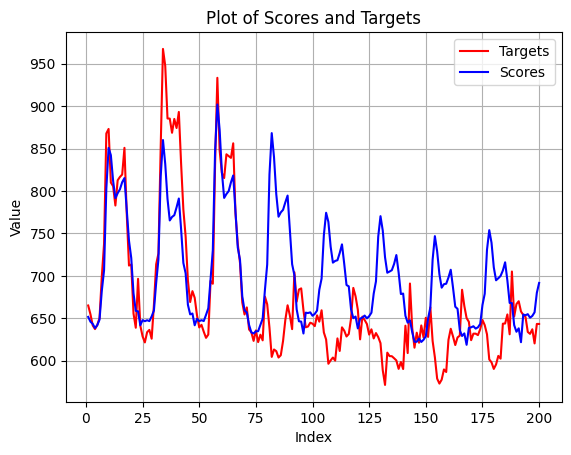

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example numpy arrays

# Create x values (assuming scores are plotted against index)
x = np.arange(len(all_scores[0:200])) + 1

# Plot both arrays on the same graph with different colors

plt.plot(x, all_targets[0:200], color='red', label='Targets')
plt.plot(x, all_scores[0:200], color='blue', label='Scores')

# Adding labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot of Scores and Targets')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(all_targets, all_scores)
print("R² score:", r2)

R² score: 0.4748155842427504


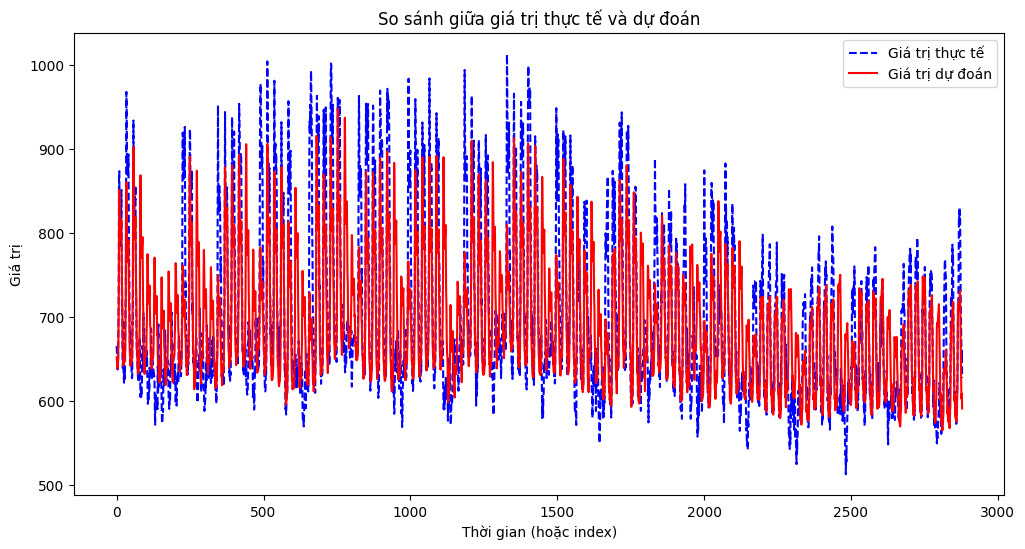

In [ ]:
import matplotlib.pyplot as plt

# Vẽ giá trị thực tế và dự đoán
plt.figure(figsize=(12, 6))
plt.plot(all_targets, label="Giá trị thực tế", color='blue', linestyle='dashed')
plt.plot(all_scores, label="Giá trị dự đoán", color='red')
plt.xlabel("Thời gian (hoặc index)")
plt.ylabel("Giá trị")
plt.title("So sánh giữa giá trị thực tế và dự đoán")
plt.legend()
plt.show()